# Предсказательная модель для “Лента”
**Задача:**

Необходимо создать алгоритм прогноза спроса на 14 дней для товаров собственного производства.   
Метрикой качества выступает **WAPE**, посчитанный на уровне магазин, товар, день (гранулярность ТК-SKU-День)  


**Данные:**

- `sales_df_train.csv` –данные по продажам за скользящий год для обучения
- `pr_df.csv` – данные по товарной иерархии
- `st_df.csv` – данные по магазинам

---

**Бизнес цель:** разработать прогностический инструмент в помощь планирования
приготовления товаров собственного производства (кухня, пекарня и пр.).

**Побочная бизнес цель:** при получении точных прогнозов ожидается снижение
объема упущенных продаж, уменьшение числа списаний по сроку годности.

**Техническая задача:** разработать пайплайн прогноза спроса товаров категории
"Собственное производство" в штуках и построить прогноз на 14 дней в будущее.

**Финальный результат работы пайплайна** - это отчёт/таблица, в которой строим
прогноз спроса по товарам, в каком количестве необходимо их приготовить в каждом ТК,
для повышения доступности товаров на полке, для увеличения продаж, без увеличения

  




**Требования к результату:**  
1. Файл в зафиксированном формате с результатом прогноза спроса(sales_submission.csv).
2. Воспроизводимый код на Python
3. Описание решения:  
    a. Описание модели прогноза спроса, которую вы зафитили
        i. Признаки
        ii. интерпретация (shapley values),
        iii. кросс-валидация
        iv. алгоритмы
    b. Описание вашего алгоритма оптимизации:
        i. методология расчетов
        ii. скорость оптимизации
        
**Критерии оценки:**   
Критерии оценки – WAPE + алгоритм прогноза спроса является понятным, эффективным и
масштабируемым.

Ссылка на сайт заказчика с исследуемыми товарами собственного производства:  
https://lenta.com/catalog/produkciya-sobstvennogo-proizvodstva/

## Подготовка
### Импорт библиотек

In [216]:
# # виртуальное окружение macos
# !python -m venv venv
# !source venv/bin/activate
# !pip install -r requirements.txt

In [1]:
# импорт необходимых библиотек
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import copy
import phik
from itertools import product, combinations
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats as st
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from category_encoders import TargetEncoder
from lightgbm import LGBMRegressor, plot_importance
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import pickle
import joblib
import tsfresh
from tsfresh import extract_features, select_features

# доп. модели 
from catboost import CatBoostRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42

## Загрузка и знакомство с данными

In [3]:
# функция для вывода количества уникальных значений в каждом признаке датафрейма
def feature_unique(df):
    for col in df:
        vc = df[col].value_counts().to_frame()
        vc['Percentage'] =  round((vc['count'] / vc['count'].sum()) * 100, 2)
        print('--------------------------------------------------') 
        print('Количество уникальных значений', '---', col, '---', ':', len(vc))
        display(vc)

### Данные по продажам за скользящий год для обучения `sales_df_train.csv` 

Столбцы:
- `st_id` – захэшированное id магазина;
- `pr_sku_id` – захэшированное id товара;
- `date` – дата;
- `pr_sales_type_id` – флаг наличия промо;
- `pr_sales_in_units` – число проданных товаров без признака промо;
- `pr_promo_sales_in_units` – число проданных товаров с признаком промо;
- `pr_sales_in_rub` – продажи без признака промо в РУБ;
- `pr_promo_sales_in_rub` – продажи с признаком промо в РУБ;

In [142]:
# загрузим датасет инфо о продажах
# признаку дата присвоим тип данных datetime
data_train = pd.read_csv('sales_df_train.csv',  parse_dates=['date'])

# выведем датафрейм
data_train.sample(5)

st_id                         pr_sku_id   
8485    16a5cdae362b8d27a1d8f8c7b78b4330  981fc1c36a9d2ca1791af51e6a857496  \
629035  16a5cdae362b8d27a1d8f8c7b78b4330  21716a96b18e53b7f324cae2ee59d405   
247433  f7e6c85504ce6e82442c770f7c8606f0  9d678e20f4a45c137a0492034506d432   
40897   c81e728d9d4c2f636f067f89cc14862c  836c784d553282c664d502c5c259d767   
323493  f7e6c85504ce6e82442c770f7c8606f0  7a5ebc8af2689363da125308abe00d7f   

             date  pr_sales_type_id  pr_sales_in_units   
8485   2023-06-21                 0                9.0  \
629035 2023-04-07                 0                3.0   
247433 2022-12-26                 0                5.0   
40897  2023-02-02                 1                1.0   
323493 2023-03-14                 1                1.0   

        pr_promo_sales_in_units  pr_sales_in_rub  pr_promo_sales_in_rub  
8485                        0.0           1049.0                    0.0  
629035                      0.0            162.0                    0.0  
247433                      0.0            789.0                    0.0  
40897                       1.0            183.0                  183.0  
323493                      1.0             54.0                   54.0

In [5]:
display(data_train.info(), data_train.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   st_id                    883015 non-null  object        
 1   pr_sku_id                883015 non-null  object        
 2   date                     883015 non-null  datetime64[ns]
 3   pr_sales_type_id         883015 non-null  int64         
 4   pr_sales_in_units        883015 non-null  float64       
 5   pr_promo_sales_in_units  883015 non-null  float64       
 6   pr_sales_in_rub          883015 non-null  float64       
 7   pr_promo_sales_in_rub    883015 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 53.9+ MB


None

count                           mean   
date                       883015  2023-01-25 18:19:37.852697600  \
pr_sales_type_id         883015.0                       0.406486   
pr_sales_in_units        883015.0                       5.037956   
pr_promo_sales_in_units  883015.0                        2.23001   
pr_sales_in_rub          883015.0                     596.705181   
pr_promo_sales_in_rub    883015.0                     294.766561   

                                         min                  25%   
date                     2022-08-01 00:00:00  2022-10-29 00:00:00  \
pr_sales_type_id                         0.0                  0.0   
pr_sales_in_units                      -39.0                  1.0   
pr_promo_sales_in_units                -39.0                  0.0   
pr_sales_in_rub                      -3373.0                 98.0   
pr_promo_sales_in_rub                -3373.0                  0.0   

                                         50%                  75%   
date                     2023-01-27 00:00:00  2023-04-25 00:00:00  \
pr_sales_type_id                         0.0                  1.0   
pr_sales_in_units                        2.0                  4.0   
pr_promo_sales_in_units                  0.0                  1.0   
pr_sales_in_rub                        224.0                540.0   
pr_promo_sales_in_rub                    0.0                127.0   

                                         max          std  
date                     2023-07-18 00:00:00          NaN  
pr_sales_type_id                         1.0     0.491178  
pr_sales_in_units                     2348.0    13.402984  
pr_promo_sales_in_units               2348.0    11.063288  
pr_sales_in_rub                     183265.0  1577.366179  
pr_promo_sales_in_rub               183265.0  1402.764168

In [6]:
# проверка есть ли в целевом признаке нецелые числа
data_train['pr_sales_in_units'].apply(lambda x: x == int(x)).unique()

array([ True])

- Период исторических данных: 01.08.2022 - 18.07.2023

- 40,6% ззаписей с продажами по промо

- Целевой признак `pr_sales_in_units`, содержит только целые значения 

- Отрицательные значения в количествах и ценах. Возможно, возврат товара. Не будем использовать эти записи для прогноза спроса или преобразуем

- В случае промоакции цена и количество товара такое же как указано в признаках без промопкции `pr_sales_in_rub` и `pr_sales_in_units`

**Дублирующие значения в `pr_sales_in_units` и `pr_promo_sales_in_units`, `pr_sales_in_rub` и `pr_promo_sales_in_rub`**:

In [7]:
# проверим совпадают ли значения в количестве и цене без промо со значениями в аналогичных столбцах с промо
promo_df = data_train[data_train['pr_sales_type_id']==1]
print('Значения в признаках совпадают:', promo_df['pr_sales_in_rub'].equals(promo_df['pr_promo_sales_in_rub']),\
                                promo_df['pr_sales_in_units'].equals(promo_df['pr_promo_sales_in_units']))

Значения в признаках совпадают: True True


Далее удалим признаки с количеством и ценой промо.

**Отрицательные значения в в `pr_sales_in_units` и `pr_promo_sales_in_units`, `pr_sales_in_rub` и `pr_promo_sales_in_rub`**

In [8]:
# проверим объекты с отрицательными значениями
minus_df = data_train[(data_train['pr_sales_in_rub']<0) | (data_train['pr_sales_in_units']<0)]
minus_df.describe().T

count                           mean   
date                       79  2023-01-23 08:12:09.113924096  \
pr_sales_type_id         79.0                       0.468354   
pr_sales_in_units        79.0                      -3.341772   
pr_promo_sales_in_units  79.0                      -1.898734   
pr_sales_in_rub          79.0                    -469.303797   
pr_promo_sales_in_rub    79.0                    -253.037975   

                                         min                  25%   
date                     2022-08-03 00:00:00  2022-11-03 12:00:00  \
pr_sales_type_id                         0.0                  0.0   
pr_sales_in_units                      -39.0                 -3.0   
pr_promo_sales_in_units                -39.0                 -2.5   
pr_sales_in_rub                      -3373.0               -528.5   
pr_promo_sales_in_rub                -3373.0               -324.5   

                                         50%                  75%   
date                     2022-12-29 00:00:00  2023-04-29 12:00:00  \
pr_sales_type_id                         0.0                  1.0   
pr_sales_in_units                       -2.0                 -1.0   
pr_promo_sales_in_units                  0.0                  0.0   
pr_sales_in_rub                       -318.0               -130.5   
pr_promo_sales_in_rub                    0.0                  0.0   

                                         max         std  
date                     2023-07-16 00:00:00         NaN  
pr_sales_type_id                         1.0    0.502186  
pr_sales_in_units                       -0.0    5.638435  
pr_promo_sales_in_units                  0.0    4.876934  
pr_sales_in_rub                          0.0  574.293174  
pr_promo_sales_in_rub                    0.0  545.904881

Всего 79 объектов с отрицательными значениями, среди них 6 магазинов и 66 SKU. Далее удалим эти объекты (заменим на 0)

**Проверка на дубликаты**

In [9]:
print('Полные дубликаты:', data_train.duplicated().sum(), '\n',
      'Дубликаты Магазин-Товар-День:', data_train[['st_id', 'pr_sku_id', 'date']].duplicated().sum(), 'шт.',
            round(data_train[['st_id', 'pr_sku_id', 'date']].duplicated().sum()/len(data_train)*100,2), '%\n',
      'Дубликаты Магазин-Товар-День-Промоакция:',
            data_train[['st_id','pr_sku_id','date','pr_sales_type_id']].duplicated().sum())


Полные дубликаты: 0 
 Дубликаты Магазин-Товар-День: 182053 шт. 20.62 %
 Дубликаты Магазин-Товар-День-Промоакция: 0


In [10]:
# выведем строки, которые имеют дубликаты
data_train[data_train[['st_id', 'pr_sku_id', 'date']].duplicated()].sample(3)

st_id                         pr_sku_id   
716897  fa7cdfad1a5aaf8370ebeda47a1ff1c3  6d8bf88f6daf3b37de081afcf75ec6cf  \
727254  f7e6c85504ce6e82442c770f7c8606f0  cbaca3167c8aa7c3352f2e7be9300285   
738277  c81e728d9d4c2f636f067f89cc14862c  f0b2b0e013970cb4e096e3dbc561f434   

             date  pr_sales_type_id  pr_sales_in_units   
716897 2022-10-18                 1               15.0  \
727254 2022-11-14                 0                4.0   
738277 2022-12-06                 0                5.0   

        pr_promo_sales_in_units  pr_sales_in_rub  pr_promo_sales_in_rub  
716897                     15.0            818.0                  818.0  
727254                      0.0            472.0                    0.0  
738277                      0.0            854.0                    0.0

In [11]:
# посмотрим на пример дублирующих строк
data_train[(data_train['st_id']=='1ecfb463472ec9115b10c292ef8bc986')&
         (data_train['pr_sku_id']=='7454973f4428e8a3426bb3c01e007104')&
         (data_train['date']=='2023-05-17')]

st_id                         pr_sku_id   
345998  1ecfb463472ec9115b10c292ef8bc986  7454973f4428e8a3426bb3c01e007104  \
834049  1ecfb463472ec9115b10c292ef8bc986  7454973f4428e8a3426bb3c01e007104   

             date  pr_sales_type_id  pr_sales_in_units   
345998 2023-05-17                 1                1.0  \
834049 2023-05-17                 0                1.0   

        pr_promo_sales_in_units  pr_sales_in_rub  pr_promo_sales_in_rub  
345998                      1.0             33.0                   33.0  
834049                      0.0             41.0                    0.0

- Полных дубликатов в данных нет
- По одному Магазину-Товару-Дню есть дублирующие записи - с промоакцией и без: 182 053 записи - 20,6%

**Неполные данные в в `pr_sales_in_units` и `pr_promo_sales_in_units`**

Обнаружены строки, в которых число проданных товаров равно нулю, но сумма продаж больше нуля.

In [12]:
# выведем строки в которых только одно из двух значений (число товаров и цена) равно нулю
data_train[(data_train['pr_sales_in_units']==0) & (data_train['pr_sales_in_rub']>0) |
         (data_train['pr_sales_in_units']>0) & (data_train['pr_sales_in_rub']==0)]

st_id                         pr_sku_id   
3       42a0e188f5033bc65bf8d78622277c4e  8e887cf8e64ab8e7173701a979476567  \
6       f7e6c85504ce6e82442c770f7c8606f0  b75c7cbf7accdaea8a1a14781bb29870   
27      42a0e188f5033bc65bf8d78622277c4e  cfb54b1ce12bb3f9b6b9e2ea0b57414b   
28      f7e6c85504ce6e82442c770f7c8606f0  88d7313785c97631bf3df61e70636491   
30      f7e6c85504ce6e82442c770f7c8606f0  3474f0e025c7deb7e127a35763bc5512   
...                                  ...                               ...   
882978  fa7cdfad1a5aaf8370ebeda47a1ff1c3  a1f93a1aeb02759147d69276c70217db   
882979  6364d3f0f495b6ab9dcf8d3b5c6e0b01  cda72490a16c471e7a192a956f476e95   
882991  16a5cdae362b8d27a1d8f8c7b78b4330  7d945116ed12c2807d081df6f666ba37   
883004  42a0e188f5033bc65bf8d78622277c4e  143f62003066d8d4cc33d3e9161d114d   
883005  fa7cdfad1a5aaf8370ebeda47a1ff1c3  d2d8c0f1e97017883799eeb270accbf4   

             date  pr_sales_type_id  pr_sales_in_units   
3      2023-04-05                 1                0.0  \
6      2023-02-15                 0                0.0   
27     2022-11-10                 0                0.0   
28     2022-11-30                 0                0.0   
30     2023-06-06                 1                8.0   
...           ...               ...                ...   
882978 2023-06-07                 1                0.0   
882979 2023-04-11                 0                0.0   
882991 2023-07-01                 1                0.0   
883004 2022-12-25                 1                0.0   
883005 2022-10-25                 1                0.0   

        pr_promo_sales_in_units  pr_sales_in_rub  pr_promo_sales_in_rub  
3                           0.0             69.0                   69.0  
6                           0.0            171.0                    0.0  
27                          0.0             91.0                    0.0  
28                          0.0             79.0                    0.0  
30                          8.0              0.0                    0.0  
...                         ...              ...                    ...  
882978                      0.0             30.0                   30.0  
882979                      0.0             62.0                    0.0  
882991                      0.0             70.0                   70.0  
883004                      0.0             41.0                   41.0  
883005                      0.0            130.0                  130.0  

[66875 rows x 8 columns]

7,6% записей имеют некорректные значения продаж:
- 7,5% записей имеют 0 товаров, но есть выручка 
- 0,1% - 0 выручка, но есть продажи в штуках

Заказчик ответил, что такие данные некорректные, будет разбираться. Далее придётся избавиться от таких объектов.

### Данные по товарной иерархии `pr_df.csv`

От большего к меньшему `pr_group_id` - `pr_cat_id` - `pr_subcat_id` - `pr_sku_id`.

Столбцы:
- `pr_group_id` – захэшированная группа товара;
- `pr_cat_id` – захэшированная категория товара;
- `pr_subcat_id` – захэшированная подкатегория товара;
- `pr_sku_id` – захэшированное id товара;
- `pr_uom_id` - маркер, обозначающий продаётся товар на вес или в ШТ.

In [13]:
data_hierarchy = pd.read_csv('pr_df.csv') 
data_hierarchy.sample(5)

pr_sku_id                       pr_group_id   
754   fd519eb13005448a303df1089505a42b  32bb90e8976aab5298d5da10fe66f21d  \
1164  1f08f7cfdcb8bb9088fe668e0aeb6586  aab3238922bcc25a6f606eb525ffdc56   
426   25297b758a38dfb3475046e5dc01291a  c74d97b01eae257e44aa9d5bade97baf   
984   73a32464b3cb3ac9b59c7eb5b4356730  aab3238922bcc25a6f606eb525ffdc56   
1094  5243d57b3a58fd110b786b9521a9af79  1ff1de774005f8da13f42943881c655f   

                             pr_cat_id                      pr_subcat_id   
754   f862d13454fd267baa5fedfffb200567  76edb781a6decc9f7dd7e94622f857e6  \
1164  3de2334a314a7a72721f1f74a6cb4cee  0f3abfd67959c079e7b3759440e7415c   
426   7a6a74cbe87bc60030a4bd041dd47b78  e1161a3e62c78d84c12300ab00ff95de   
984   9701a1c165dd9420816bfec5edd6c2b1  3055a089cffae7c29c8942e5eb534a2a   
1094  a6ea8471c120fe8cc35a2954c9b9c595  641497844d85cd76388bca1f14125055   

      pr_uom_id  
754           1  
1164         17  
426           1  
984           1  
1094          1

In [14]:
display(data_hierarchy.info(), data_hierarchy.describe(include='all').T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pr_sku_id     2050 non-null   object
 1   pr_group_id   2050 non-null   object
 2   pr_cat_id     2050 non-null   object
 3   pr_subcat_id  2050 non-null   object
 4   pr_uom_id     2050 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 80.2+ KB


None

count unique                               top freq      mean   
pr_sku_id       2050   2050  fd064933250b0bfe4f926b867b0a5ec8    1       NaN  \
pr_group_id     2050      9  c74d97b01eae257e44aa9d5bade97baf  806       NaN   
pr_cat_id       2050     43  c559da2ba967eb820766939a658022c8  265       NaN   
pr_subcat_id    2050    170  8feef08314d477a5b68ba18a6d35819d   72       NaN   
pr_uom_id     2050.0    NaN                               NaN  NaN  7.017561   

                   std  min  25%  50%   75%   max  
pr_sku_id          NaN  NaN  NaN  NaN   NaN   NaN  
pr_group_id        NaN  NaN  NaN  NaN   NaN   NaN  
pr_cat_id          NaN  NaN  NaN  NaN   NaN   NaN  
pr_subcat_id       NaN  NaN  NaN  NaN   NaN   NaN  
pr_uom_id     7.752371  1.0  1.0  1.0  17.0  17.0

О иерархии товаров дана информация:
- 2050 SKU товаров, дубликатов нет
- 9 групп
- 43 категории
- 170 подкатегорий
- 2 маркера единицы измерения товара: `1` и `17`, предположительно, штука и весовая единица

###  Данные по магазинам `st_df.csv` 

Столбцы:
- `st_id` – захэшированное id магазина;
- `st_city_id` – захэшированное id города;
- `st_division_code id` – захэшированное id дивизиона;
- `st_type_format_id` – id формата магазина;
- `st_type_loc_id` – id тип локации/окружения магазина;
- `st_type_size_id` – id типа размера магазина;
- `st_is_active` – флаг активного магазина на данный момент.

In [15]:
# загружаем даттасет
data_stores = pd.read_csv('st_df.csv') 
data_stores

st_id                        st_city_id   
0   1aa057313c28fa4a40c5bc084b11d276  1587965fb4d4b5afe8428a4a024feb0d  \
1   bd470ca955d9497bbcb808e59952fffc  955d864a62659945cc9434898e275deb   
2   6364d3f0f495b6ab9dcf8d3b5c6e0b01  b8b4b727d6f5d1b61fff7be687f7970f   
3   1ecfb463472ec9115b10c292ef8bc986  908c9a564a86426585b29f5335b619bc   
4   16a5cdae362b8d27a1d8f8c7b78b4330  c1f75cc0f7fe269dd0fd9bd5e24f9586   
5   53e19f3dbb211f20b20b45668303c1b6  955d864a62659945cc9434898e275deb   
6   42a0e188f5033bc65bf8d78622277c4e  b8b4b727d6f5d1b61fff7be687f7970f   
7   c81e728d9d4c2f636f067f89cc14862c  908c9a564a86426585b29f5335b619bc   
8   fa7cdfad1a5aaf8370ebeda47a1ff1c3  885fe656777008c335ac96072a45be15   
9   f7e6c85504ce6e82442c770f7c8606f0  3202111cf90e7c816a472aaceb72b0df   
10  62f91ce9b820a491ee78c108636db089  1587965fb4d4b5afe8428a4a024feb0d   
11  084a8a9aa8cced9175bd07bc44998e75  3202111cf90e7c816a472aaceb72b0df   

                    st_division_code  st_type_format_id  st_type_loc_id   
0   81b4dd343f5880df806d4c5d4a846c64                  4               3  \
1   e26072c92d8fe0738df44d571d5f5e8b                  4               3   
2   da742b3cfca5388aaf9af28a726a3c30                  1               1   
3   429a86ff6336c144ddaf6144f52ab52c                  2               1   
4   296bd0cc6e735f9d7488ebc8fbc19130                  1               2   
5   e26072c92d8fe0738df44d571d5f5e8b                  4               3   
6   da742b3cfca5388aaf9af28a726a3c30                  1               1   
7   429a86ff6336c144ddaf6144f52ab52c                  1               1   
8   296bd0cc6e735f9d7488ebc8fbc19130                  1               1   
9   32586311f16876abf92901085bd87b99                  1               1   
10  81b4dd343f5880df806d4c5d4a846c64                  4               3   
11  32586311f16876abf92901085bd87b99                  4               3   

    st_type_size_id  st_is_active  
0                19             0  
1                19             1  
2                12             1  
3                28             1  
4                 8             1  
5                20             1  
6                12             1  
7                 8             1  
8                12             1  
9                12             1  
10               32             0  
11               19             1

In [16]:
data_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   st_id              12 non-null     object
 1   st_city_id         12 non-null     object
 2   st_division_code   12 non-null     object
 3   st_type_format_id  12 non-null     int64 
 4   st_type_loc_id     12 non-null     int64 
 5   st_type_size_id    12 non-null     int64 
 6   st_is_active       12 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 800.0+ bytes


In [17]:
# количество уникальных значений в каждом признаке
feature_unique(data_stores)

--------------------------------------------------
Количество уникальных значений --- st_id --- : 12


count  Percentage
st_id                                              
1aa057313c28fa4a40c5bc084b11d276      1        8.33
bd470ca955d9497bbcb808e59952fffc      1        8.33
6364d3f0f495b6ab9dcf8d3b5c6e0b01      1        8.33
1ecfb463472ec9115b10c292ef8bc986      1        8.33
16a5cdae362b8d27a1d8f8c7b78b4330      1        8.33
53e19f3dbb211f20b20b45668303c1b6      1        8.33
42a0e188f5033bc65bf8d78622277c4e      1        8.33
c81e728d9d4c2f636f067f89cc14862c      1        8.33
fa7cdfad1a5aaf8370ebeda47a1ff1c3      1        8.33
f7e6c85504ce6e82442c770f7c8606f0      1        8.33
62f91ce9b820a491ee78c108636db089      1        8.33
084a8a9aa8cced9175bd07bc44998e75      1        8.33

--------------------------------------------------
Количество уникальных значений --- st_city_id --- : 7


count  Percentage
st_city_id                                         
1587965fb4d4b5afe8428a4a024feb0d      2       16.67
955d864a62659945cc9434898e275deb      2       16.67
b8b4b727d6f5d1b61fff7be687f7970f      2       16.67
908c9a564a86426585b29f5335b619bc      2       16.67
3202111cf90e7c816a472aaceb72b0df      2       16.67
c1f75cc0f7fe269dd0fd9bd5e24f9586      1        8.33
885fe656777008c335ac96072a45be15      1        8.33

--------------------------------------------------
Количество уникальных значений --- st_division_code --- : 6


count  Percentage
st_division_code                                   
81b4dd343f5880df806d4c5d4a846c64      2       16.67
e26072c92d8fe0738df44d571d5f5e8b      2       16.67
da742b3cfca5388aaf9af28a726a3c30      2       16.67
429a86ff6336c144ddaf6144f52ab52c      2       16.67
296bd0cc6e735f9d7488ebc8fbc19130      2       16.67
32586311f16876abf92901085bd87b99      2       16.67

--------------------------------------------------
Количество уникальных значений --- st_type_format_id --- : 3


count  Percentage
st_type_format_id                   
1                      6       50.00
4                      5       41.67
2                      1        8.33

--------------------------------------------------
Количество уникальных значений --- st_type_loc_id --- : 3


count  Percentage
st_type_loc_id                   
1                   6       50.00
3                   5       41.67
2                   1        8.33

--------------------------------------------------
Количество уникальных значений --- st_type_size_id --- : 6


count  Percentage
st_type_size_id                   
12                   4       33.33
19                   3       25.00
8                    2       16.67
28                   1        8.33
20                   1        8.33
32                   1        8.33

--------------------------------------------------
Количество уникальных значений --- st_is_active --- : 2


count  Percentage
st_is_active                   
1                10       83.33
0                 2       16.67

По информации о магазинах дано:
- 12 магазинов
- 7 городов
- 6 дивизионов
- 3 формата магазина
- 3 типа локации / окружения
- 6 типа размера магазина
- 2 флага активности магазина

От двух неактивных магазинов рекомендовано избавиться в исследовании


### Формат предоставления результатов
Столбцы:
- `st_id` – захэшированное id магазина;
- `pr_sku_id` – захэшированное id товара;
- `date` – дата (день);
- `target` – спрос в ШТ.

In [18]:
data_submission = pd.read_csv('sales_submission.csv', parse_dates=['date'])
display(data_submission.head(2), data_submission.describe().T)

st_id                         pr_sku_id   
0  16a5cdae362b8d27a1d8f8c7b78b4330  0045ebdb1069ff4b3dd3efe628c39cd3  \
1  16a5cdae362b8d27a1d8f8c7b78b4330  00661699f543753ec7e911a64b9fd2f6   

        date  target  
0 2023-07-20       0  
1 2023-07-20       0

count                 mean                  min   
date      43694  2023-07-25 12:00:00  2023-07-19 00:00:00  \
target  43694.0                  0.0                  0.0   

                        25%                  50%                  75%   
date    2023-07-22 00:00:00  2023-07-25 12:00:00  2023-07-29 00:00:00  \
target                  0.0                  0.0                  0.0   

                        max  std  
date    2023-08-01 00:00:00  NaN  
target                  0.0  0.0

- Период тестовой выборки: 19.07.2023 - 01.08.2023 - это следующие 2 недели после периода тренировочной выборки

**Уникальные комбинации Магазин-SKU**

In [19]:
# в выборке трейн
id_combinations = data_train[['st_id', 'pr_sku_id']].drop_duplicates()
id_combinations = id_combinations.sort_values(by='st_id')
id_combinations

st_id                         pr_sku_id
6121    084a8a9aa8cced9175bd07bc44998e75  0376a60d9a7ce7965beddc4815588697
70409   084a8a9aa8cced9175bd07bc44998e75  88feeeb024d3f69da7322d76b7b53744
283232  084a8a9aa8cced9175bd07bc44998e75  be8d2843456cac871fc116ab25d02994
718425  084a8a9aa8cced9175bd07bc44998e75  61ede1b712ff37c91101eed14b7a6c4f
474435  084a8a9aa8cced9175bd07bc44998e75  c4a665596d4f67cecb7542c9fad407ee
...                                  ...                               ...
63373   fa7cdfad1a5aaf8370ebeda47a1ff1c3  b77bf3cb7967619f5b3d226d63dae631
3231    fa7cdfad1a5aaf8370ebeda47a1ff1c3  603c32f40317b3179730bb4d8a032f84
3235    fa7cdfad1a5aaf8370ebeda47a1ff1c3  ac5e32a7c6935026790d45158890248b
64515   fa7cdfad1a5aaf8370ebeda47a1ff1c3  bd71efb213fe0ace2b684bdfebd78f58
3096    fa7cdfad1a5aaf8370ebeda47a1ff1c3  3fd6083ec914187fb775df5103ffb95d

[6244 rows x 2 columns]

В обучающем датасете 6203 уникальные комбинации Магазин-Товар

In [20]:
# в файле для тестирования  submission 
comb_submission = data_submission[['st_id', 'pr_sku_id']].drop_duplicates()

In [21]:
# множеста комбинаций магазин-продукт из обучающего датасета и сабмишн
id_set_train = set([(x, y) for x, y in zip (data_train['st_id'], data_train['pr_sku_id'])])
id_set_submission = set([(x, y) for x, y in zip (data_submission['st_id'], data_submission['pr_sku_id'])])
print('Комбинации Магазин-Товар в Submission есть обучающем датасете: ', id_set_submission.issubset(id_set_train))

Комбинации Магазин-Товар в Submission есть обучающем датасете:  False


In [22]:
# каких комбинаций из сабмишн нет в трейне 126 штук
print('Отсутствущие в обучающем даттасете комбинации Магазин-Товар тестового датасета Submission:', 
      len(id_set_submission - id_set_train))

Отсутствущие в обучающем даттасете комбинации Магазин-Товар тестового датасета Submission: 126


---

Познакомились с предоставленными 3 датасетами: исторические данные о продажах за год, товарная иерархия, информация о магазинах.


- Целевой признак `pr_sales_in_units` - число проданных товаров, но помимо него выделен аналогичный признак `pr_promo_sales_in_units`, который дублирует продажи только для продаж по промо

-  В товарной иерархии признак pr_uom_id (продаётся на вес или в штуках) имеет 2 значения 1 и 17. Будем использовать закодированные значения как есть. В целевом признаке только целые числа, возможно, в случае весовых продуктов единицей измерения является не 1 кг, а меньше (например, 500 грамм).

- Среди 12 есть 2 неактивных магазина. Рекомендовано не использовать информацию о них.

- Обнаружены  0,0001% (79 записей) с отрицательными значениями в целевом признаке - число проданных товаров, а также продажах. Значения будут удалены.
   
- 7,6% записей имеют некорректные значения продаж:  7,5% записей имеют 0 товаров, но есть выручка, 0,1% - 0 выручка, но есть продажи в штуках. Заказчик попросил исключить эти данные, будет разбираться

- По одному Магазину-Товару-Дню есть дублирующие записи - с промоакцией и без: 182 053 записи (20,6%) - параллельные временные ряды для одной позиции в магазине по продажам с промо и без
    

## Подготовка данных для анализа

### Объединение датасетов
К датасету трейн присоединим два других:
- датасет с иерархией товаров по id магазина `st_id` 
- датасет с магазинами по id товара `pr_sku_id` 

Далее отсортируем данные по возрастанию даты

In [23]:
# объединение таблиц
df = data_train.merge(data_hierarchy, on='pr_sku_id', how='left').merge(data_stores, on='st_id', how='left')
# проверка монотонности дат -> False
print(df['date'].is_monotonic_increasing)
# # отсортируем датафрейм по возрастанию даты
df.sort_values(by='date', inplace=True)
df.sample(3)

False


st_id                         pr_sku_id   
207799  42a0e188f5033bc65bf8d78622277c4e  6157d6990d9a15027be2e356cccdc84d  \
584199  fa7cdfad1a5aaf8370ebeda47a1ff1c3  5ca106c323e777ec8b42dbbab099932c   
134012  42a0e188f5033bc65bf8d78622277c4e  65b549322da3ee58ae90de15c61b62ae   

             date  pr_sales_type_id  pr_sales_in_units   
207799 2023-06-10                 1              131.0  \
584199 2022-08-14                 0                6.0   
134012 2022-11-30                 0                1.0   

        pr_promo_sales_in_units  pr_sales_in_rub  pr_promo_sales_in_rub   
207799                    131.0          15965.0                15965.0  \
584199                      0.0            315.0                    0.0   
134012                      0.0             19.0                    0.0   

                             pr_group_id                         pr_cat_id   
207799  c20ad4d76fe97759aa27a0c99bff6710  fb2fcd534b0ff3bbed73cc51df620323  \
584199  c74d97b01eae257e44aa9d5bade97baf  f3173935ed8ac4bf073c1bcd63171f8a   
134012  c74d97b01eae257e44aa9d5bade97baf  1bc0249a6412ef49b07fe6f62e6dc8de   

                            pr_subcat_id  pr_uom_id   
207799  45551f4c29881972ae5ed3666a5b1b8b          1  \
584199  5fd72b9fc7118bd36a137d7cea8c588a         17   
134012  ca34f669ae367c87f0e75dcae0f61ee5         17   

                              st_city_id                  st_division_code   
207799  b8b4b727d6f5d1b61fff7be687f7970f  da742b3cfca5388aaf9af28a726a3c30  \
584199  885fe656777008c335ac96072a45be15  296bd0cc6e735f9d7488ebc8fbc19130   
134012  b8b4b727d6f5d1b61fff7be687f7970f  da742b3cfca5388aaf9af28a726a3c30   

        st_type_format_id  st_type_loc_id  st_type_size_id  st_is_active  
207799                  1               1               12             1  
584199                  1               1               12             1  
134012                  1               1               12             1

Получили общий датасет размером 883015 rows × 18 columns

### Очистка данных

- Удалим все записи по двум неактивным магазинам 0,08%

- Заменим некорректные значения на нули:
    -  отрицательные значения 0,0001%
    -  некорретные записи: 7,5% записей имеют 0 товаров, но есть выручка, 0,1% - 0 выручка, но есть продажи в штуках

In [24]:
# удалим 2 неактивных магазина
df = df[df['st_is_active']!=0]
# удалим столбец с активностью магазина
df = df.drop('st_is_active', axis=1)

# замена отрицательных значений на нул
demand_cols = ['pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub']
for col in demand_cols:
    df[col] = df[col].apply(lambda x: 0 if x < 0 else x)


# отфильтруем записи в которых некорректные комбинации число и выручка (один 0), сохраним индексы
index_for_change = df.loc[(df['pr_sales_in_units']==0) & (df['pr_sales_in_rub']>0) | 
                          (df['pr_sales_in_units']>0) & (df['pr_sales_in_rub']==0)].index
# заменим значения на нули
df.loc[index_for_change, 'pr_sales_in_rub'] = 0
df.loc[index_for_change, 'pr_sales_in_units'] = 0
df.loc[index_for_change, 'pr_promo_sales_in_rub'] = 0
df.loc[index_for_change, 'pr_promo_sales_in_units'] = 0

df.describe().T

count                           mean   
date                       882286  2023-01-25 21:37:05.865989888  \
pr_sales_type_id         882286.0                       0.406593   
pr_sales_in_units        882286.0                       5.035805   
pr_promo_sales_in_units  882286.0                       2.227668   
pr_sales_in_rub          882286.0                     591.202836   
pr_promo_sales_in_rub    882286.0                     292.415301   
pr_uom_id                882286.0                       6.743643   
st_type_format_id        882286.0                       1.094039   
st_type_loc_id           882286.0                       1.205435   
st_type_size_id          882286.0                      11.457958   

                                         min                  25%   
date                     2022-08-01 00:00:00  2022-10-30 00:00:00  \
pr_sales_type_id                         0.0                  0.0   
pr_sales_in_units                        0.0                  1.0   
pr_promo_sales_in_units                  0.0                  0.0   
pr_sales_in_rub                          0.0                 91.0   
pr_promo_sales_in_rub                    0.0                  0.0   
pr_uom_id                                1.0                  1.0   
st_type_format_id                        1.0                  1.0   
st_type_loc_id                           1.0                  1.0   
st_type_size_id                          8.0                  8.0   

                                         50%                  75%   
date                     2023-01-27 00:00:00  2023-04-25 00:00:00  \
pr_sales_type_id                         0.0                  1.0   
pr_sales_in_units                        2.0                  4.0   
pr_promo_sales_in_units                  0.0                  1.0   
pr_sales_in_rub                        222.0                540.0   
pr_promo_sales_in_rub                    0.0                124.0   
pr_uom_id                                1.0                 17.0   
st_type_format_id                        1.0                  1.0   
st_type_loc_id                           1.0                  1.0   
st_type_size_id                         12.0                 12.0   

                                         max          std  
date                     2023-07-18 00:00:00          NaN  
pr_sales_type_id                         1.0     0.491198  
pr_sales_in_units                     2348.0    13.407376  
pr_promo_sales_in_units               2348.0    11.065748  
pr_sales_in_rub                     183265.0  1579.922032  
pr_promo_sales_in_rub               183265.0  1403.741735  
pr_uom_id                               17.0     7.675215  
st_type_format_id                        4.0     0.407205  
st_type_loc_id                           3.0      0.43601  
st_type_size_id                         28.0     4.505658

In [25]:
# доля нулей в целевом признаке
print(f'Доля нулей в целевом признаке - число товаров: {round((df["pr_sales_in_units"]==0).sum() / len(df) * 100, 2)}%')
print(f'Доля нулей в выручке: {round((df["pr_sales_in_rub"]==0).sum() / len(df) * 100, 2)}%')

Доля нулей в целевом признаке - число товаров: 7.64%
Доля нулей в выручке: 7.64%


### Создание признака Цена
**Стоимость одного товара за день**

In [26]:
# Стоимость одного товара (за день)
df['price_day_product'] = round(df['pr_sales_in_rub']/df['pr_sales_in_units'], 1)
# пропуски из-за деления на ноль заменим на 0
df.loc[df['price_day_product'].isna(), 'price_day_product'] = 0

**Стоимость группы товаров за день**

In [27]:
# создадим столбец
df['price_day_group'] = 0
# группируем данные по группе товаров и дате
for index, group in df.groupby(['pr_group_id', 'date']):
    total_sales = group['pr_sales_in_rub'].sum()
    units_sold = group['pr_sales_in_units'].sum()
    if units_sold != 0:
        average_price = total_sales / units_sold
    else:
        average_price = 0     
    df.loc[group.index, 'price_day_group'] = round(average_price, 1)
    

## Разведочный анализ данных
Построим графики временных рядов, сделаем декомпозицию. Оценим выбросы, корреляцию и сравним распределения товаров по группам.



###  Графики временных рядов


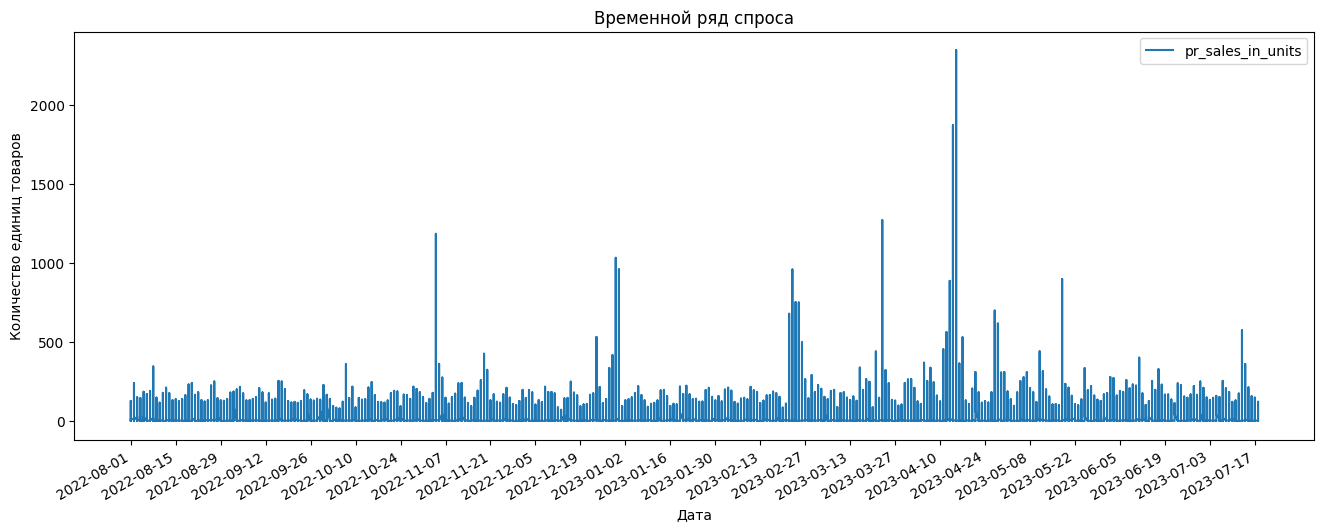

In [28]:
# график спроса по датам
df.plot(x='date',y='pr_sales_in_units', figsize=(16,6),
        title=('Временной ряд спроса'), xlabel=('Дата'), ylabel=('Количество единиц товаров'))
plt.xticks(np.arange(df['date'].min(), df['date'].max(), timedelta(days=14)))
None

В течение года есть несколько высоких пиков спроса в основном в районе праздников
- 4 ноября
- Предновогодний период
- Период 23 февраля
- 20-е числа марта?
- Самый большой пик Пасха 16 апреля
- Майские праздничные выходные
- единичный примерно 15 мая

Для самых распространённых праздников пики длятся несколько дней 


На графике виден спад средних продаж в зимний сезон и выбивающиеся пики в период праздников Новый год и Пасха:

In [29]:
# декомпозируем временной ряд ряд агрегированного по дням временного ряда с средними продажами
aggregated_df = df.set_index('date')['pr_sales_in_units'].resample('1D').mean()
decomposed = seasonal_decompose(aggregated_df)

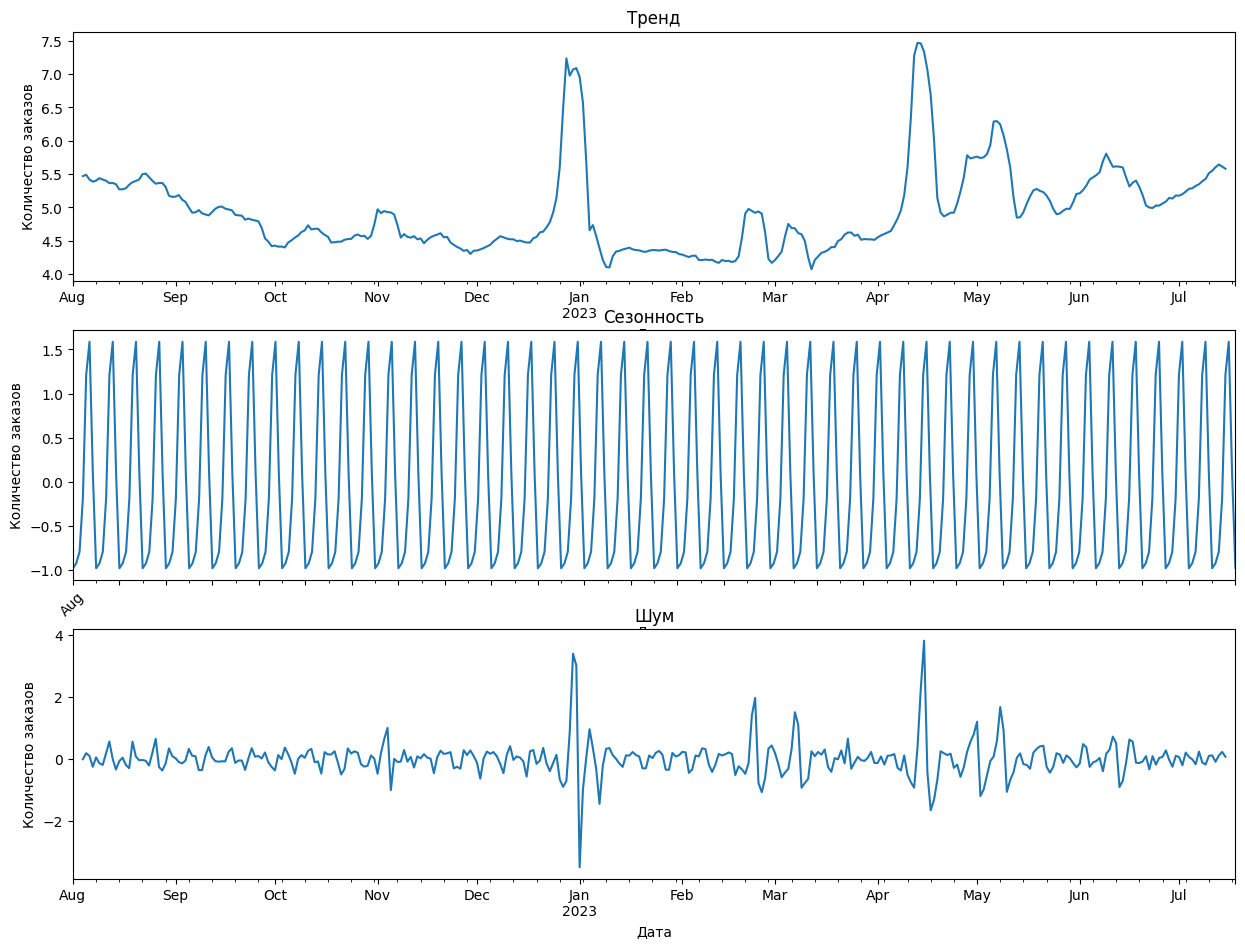

In [30]:
# построим графики разложенного ряда:
plt.figure(figsize=(15,11))
# тренд
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
# сезонность
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.xlim(['2022-09-01', '2022-11-01'])
plt.xticks(np.arange(df['date'].min(), df['date'].max(), timedelta(days=14)), rotation=45)
# шум
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Шум')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.show()


На графике виден спад средних продаж в зимний сезон и выбивающиеся пики в период праздников Новый год и Пасха:
- На тренде виден спад средних продаж в холодный период года и увеличение Апрель - Сентябрь
- Резкие подъемы продах в районе двух праздников в году - Новый год и Пасха. Также майские праздники
- Недельная сезонность: верхний пик в субботу, спад в понедельник

### Выбросы

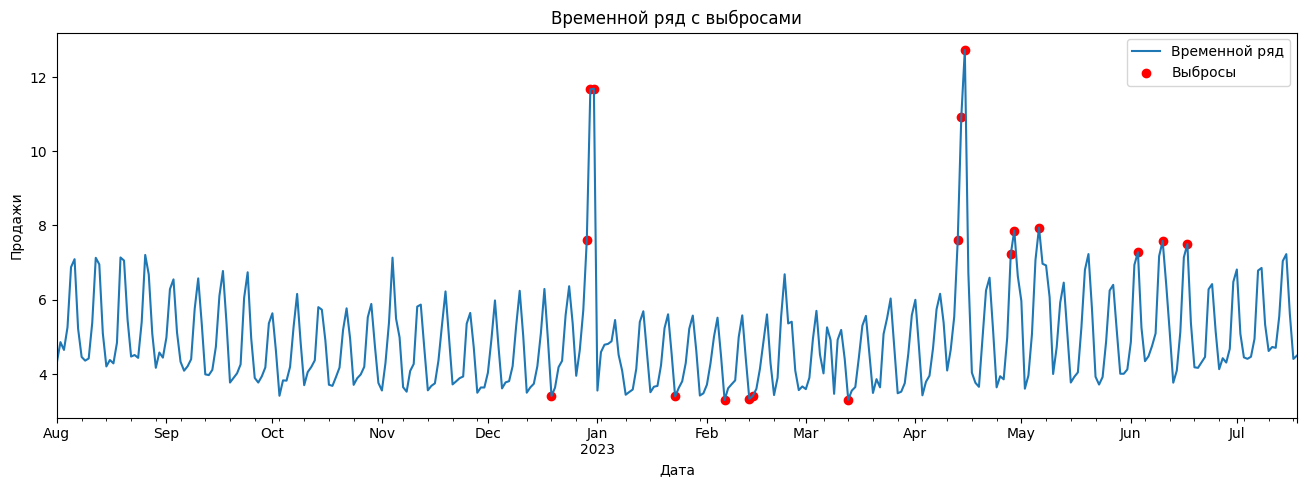

In [31]:

# Преобразование данных в numpy массив
values = aggregated_df.values
# Обучение модели Isolation Forest для детектирования выбросов
model = IsolationForest(contamination=0.05)  # указываем ожидаемую долю выбросов
model.fit(values.reshape(-1, 1)) 

# Предсказание выбросов
outliers = model.predict(values.reshape(-1, 1))

# Извлечение выбросов из данных
outlier_values = values[outliers == -1]

# Визуализация временного ряда и выбросов
aggregated_df.plot(figsize=(16, 5), label='Временной ряд')
plt.scatter(aggregated_df[outliers == -1].index, outlier_values, color='red', label='Выбросы')
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.title('Временной ряд с выбросами')
plt.legend()
plt.show()

Высокие продажи продуктов собственного производства в Новый год и Пасху не являются аномалиями, так как застолье эти праздники распространены. Слишком низкие продажи зимой и высокие, начиная с конца апреля, объясняются годовой сезонностью спроса на эти продукты, также выглядят закономерно.

### Товары с высоким средним спросом
Посмотрим на временные ряды отдельных товаров с делением на продажи по промо и без

In [32]:
# Медиана спроса за день на товар, 10 товаров с самой высокой медианой
top_10 = df.groupby('pr_sku_id')['pr_sales_in_units'].median().sort_values(ascending=False)[:10].to_frame()
top_10

pr_sales_in_units
pr_sku_id                                          
5af7d2c94cb126b9cd5b485c4a0732fc               41.0
20d9b4bfd4b672f61d87f420856aac5d               33.0
c0e3f3bd815a862433bc3399c487926b               31.0
fd55c4022acef4de4c7dc6cdd85a2d7a               31.0
9aa7008fa27151bf77be5f4c9d023d5f               26.5
4b083e10f6cd2f4360c5425d05be6386               22.0
6d6ca571e2a7d2ec70bd9c09aac38f92               18.0
62d4af457ba2540ce0898a211c0cd17a               16.0
ae9aebfac21c0f936c47eb52ff16c32b               15.0
dadedf5a68c5640f8b838908f643ad1d               14.5

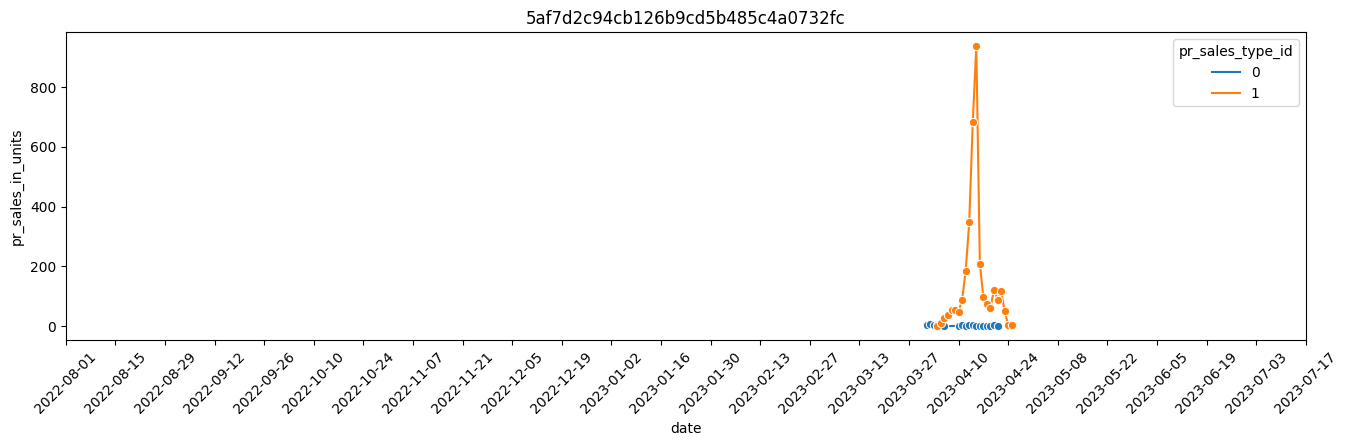

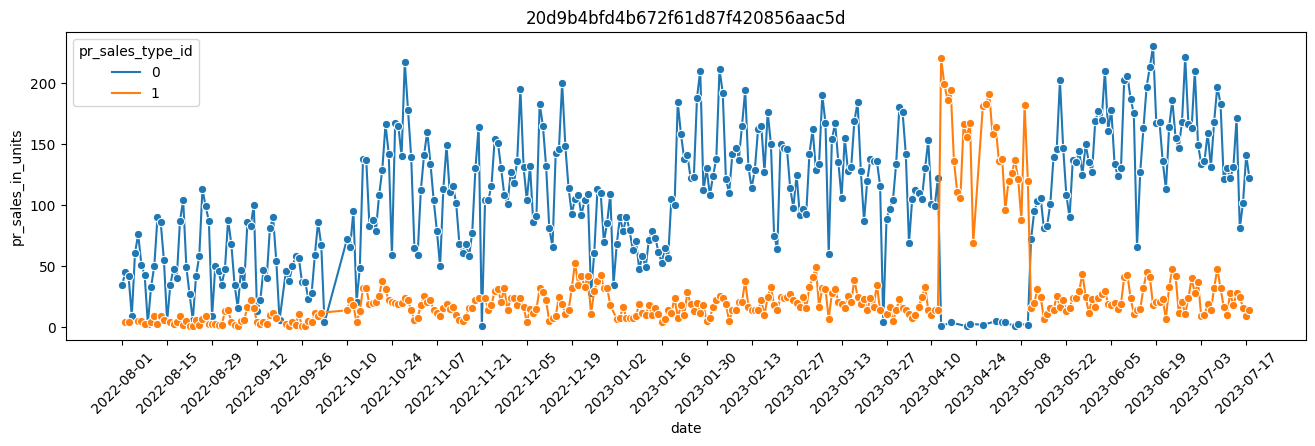

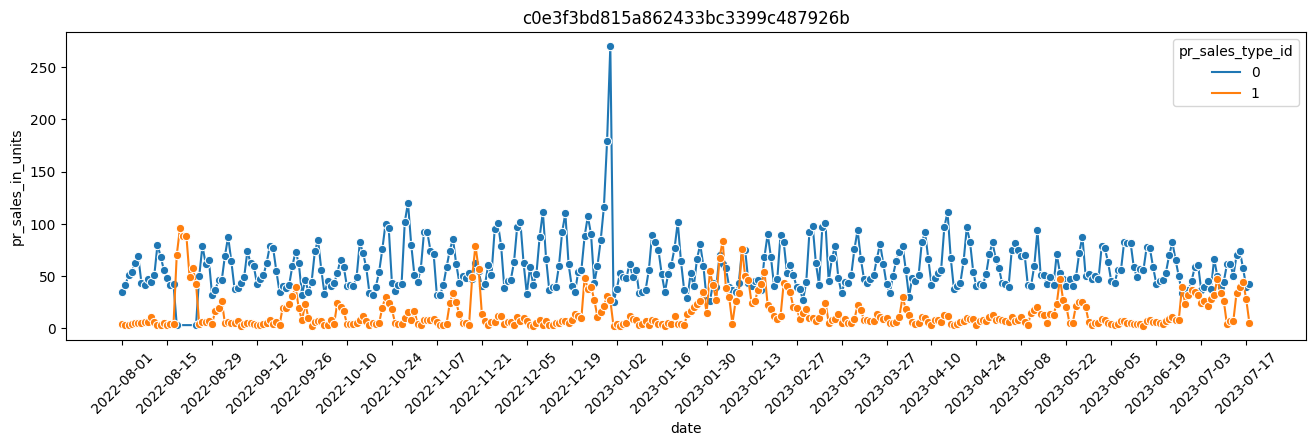

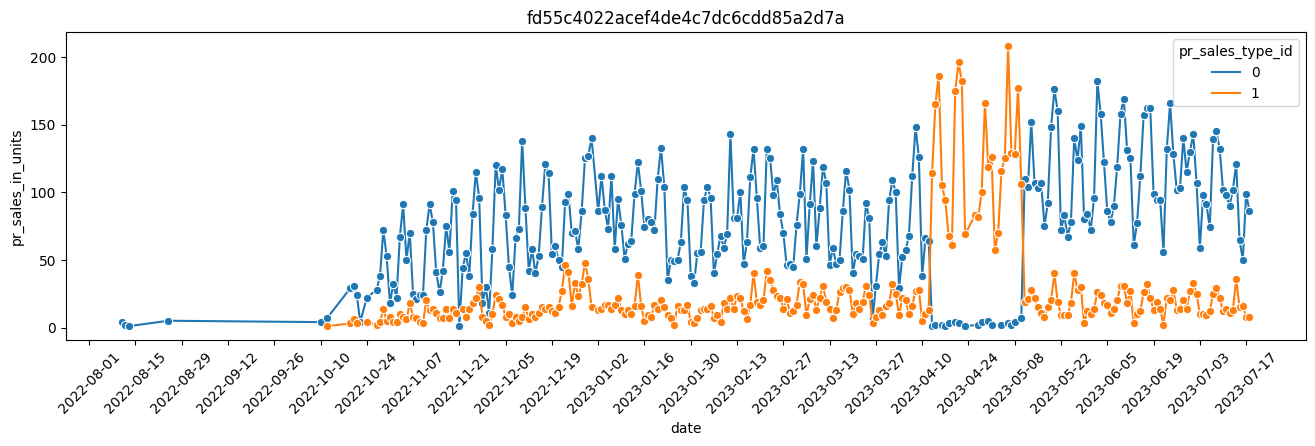

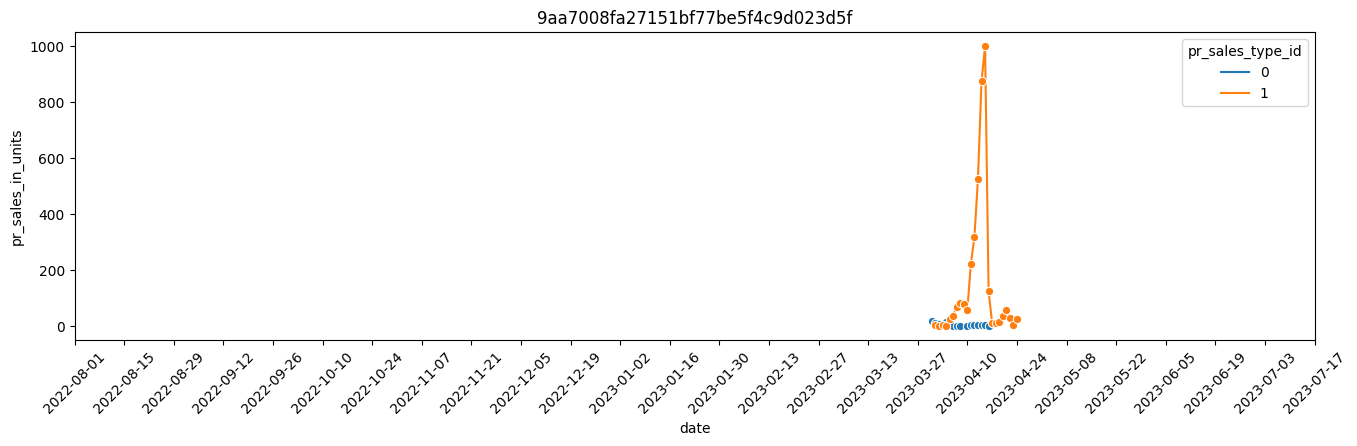

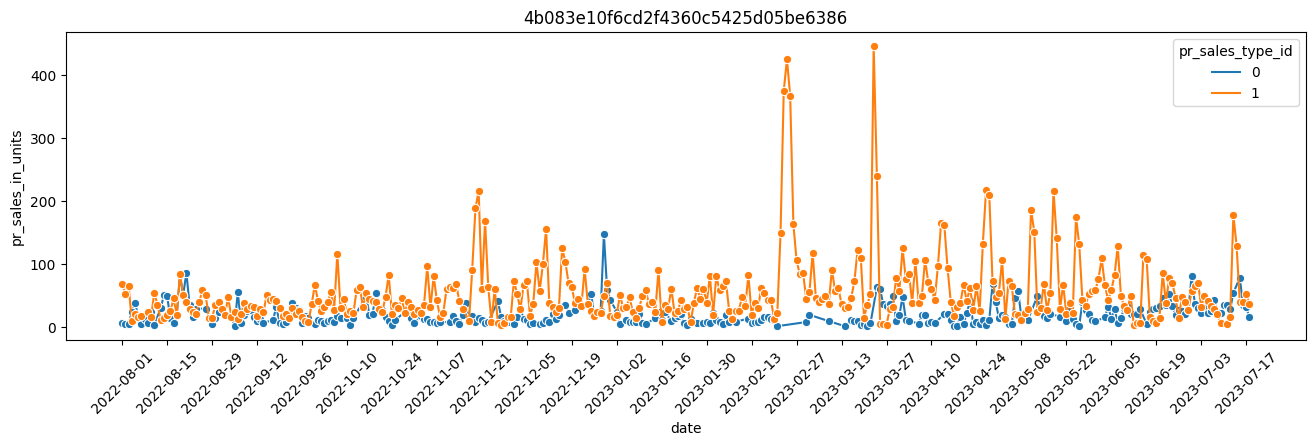

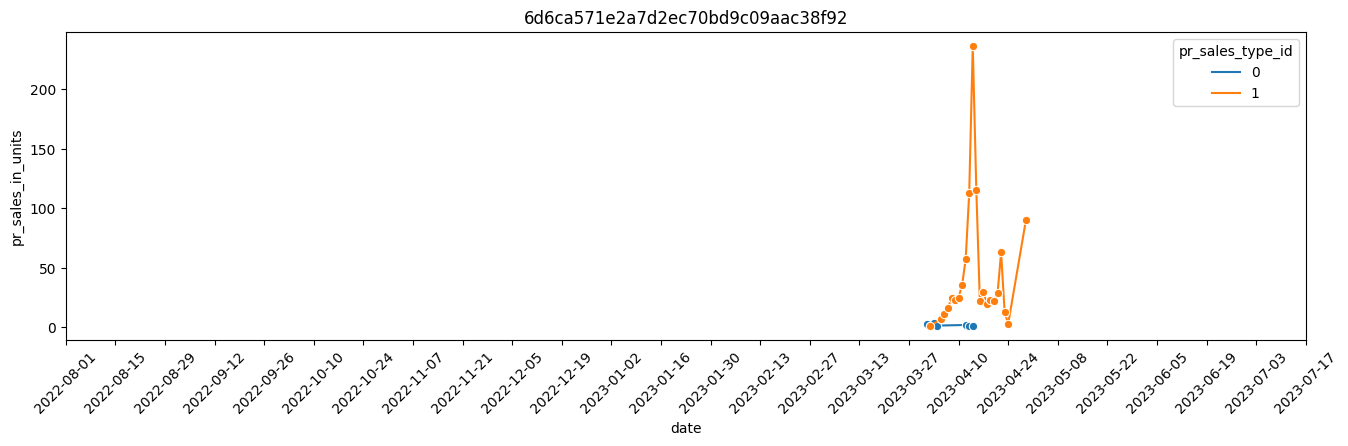

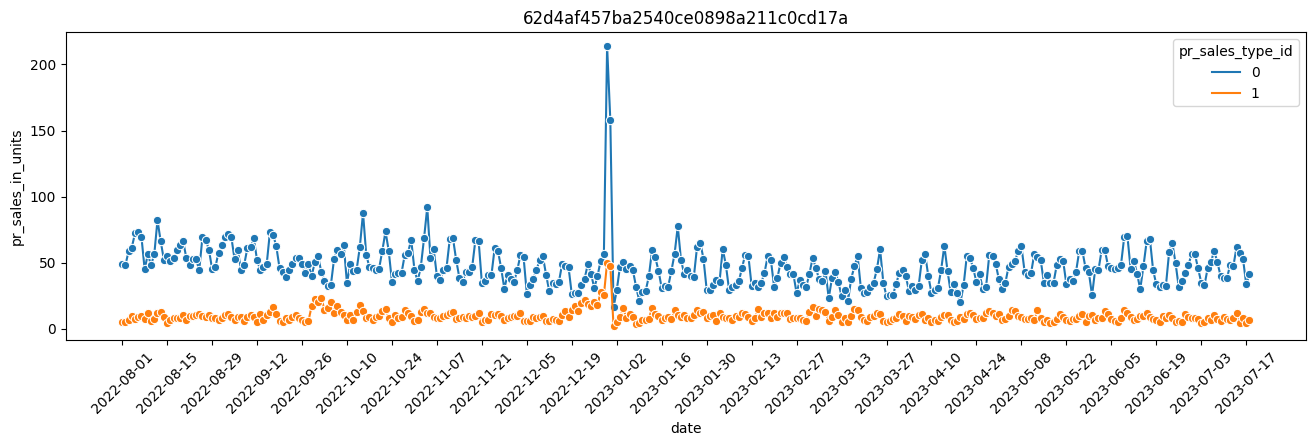

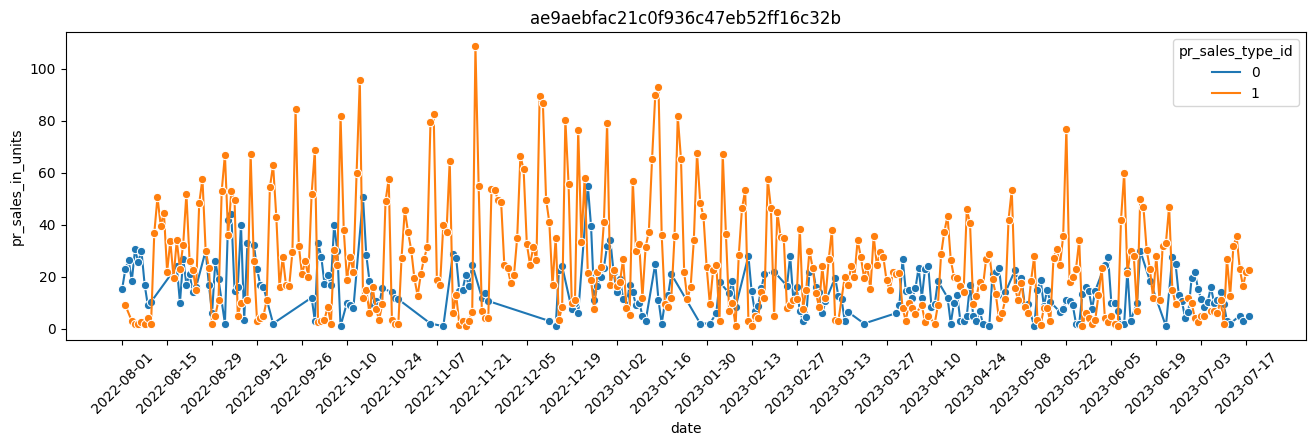

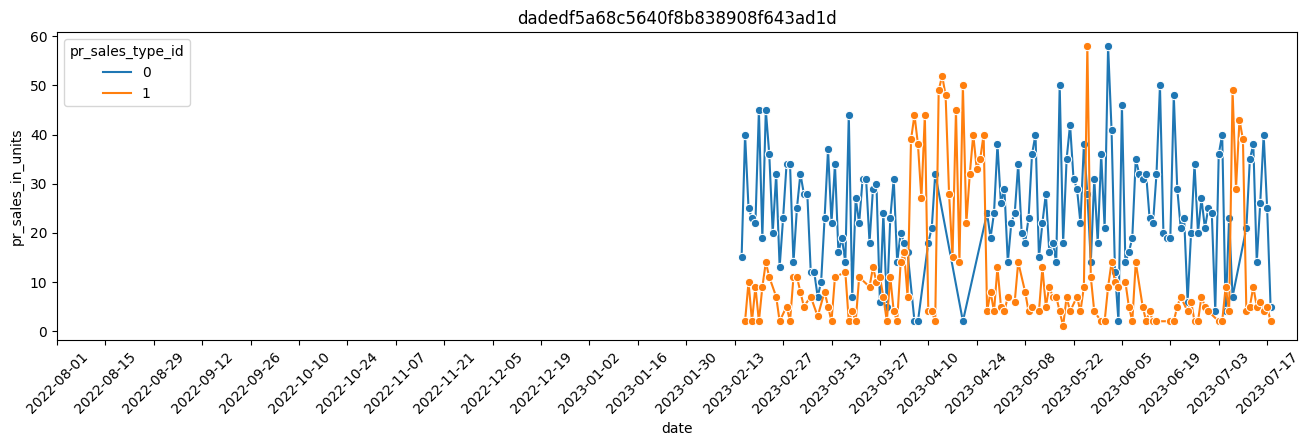

In [33]:
# временные ряды для 10 продуктов, которые в среднем (медина) продаются больше всего
for idx in top_10.index:
    plt.figure(figsize=(16,4))
    sns.lineplot(data=df[(df['pr_sku_id']==idx)], x='date', y='pr_sales_in_units', hue='pr_sales_type_id', 
                                                 marker='o', ci=None)
    plt.xticks(np.arange(df['date'].min(), df['date'].max(), timedelta(days=14)), rotation=45)
    plt.title(idx)
    plt.show()

- Есть специализированные продукты, которые продавались в очень большом количестве только в период Пасхи 
- Есть продукты, которые продавались не весь исследуемый период
- Товар мог параллельно продаваться по промо и без в одном магазине (ранее рассматривали)

### Корреляционный анализ

In [34]:
# тепловая карта коффициентов корреляции 
# фи - показывает также нелинейные зависимости для всех признаков
def corr_heatmap(corr_matrix):
    """Функция для построения тепловой карты коэффициентов корреляции.
       На вход принимает матрицу корреляций"""
    # маска для отображения нижнего треугольника
    matrix_mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    # тепловая карта
    sns.heatmap(abs(corr_matrix), annot=True, cmap='GnBu', fmt=".2f", vmin=0, vmax=1,mask=matrix_mask)
    plt.title('Матрица коэффициентов корреляции')
    None

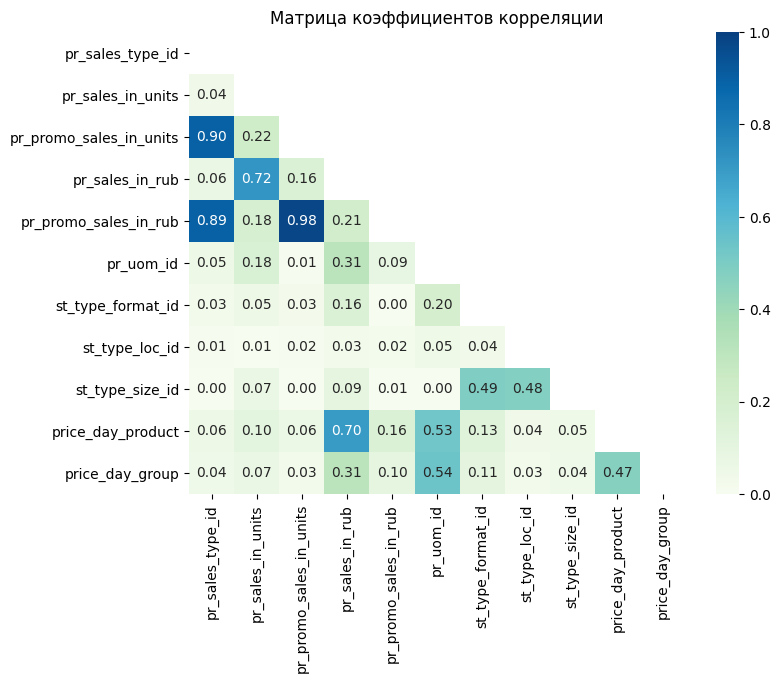

In [35]:
# коэффициент корреляции Спирмена для численных признаков
spearman_corr_matrix = df.corr(method='spearman', numeric_only=True)
plt.figure(figsize=(8, 6))
corr_heatmap(spearman_corr_matrix)


- Линейные зависимости целевого признака `pr_sales_in_units` закономерно с выручкой  (pr_promo_sales_in_units и pr_promo_sales_in_rub - дублируются значения для промоакционных продаж)

- Размер магазина `st_type_size_id` и формат магазина `st_type_format_id`

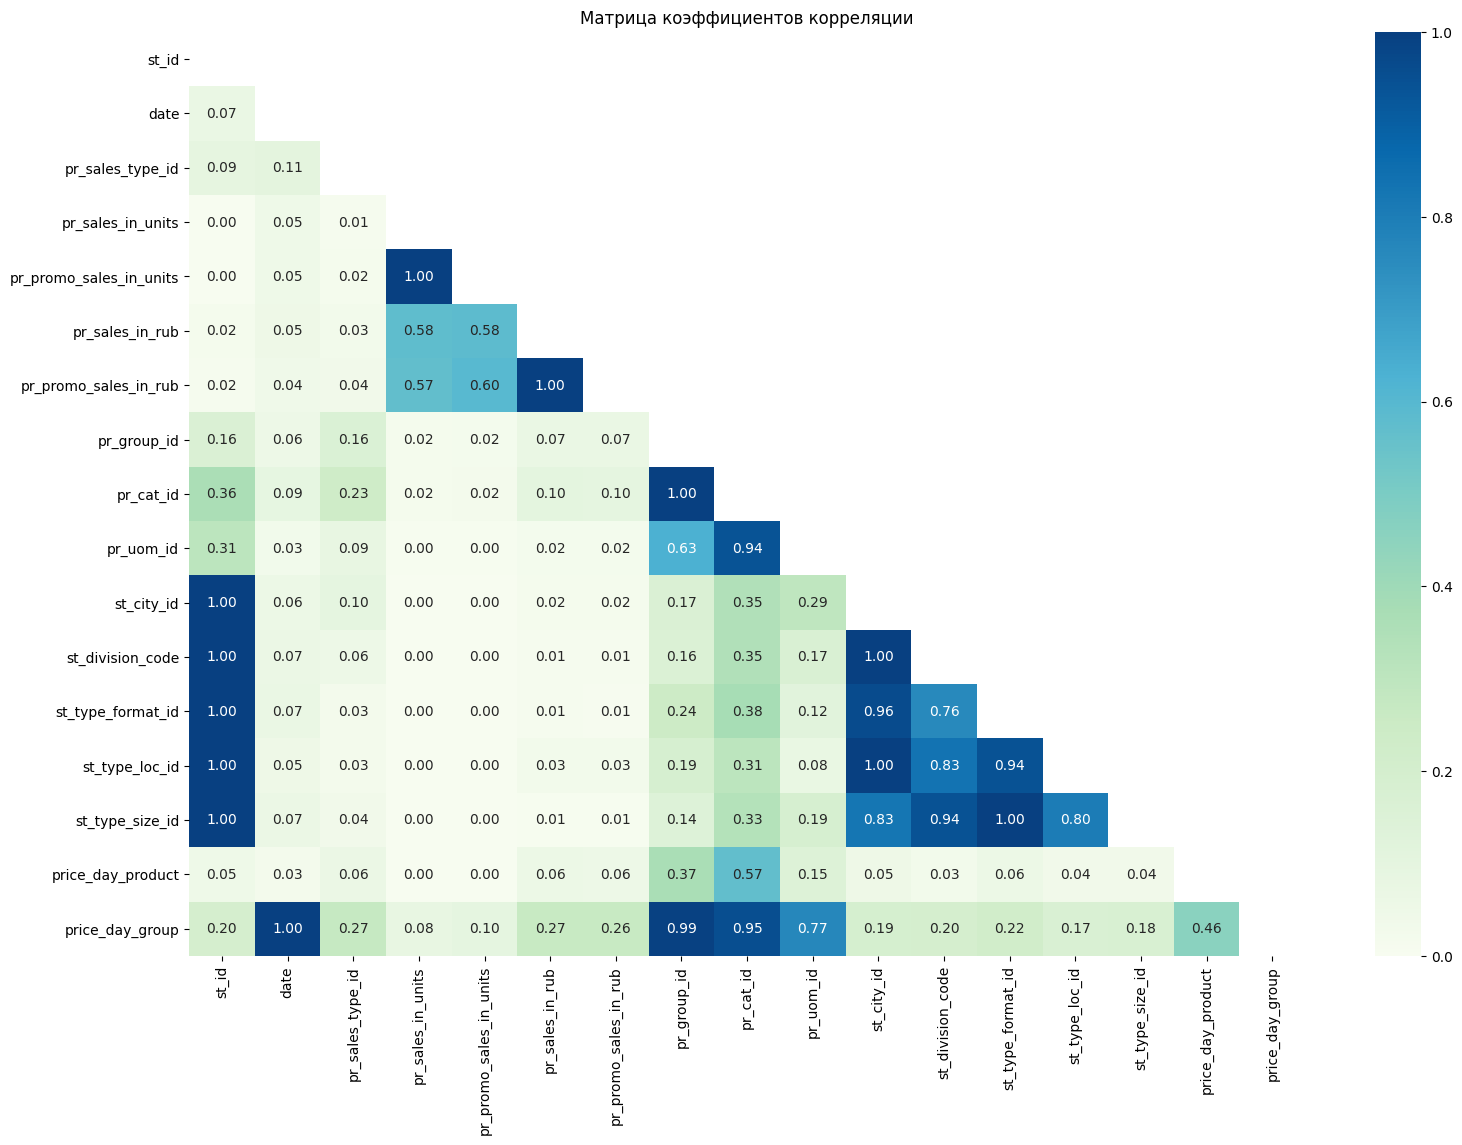

In [36]:
# коэффициенты корреляции фи - показывает также нелинейные зависимости для всех признаков
phi_matrix = df.drop(['pr_sku_id', 'pr_subcat_id'], axis=1).phik_matrix(interval_cols=['pr_sales_in_units', 
                    'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub', 'price_day_product',
                    'price_day_product'])

plt.figure(figsize=(18, 12))
corr_heatmap(phi_matrix)

Корреляция, включая нелинейные зависимости:
- `pr_uom_id` (маркер, обозначающий продаётся товар на вес или в ШТ) и `pr_cat_id` (захэшированная категория товара) и `pr_group_id` (захэшированная группа товара)
- характеристики магазина: город, дивизион, формат, окружение, размер


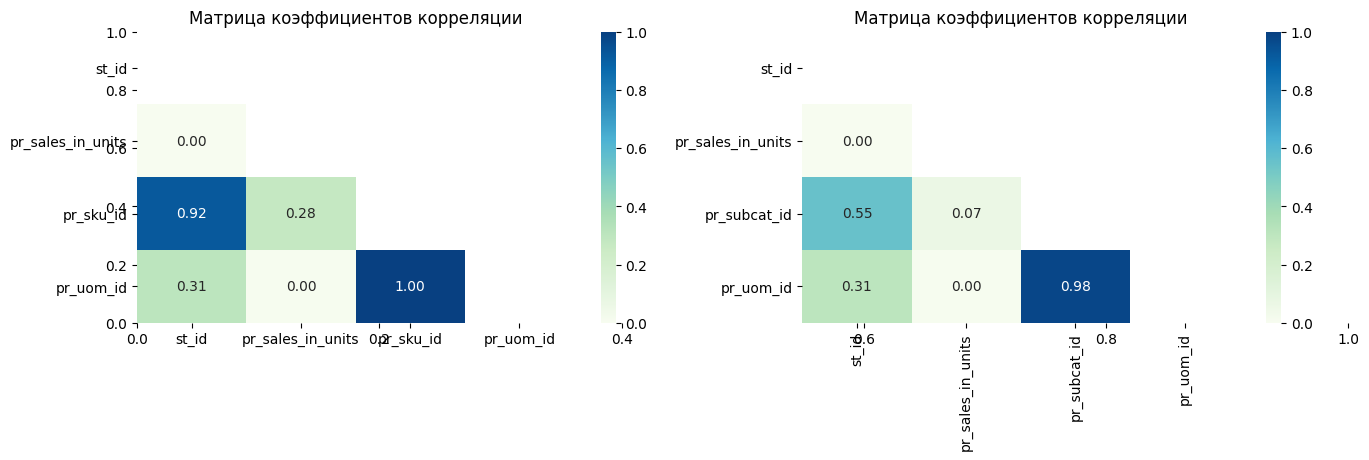

In [37]:
# отдельно проверим, так как для одной матрицы 
# спрос-sku товара
fig, axs = plt.subplots(figsize=(14, 5))
axs.set_frame_on(False) # убрать рамкуу
fig.add_subplot(121)
phi_matrix_2 =  df[['st_id', 'pr_sales_in_units', 'pr_sku_id', 'pr_uom_id']]\
                                                .phik_matrix(interval_cols=['pr_sales_in_units'])
corr_heatmap(phi_matrix_2)
# спрос-подкатегории товара
fig.add_subplot(122)
phi_matrix_3 = df[['st_id', 'pr_sales_in_units', 'pr_subcat_id', 'pr_uom_id']]\
                                                .phik_matrix(interval_cols=['pr_sales_in_units'])
corr_heatmap(phi_matrix_3)
plt.tight_layout()

- Коррелируют sku товаров и id магазинов, скорее всего связано с ограниченными и отличающимися ассортиментами магазинов

Никаких неочевидных зависимостей не выявили

### Ассортимент магазинов

In [38]:
def count_uniq(data_stores):
    return len(data_stores.unique())

# ассортимент каждого магазина
comb_id_df = pd.DataFrame(df.groupby('st_id')['pr_sku_id'], columns=['st_id', 'sku_list'])
comb_id_df['unigue_sku'] = comb_id_df['sku_list'].apply(lambda x: count_uniq(x) )

# присоединим датасет с инфо о магазинах
comb_id_df = comb_id_df.merge(data_stores, on='st_id', how='left')

comb_id_df[['st_id', 'unigue_sku', 'st_type_format_id']]

st_id  unigue_sku  st_type_format_id
0  084a8a9aa8cced9175bd07bc44998e75           6                  4
1  16a5cdae362b8d27a1d8f8c7b78b4330         961                  1
2  1ecfb463472ec9115b10c292ef8bc986         251                  2
3  42a0e188f5033bc65bf8d78622277c4e        1029                  1
4  53e19f3dbb211f20b20b45668303c1b6         111                  4
5  6364d3f0f495b6ab9dcf8d3b5c6e0b01         907                  1
6  bd470ca955d9497bbcb808e59952fffc          85                  4
7  c81e728d9d4c2f636f067f89cc14862c        1085                  1
8  f7e6c85504ce6e82442c770f7c8606f0         949                  1
9  fa7cdfad1a5aaf8370ebeda47a1ff1c3         819                  1

Во всех магазинах разный ассортимент товаров. Для формата магазин `1` характерен самый большой ассортимен около ~800-1000 товаров. Чем больше значение формата, тем меньше ассортимент

### Сравнительный анализ по группам признаков
Попробуем разбить данные по категориям и оценить поведение спроса по каждой выборке

In [39]:
# уникальные значения в признаках
feature_unique(df)

--------------------------------------------------
Количество уникальных значений --- st_id --- : 10


count  Percentage
st_id                                               
c81e728d9d4c2f636f067f89cc14862c  174687       19.80
16a5cdae362b8d27a1d8f8c7b78b4330  157542       17.86
42a0e188f5033bc65bf8d78622277c4e  140286       15.90
f7e6c85504ce6e82442c770f7c8606f0  124145       14.07
6364d3f0f495b6ab9dcf8d3b5c6e0b01  115830       13.13
fa7cdfad1a5aaf8370ebeda47a1ff1c3  110537       12.53
1ecfb463472ec9115b10c292ef8bc986   47404        5.37
53e19f3dbb211f20b20b45668303c1b6    9231        1.05
bd470ca955d9497bbcb808e59952fffc    2586        0.29
084a8a9aa8cced9175bd07bc44998e75      38        0.00

--------------------------------------------------
Количество уникальных значений --- pr_sku_id --- : 1991


count  Percentage
pr_sku_id                                          
62d4af457ba2540ce0898a211c0cd17a   4389        0.50
ced0c1a84924c982a6403870c54b99ca   4349        0.49
cf91eca9321c9c272fb4e7cf4bcc6a43   4200        0.48
5b26f85ccb23039364226f66f0366c66   3944        0.45
6b1344097385a42484abd4746371e416   3877        0.44
...                                 ...         ...
ad6036c4fbe4b1c164e766c35083cd2b      1        0.00
c70928a84fad506a274e63a2f367476b      1        0.00
6058d6b7d1f04803d15d1896d3256c92      1        0.00
57e82787ed765d35b35a286918e7fb71      1        0.00
8878e97692da06941dedcf44c1f50668      1        0.00

[1991 rows x 2 columns]

--------------------------------------------------
Количество уникальных значений --- date --- : 352


count  Percentage
date                         
2022-12-30   3396        0.38
2022-12-29   3322        0.38
2022-12-24   3233        0.37
2022-12-28   3126        0.35
2023-06-23   3033        0.34
...           ...         ...
2023-01-03   2083        0.24
2023-04-17   2070        0.23
2023-01-09   2041        0.23
2023-01-02   1950        0.22
2023-01-01   1182        0.13

[352 rows x 2 columns]

--------------------------------------------------
Количество уникальных значений --- pr_sales_type_id --- : 2


count  Percentage
pr_sales_type_id                    
0                 523555       59.34
1                 358731       40.66

--------------------------------------------------
Количество уникальных значений --- pr_sales_in_units --- : 379


count  Percentage
pr_sales_in_units                    
1.0                266929       30.25
2.0                157780       17.88
3.0                 92795       10.52
4.0                 82934        9.40
0.0                 67405        7.64
...                   ...         ...
868.0                   1        0.00
518.0                   1        0.00
261.0                   1        0.00
960.0                   1        0.00
360.0                   1        0.00

[379 rows x 2 columns]

--------------------------------------------------
Количество уникальных значений --- pr_promo_sales_in_units --- : 348


count  Percentage
pr_promo_sales_in_units                    
0.0                      555520       62.96
1.0                      117694       13.34
2.0                       60302        6.83
3.0                       32903        3.73
4.0                       27686        3.14
...                         ...         ...
1271.0                        1        0.00
440.0                         1        0.00
248.0                         1        0.00
338.0                         1        0.00
360.0                         1        0.00

[348 rows x 2 columns]

--------------------------------------------------
Количество уникальных значений --- pr_sales_in_rub --- : 12237


count  Percentage
pr_sales_in_rub                   
0.0              67405        7.64
65.0              5686        0.64
98.0              5549        0.63
74.0              4860        0.55
82.0              4813        0.55
...                ...         ...
22611.0              1        0.00
10089.0              1        0.00
17510.0              1        0.00
9069.0               1        0.00
12484.0              1        0.00

[12237 rows x 2 columns]

--------------------------------------------------
Количество уникальных значений --- pr_promo_sales_in_rub --- : 10838


count  Percentage
pr_promo_sales_in_rub                    
0.0                    555520       62.96
39.0                     2145        0.24
70.0                     2126        0.24
62.0                     2050        0.23
37.0                     1818        0.21
...                       ...         ...
11757.0                     1        0.00
9719.0                      1        0.00
111397.0                    1        0.00
7775.0                      1        0.00
12484.0                     1        0.00

[10838 rows x 2 columns]

--------------------------------------------------
Количество уникальных значений --- pr_group_id --- : 9


count  Percentage
pr_group_id                                         
c74d97b01eae257e44aa9d5bade97baf  386423       43.80
aab3238922bcc25a6f606eb525ffdc56  300568       34.07
6512bd43d9caa6e02c990b0a82652dca   93186       10.56
c51ce410c124a10e0db5e4b97fc2af39   51080        5.79
c20ad4d76fe97759aa27a0c99bff6710   36176        4.10
32bb90e8976aab5298d5da10fe66f21d    8669        0.98
1ff1de774005f8da13f42943881c655f    5910        0.67
98f13708210194c475687be6106a3b84     263        0.03
3c59dc048e8850243be8079a5c74d079      11        0.00

--------------------------------------------------
Количество уникальных значений --- pr_cat_id --- : 43


count  Percentage
pr_cat_id                                           
c559da2ba967eb820766939a658022c8  172949       19.60
1bc0249a6412ef49b07fe6f62e6dc8de  104958       11.90
9701a1c165dd9420816bfec5edd6c2b1  103037       11.68
28fc2782ea7ef51c1104ccf7b9bea13d  102847       11.66
f3173935ed8ac4bf073c1bcd63171f8a   52029        5.90
e58cc5ca94270acaceed13bc82dfedf7   47289        5.36
fb2fcd534b0ff3bbed73cc51df620323   36161        4.10
3de2334a314a7a72721f1f74a6cb4cee   33391        3.78
a368b0de8b91cfb3f91892fbf1ebd4b2   32884        3.73
186a157b2992e7daed3677ce8e9fe40f   21565        2.44
c9f95a0a5af052bffce5c89917335f67   19064        2.16
b59c67bf196a4758191e42f76670ceba   18837        2.14
46771d1f432b42343f56f791422a4991   16133        1.83
6d9c547cf146054a5a720606a7694467   15169        1.72
5caf41d62364d5b41a893adc1a9dd5d4   15155        1.72
535ab76633d94208236a2e829ea6d888   14660        1.66
fd5c905bcd8c3348ad1b35d7231ee2b1   12373        1.40
f18a6d1cde4b205199de8729a6637b42    8730        0.99
faafda66202d234463057972460c04f5    8495        0.96
2df45244f09369e16ea3f9117ca45157    7382        0.84
b7087c1f4f89e63af8d46f3b20271153    6745        0.76
a6ea8471c120fe8cc35a2954c9b9c595    5910        0.67
f9ab16852d455ce9203da64f4fc7f92d    5755        0.65
20d135f0f28185b84a4cf7aa51f29500    5721        0.65
7a6a74cbe87bc60030a4bd041dd47b78    5065        0.57
b9d487a30398d42ecff55c228ed5652b    1669        0.19
4edaa105d5f53590338791951e38c3ad    1614        0.18
118921efba23fc329e6560b27861f0c2    1569        0.18
f862d13454fd267baa5fedfffb200567    1345        0.15
a14ac55a4f27472c5d894ec1c3c743d2     957        0.11
2cbca44843a864533ec05b321ae1f9d1     606        0.07
d282ef263719ab842e05382dc235f69e     507        0.06
f93882cbd8fc7fb794c1011d63be6fb6     470        0.05
a0872cc5b5ca4cc25076f3d868e1bdf8     369        0.04
495dabfd0ca768a3c3abd672079f48b6     322        0.04
ea5a486c712a91e48443cd802642223d     256        0.03
7940ab47468396569a906f75ff3f20ef      86        0.01
996009f2374006606f4c0b0fda878af1      78        0.01
7b5b23f4aadf9513306bcd59afb6e4c9      67        0.01
a2cc63e065705fe938a4dda49092966f      34        0.00
b571ecea16a9824023ee1af16897a582      15        0.00
e7e23670481ac78b3c4122a99ba60573      11        0.00
d47268e9db2e9aa3827bba3afb7ff94a       7        0.00

--------------------------------------------------
Количество уникальных значений --- pr_subcat_id --- : 167


count  Percentage
pr_subcat_id                                       
e06f5ed77191826c212c30722f2cc5a2  39032        4.42
7a8aebb07d6e8ba9da453ec0f3f359a4  27225        3.09
ca34f669ae367c87f0e75dcae0f61ee5  26147        2.96
c01c475ac8d447730ece97d846cc4f25  25986        2.95
0f3abfd67959c079e7b3759440e7415c  23450        2.66
...                                 ...         ...
0aac5ea0d2a927322dd4c09ef37c0be0      4        0.00
712807f1f137cdd746d746828b2090b1      4        0.00
ce08fca7bb075a8acc942e3f575346b0      2        0.00
16d222a5fac9d8d7a3ee790f9ee46af5      2        0.00
a4244e0fd6c2493b1393823d1abaec5b      1        0.00

[167 rows x 2 columns]

--------------------------------------------------
Количество уникальных значений --- pr_uom_id --- : 2


count  Percentage
pr_uom_id                    
1          565565        64.1
17         316721        35.9

--------------------------------------------------
Количество уникальных значений --- st_city_id --- : 6


count  Percentage
st_city_id                                          
b8b4b727d6f5d1b61fff7be687f7970f  256116       29.03
908c9a564a86426585b29f5335b619bc  222091       25.17
c1f75cc0f7fe269dd0fd9bd5e24f9586  157542       17.86
3202111cf90e7c816a472aaceb72b0df  124183       14.08
885fe656777008c335ac96072a45be15  110537       12.53
955d864a62659945cc9434898e275deb   11817        1.34

--------------------------------------------------
Количество уникальных значений --- st_division_code --- : 5


count  Percentage
st_division_code                                    
296bd0cc6e735f9d7488ebc8fbc19130  268079       30.38
da742b3cfca5388aaf9af28a726a3c30  256116       29.03
429a86ff6336c144ddaf6144f52ab52c  222091       25.17
32586311f16876abf92901085bd87b99  124183       14.08
e26072c92d8fe0738df44d571d5f5e8b   11817        1.34

--------------------------------------------------
Количество уникальных значений --- st_type_format_id --- : 3


count  Percentage
st_type_format_id                    
1                  823027       93.28
2                   47404        5.37
4                   11855        1.34

--------------------------------------------------
Количество уникальных значений --- st_type_loc_id --- : 3


count  Percentage
st_type_loc_id                    
1               712889       80.80
2               157542       17.86
3                11855        1.34

--------------------------------------------------
Количество уникальных значений --- st_type_size_id --- : 5


count  Percentage
st_type_size_id                    
12               490798       55.63
8                332229       37.66
28                47404        5.37
20                 9231        1.05
19                 2624        0.30

--------------------------------------------------
Количество уникальных значений --- price_day_product --- : 8768


count  Percentage
price_day_product                   
0.0                67405        7.64
41.0                8452        0.96
45.0                5953        0.67
49.0                4272        0.48
33.0                3808        0.43
...                  ...         ...
787.2                  1        0.00
782.4                  1        0.00
795.7                  1        0.00
1411.0                 1        0.00
1284.0                 1        0.00

[8768 rows x 2 columns]

--------------------------------------------------
Количество уникальных значений --- price_day_group --- : 1550


count  Percentage
price_day_group                   
50.2             11927        1.35
48.9             10595        1.20
50.3             10327        1.17
50.7              9808        1.11
50.4              9635        1.09
...                ...         ...
86.0                 1        0.00
129.0                1        0.00
0.0                  1        0.00
57.1                 1        0.00
78.7                 1        0.00

[1550 rows x 2 columns]

Отметим, что в исторических данных:
- 352 уникальные даты
- представлены не все SKU товаров (1991 из 2050)
- представлены не все подкатегории товаров (167 из 170)
- продажы распределены неправномерно по магазинам, по группам и категориям товаров

Посмотрим:
- Подробно продажи по промо и без
- Весовые и штучные товары
- 9 групп товаров, 43 категории товара
- 12 магазинов, 7 городов, 6 дивизионов, 6 типов размера магазина, 3 типа окружения, 3 формата

#### Продажи по промо и без
40,6% записей в данных относятся к продажам по промо

In [41]:
# разделим на 2 выборки по признаку промо
promo_df = df[df['pr_sales_type_id']==1]
nopromo_df = df[df['pr_sales_type_id']==0]

In [42]:
# описательная статистика для двух выборок
for df_temp in [promo_df, nopromo_df]:
    display(df_temp.describe().T)

count                           mean   
date                       358731  2023-01-26 22:13:50.507539200  \
pr_sales_type_id         358731.0                            1.0   
pr_sales_in_units        358731.0                       5.478869   
pr_promo_sales_in_units  358731.0                       5.478869   
pr_sales_in_rub          358731.0                     719.184921   
pr_promo_sales_in_rub    358731.0                     719.184921   
pr_uom_id                358731.0                       6.236191   
st_type_format_id        358731.0                       1.114158   
st_type_loc_id           358731.0                       1.204685   
st_type_size_id          358731.0                      11.544068   
price_day_product        358731.0                     122.551594   
price_day_group          358731.0                     129.457565   

                                         min                  25%   
date                     2022-08-01 00:00:00  2022-11-02 00:00:00  \
pr_sales_type_id                         1.0                  1.0   
pr_sales_in_units                        0.0                  1.0   
pr_promo_sales_in_units                  0.0                  1.0   
pr_sales_in_rub                          0.0                 69.0   
pr_promo_sales_in_rub                    0.0                 69.0   
pr_uom_id                                1.0                  1.0   
st_type_format_id                        1.0                  1.0   
st_type_loc_id                           1.0                  1.0   
st_type_size_id                          8.0                  8.0   
price_day_product                        0.0                 36.7   
price_day_group                         42.4                 51.2   

                                         50%                  75%   
date                     2023-01-29 00:00:00  2023-04-23 00:00:00  \
pr_sales_type_id                         1.0                  1.0   
pr_sales_in_units                        2.0                  4.0   
pr_promo_sales_in_units                  2.0                  4.0   
pr_sales_in_rub                        189.0                562.0   
pr_promo_sales_in_rub                  189.0                562.0   
pr_uom_id                                1.0                 17.0   
st_type_format_id                        1.0                  1.0   
st_type_loc_id                           1.0                  1.0   
st_type_size_id                         12.0                 12.0   
price_day_product                       97.0                166.0   
price_day_group                        144.4                162.2   

                                         max          std  
date                     2023-07-18 00:00:00          NaN  
pr_sales_type_id                         1.0          0.0  
pr_sales_in_units                     2348.0    16.833027  
pr_promo_sales_in_units               2348.0    16.833027  
pr_sales_in_rub                     183265.0  2130.594359  
pr_promo_sales_in_rub               183265.0  2130.594359  
pr_uom_id                               17.0     7.507431  
st_type_format_id                        4.0     0.462917  
st_type_loc_id                           3.0     0.447785  
st_type_size_id                         28.0     4.664818  
price_day_product                     2029.0   127.547117  
price_day_group                        478.6    84.259996

count                           mean   
date                       523555  2023-01-25 04:45:15.469434880  \
pr_sales_type_id         523555.0                            0.0   
pr_sales_in_units        523555.0                       4.732225   
pr_promo_sales_in_units  523555.0                            0.0   
pr_sales_in_rub          523555.0                     503.511683   
pr_promo_sales_in_rub    523555.0                            0.0   
pr_uom_id                523555.0                       7.091341   
st_type_format_id        523555.0                       1.080253   
st_type_loc_id           523555.0                       1.205948   
st_type_size_id          523555.0                      11.398957   
price_day_product        523555.0                     132.296088   
price_day_group          523555.0                     117.124153   

                                         min                  25%   
date                     2022-08-01 00:00:00  2022-10-28 00:00:00  \
pr_sales_type_id                         0.0                  0.0   
pr_sales_in_units                        0.0                  1.0   
pr_promo_sales_in_units                  0.0                  0.0   
pr_sales_in_rub                          0.0                109.0   
pr_promo_sales_in_rub                    0.0                  0.0   
pr_uom_id                                1.0                  1.0   
st_type_format_id                        1.0                  1.0   
st_type_loc_id                           1.0                  1.0   
st_type_size_id                          8.0                  8.0   
price_day_product                        0.0                 41.8   
price_day_group                          0.0                 50.6   

                                         50%                  75%   
date                     2023-01-25 00:00:00  2023-04-27 00:00:00  \
pr_sales_type_id                         0.0                  0.0   
pr_sales_in_units                        2.0                  4.0   
pr_promo_sales_in_units                  0.0                  0.0   
pr_sales_in_rub                        243.0                530.0   
pr_promo_sales_in_rub                    0.0                  0.0   
pr_uom_id                                1.0                 17.0   
st_type_format_id                        1.0                  1.0   
st_type_loc_id                           1.0                  1.0   
st_type_size_id                         12.0                 12.0   
price_day_product                      107.0                189.0   
price_day_group                        141.2                161.2   

                                         max          std  
date                     2023-07-18 00:00:00          NaN  
pr_sales_type_id                         0.0          0.0  
pr_sales_in_units                     1033.0    10.418794  
pr_promo_sales_in_units                  0.0          0.0  
pr_sales_in_rub                     169379.0  1037.895502  
pr_promo_sales_in_rub                    0.0          0.0  
pr_uom_id                               17.0     7.768986  
st_type_format_id                        4.0     0.363502  
st_type_loc_id                           3.0     0.427754  
st_type_size_id                         28.0     4.392306  
price_day_product                     4729.0   127.515104  
price_day_group                        478.6    73.242085


Проверим гипотезу: *средний спрос `pr_sales_type_id` с промо  и без различается*.  
```
H_0: среднее значение `pr_sales_type_id` для продаж без флага промо = среднее значение `pr_sales_type_id` для продаж с флагом промо`
H_a:  среднее значение `pr_sales_type_id` для продаж с флагом промо и без не равны 
Уровень значимости alpha = 0.05
```

In [43]:
promo = promo_df.set_index('date')['pr_sales_in_units']
nopromo = nopromo_df.set_index('date')['pr_sales_in_units']

# вызов метода для проверки двухсторонней гипотезы
results = st.ttest_ind(promo, nopromo, equal_var=False)
# уровень значимости
alpha = 0.05
# p-value  
print(results.pvalue)

# ответ
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

1.5700415789285102e-123
Отвергаем нулевую гипотезу


Получили статистически значимые основания считать, что средний спрос всех товаров за день по промо и без промо отдичается

In [44]:
def category_ts_agg_plot(feature):
    """Функция для построения сравнительных графиков усреднённого временнного ряда выборок, полученных разбиением датасета по признаку.
       На вход принимает значение признака в строковом типе данных.
       На выходе сравнительные графики временного ряда с усреднёнными значениями по дню для каждой категории признака"""
    def ts_agg_plot(dic_df):
        """Функция группирует целевой признак в датасете по дате и строит графикисравнительные """
        plt.figure(figsize=(15, 5))
        for name, df_temp in dic_df.items():
            df_agg = df_temp.groupby('date')['pr_sales_in_units'].agg('mean')
            plt.plot(df_agg.index, df_agg.values,  linewidth=1.8, alpha=0.8, label=name)

        plt.xlabel('Дата')
        plt.ylabel('Суммарные продажи в день, ед.')
        plt.title(f'Сравнение продаж по признаку {feature}')
        plt.legend()
        plt.show()
    
    dic_df = {}
    for feature_value in df[feature].unique():       
        feature_value_df = df[df[feature]==feature_value]
        dic_df[feature_value] = feature_value_df
    # график временного ряда 
    ts_agg_plot(dic_df)
    
    # боксплоты
    fig, axs = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [1.5, 1]})
    sns.boxplot(data=df, y=feature, x='pr_sales_in_units', orient='h', ax=axs[0]).set_xlim(0, 20)
    sns.boxplot(data=df, y=feature, x='pr_sales_in_units', orient='h', ax=axs[1]).set_yticklabels([])


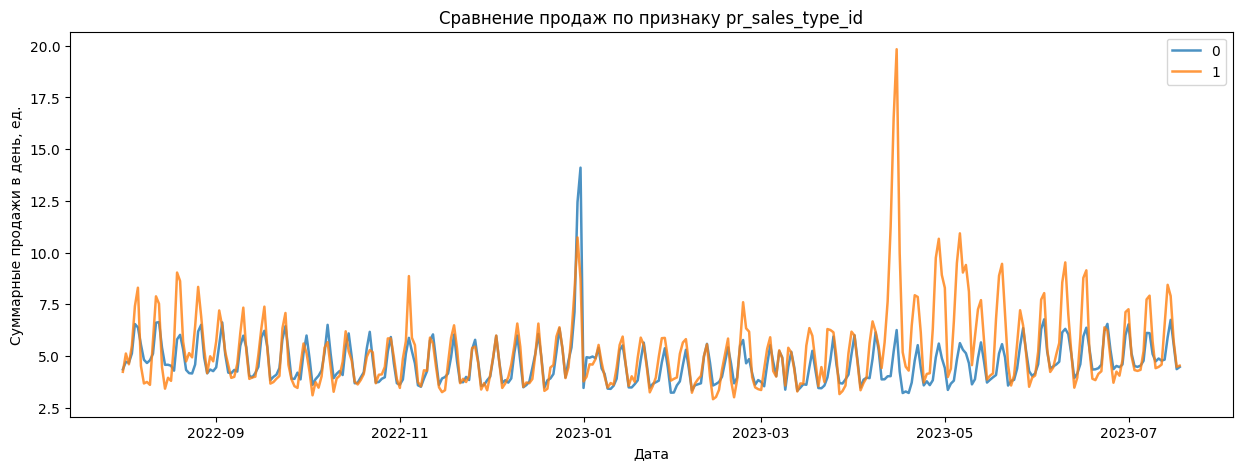

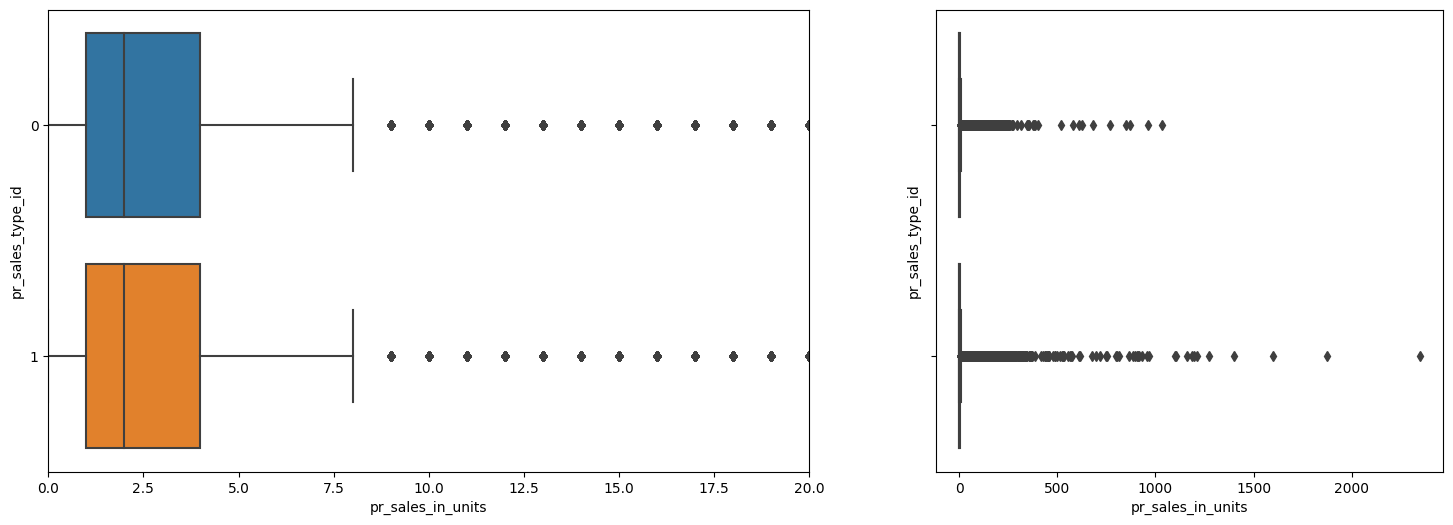

In [45]:
category_ts_agg_plot('pr_sales_type_id')

-Промо `pr_sales_type_id`: 
- в зимний сезон одинаковый спрос на товары по промо и без, 
- в летний спросна промо выше, в период вторая половина апреля- май спрос на промо выше в 2-3 раза


#### По единице измерения: весовой или штучный

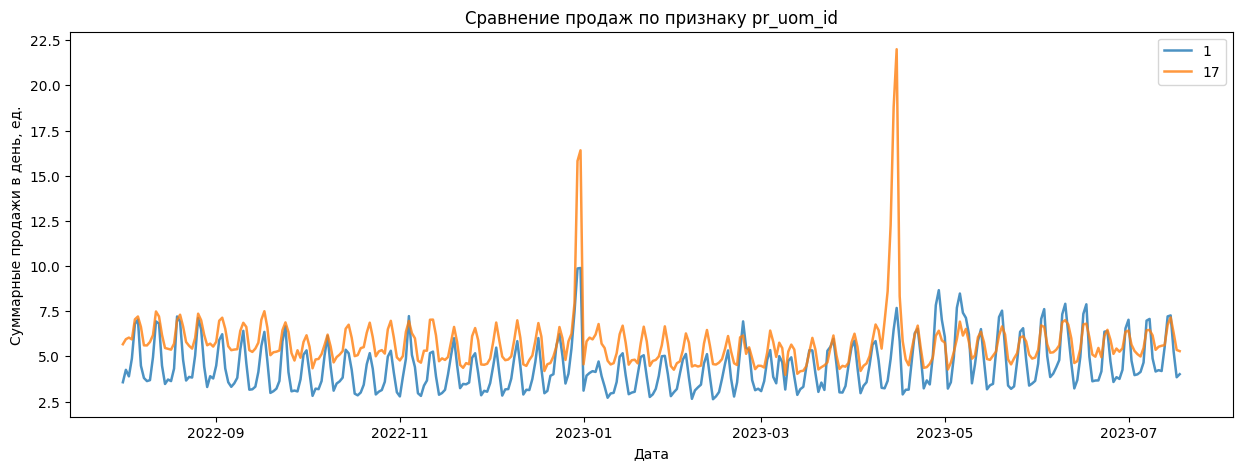

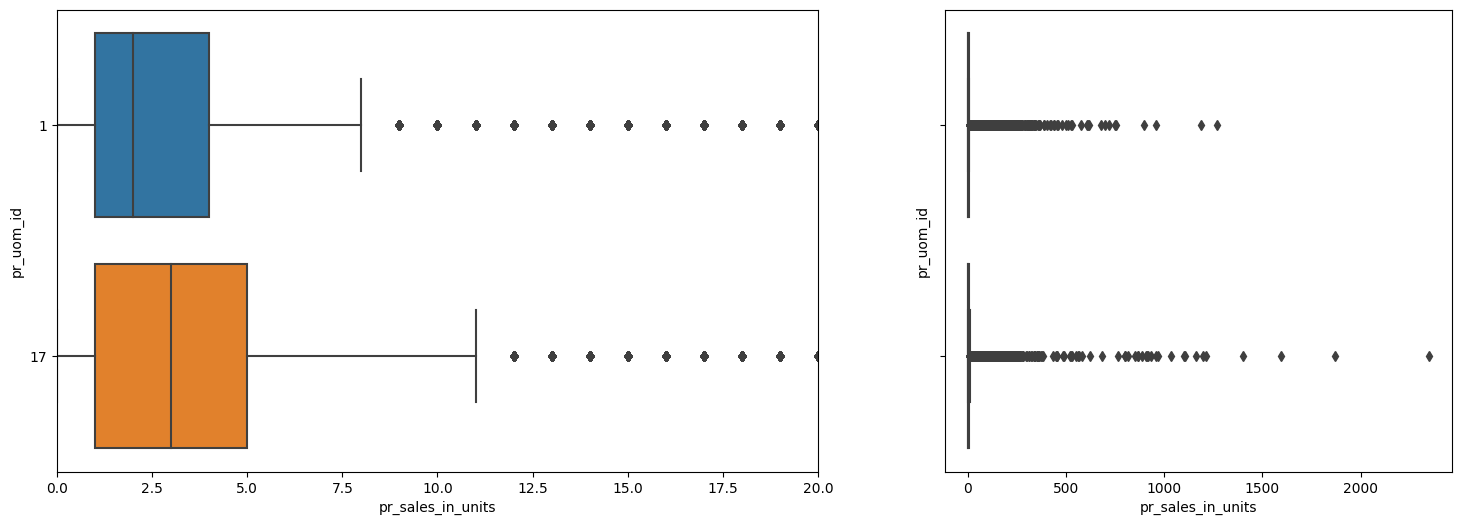

In [46]:

category_ts_agg_plot('pr_uom_id')

Весовой или штучный `pr_uom_id`: 
- 1 - продажи в день в среднем ниже (~4), больше заметна сезонность
- 17 - в среднем выше (~5), резкие пики в НГ и пасху

#### По магазинам

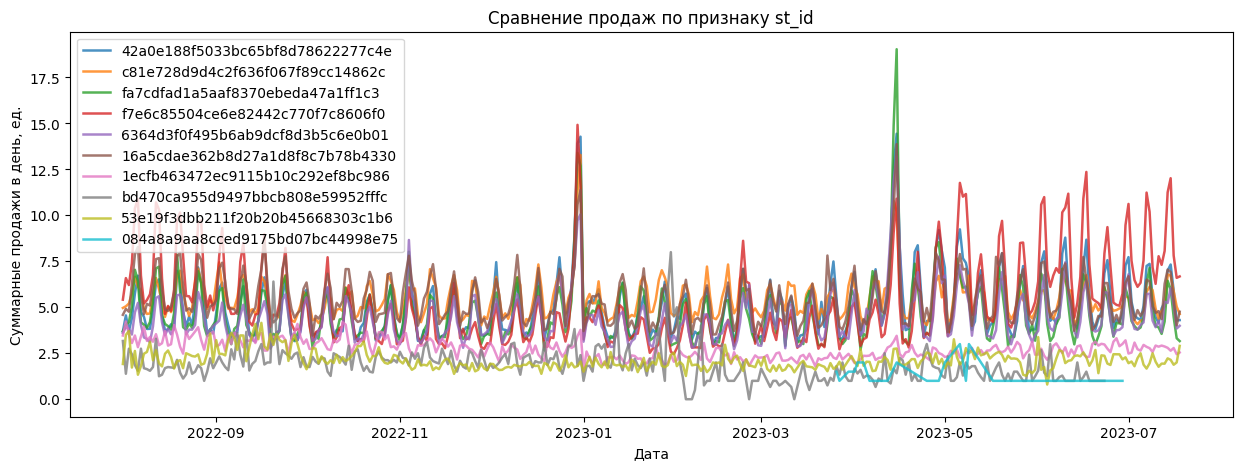

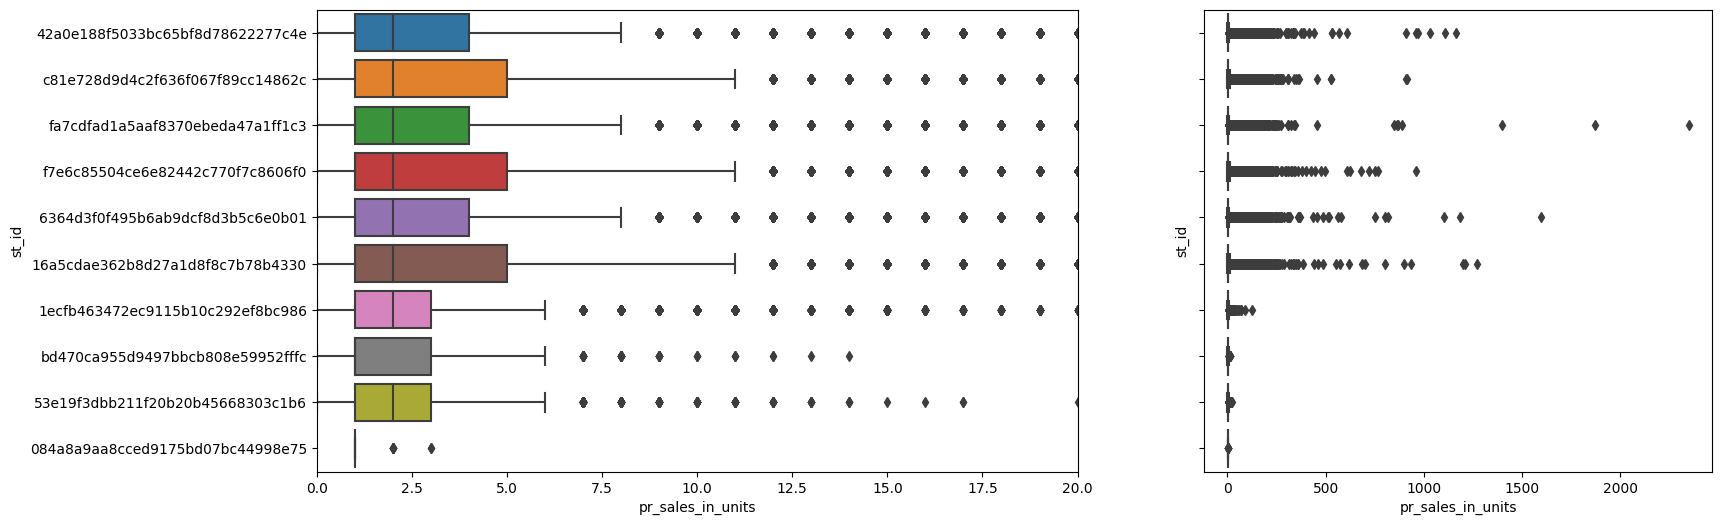

In [47]:
category_ts_agg_plot('st_id')

- Магазины `st_id`: 2 группы с более высокими продажами(~5) и низкими (~2,5), 1 магазин начинается только с апреля 2023


#### По группам товаров

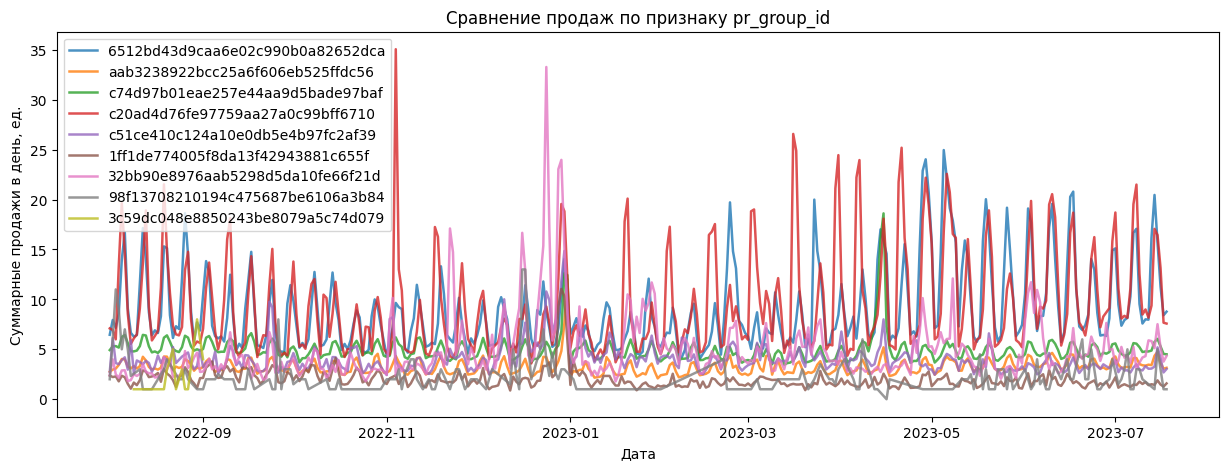

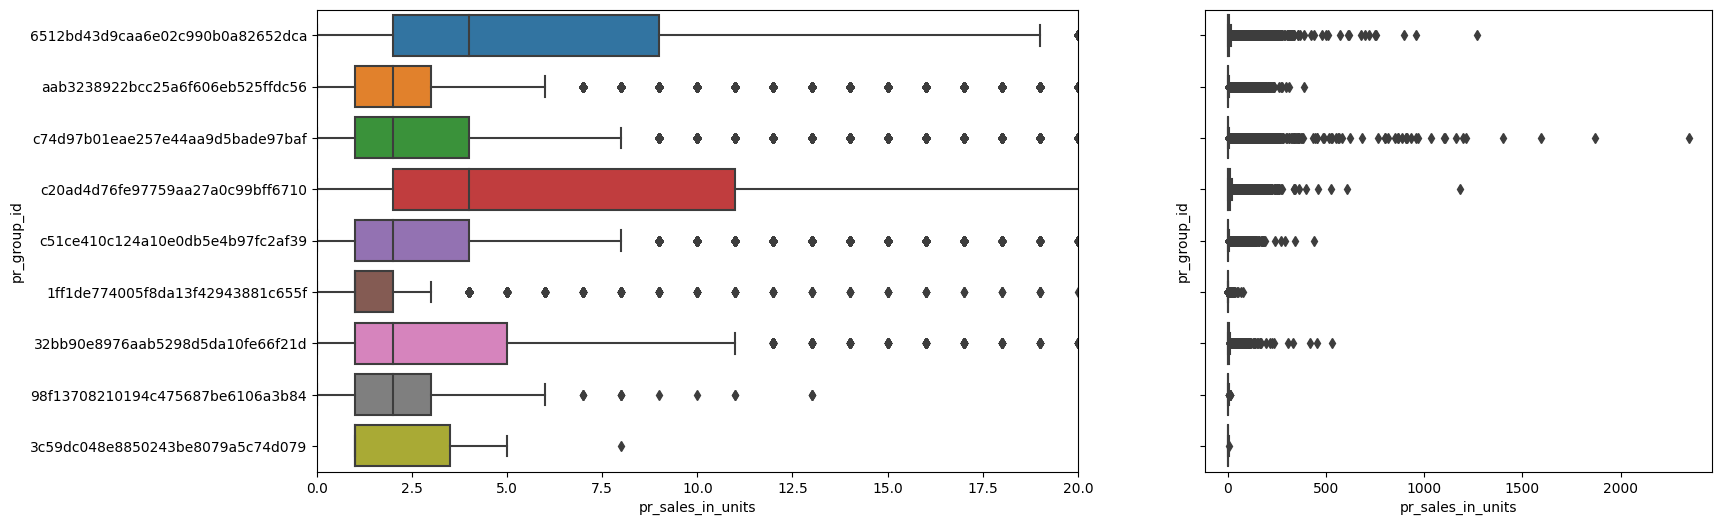

In [48]:
category_ts_agg_plot('pr_group_id')

- Группы товаров `pr_group_id`: 2 группы с высокими продажами (~10-15) и пиками особенно в летний период, 1 группа с пиком в НГ

#### По категориям товаров

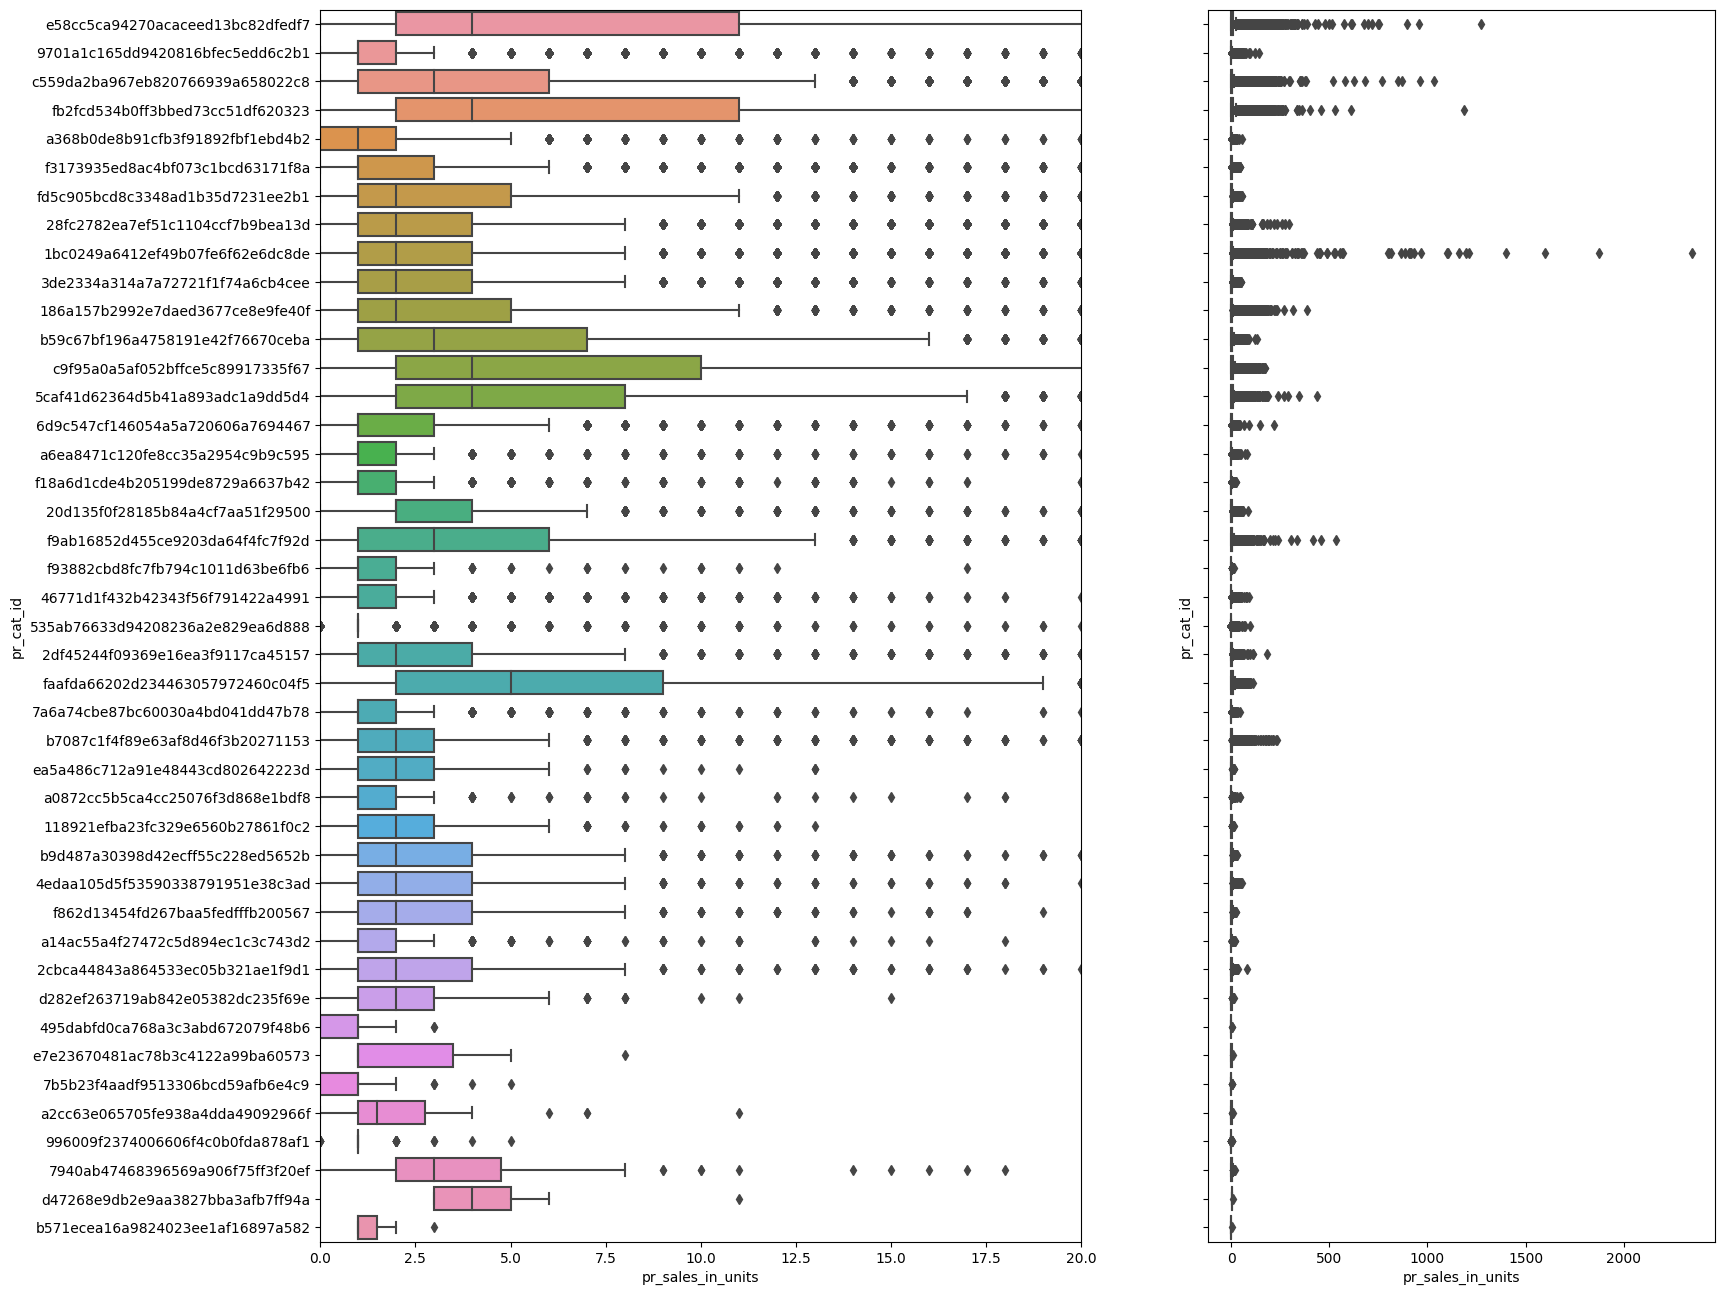

In [112]:
# боксплоты
fig, axs = plt.subplots(1, 2, figsize=(18, 16), gridspec_kw={'width_ratios': [1.5, 1]})
sns.boxplot(data=df, y='pr_cat_id', x='pr_sales_in_units', orient='h', ax=axs[0]).set_xlim(0, 20)
sns.boxplot(data=df, y='pr_cat_id', x='pr_sales_in_units', orient='h', ax=axs[1]).set_yticklabels([])
None

- Категории товаров `pr_cat_id`: есть менее 10 категорий со средними более высокими продажами


#### По дивизионам

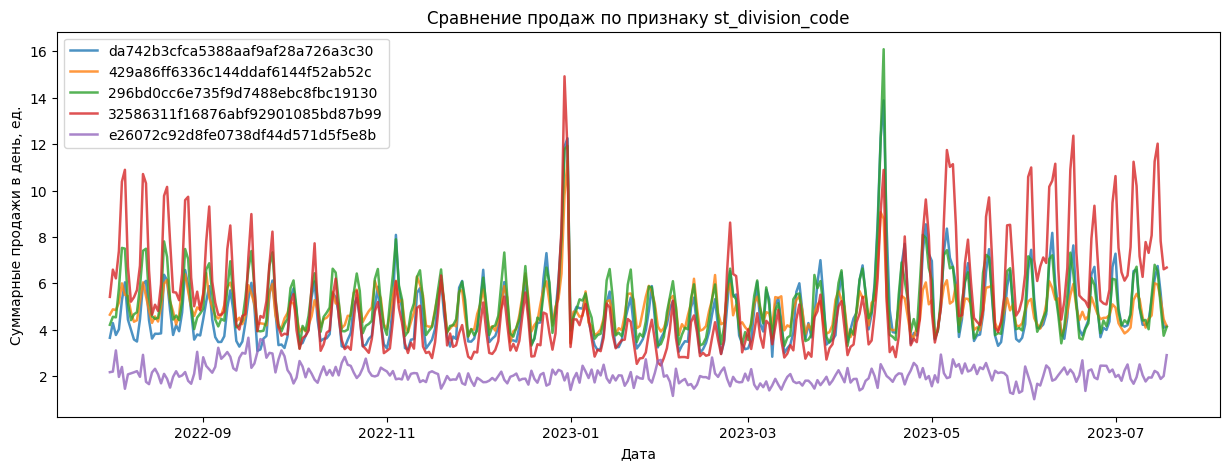

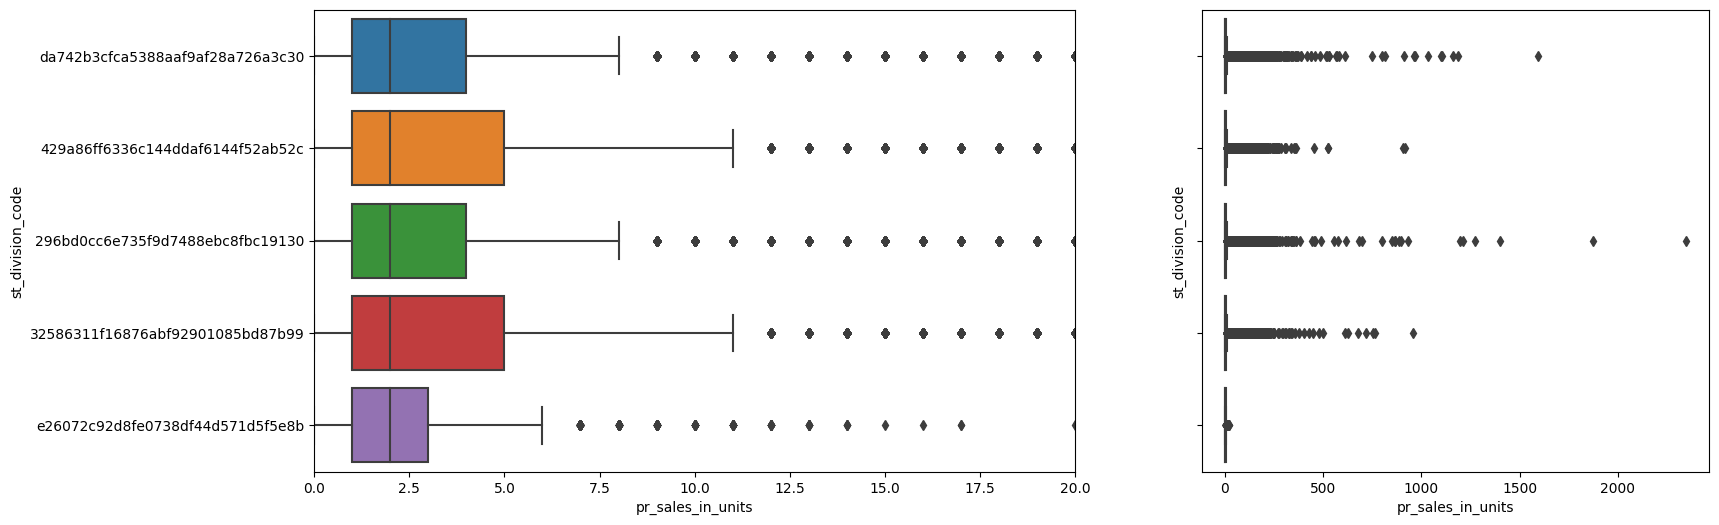

In [50]:
category_ts_agg_plot('st_division_code')

Формат магазина `st_division_code`: 
- выделяется заметно один дивизион низкими продажами (~2), 
- один выделяется выраженной сезонностью: спад октябрь-апрель, значительный подъём в летний сезон


#### По городам

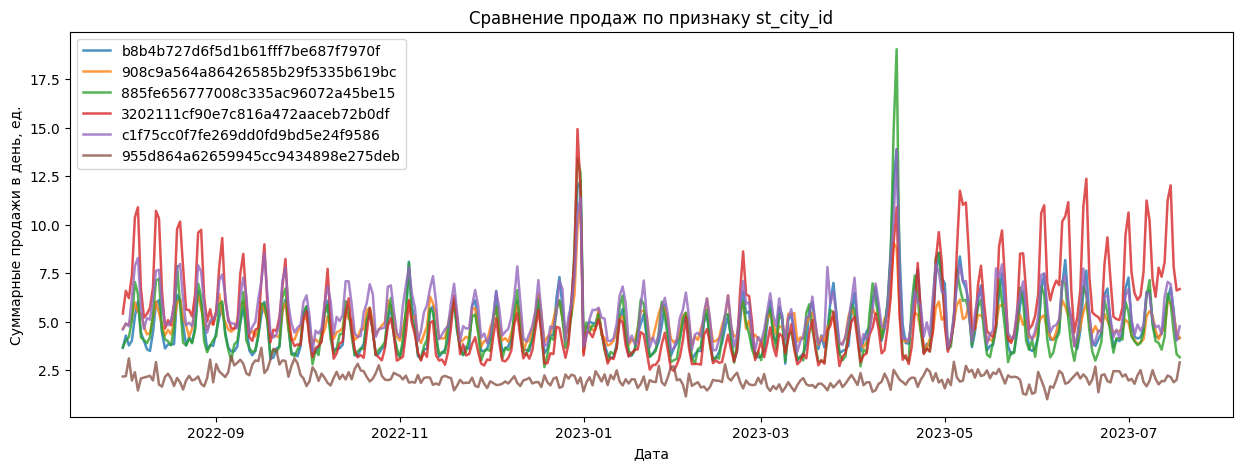

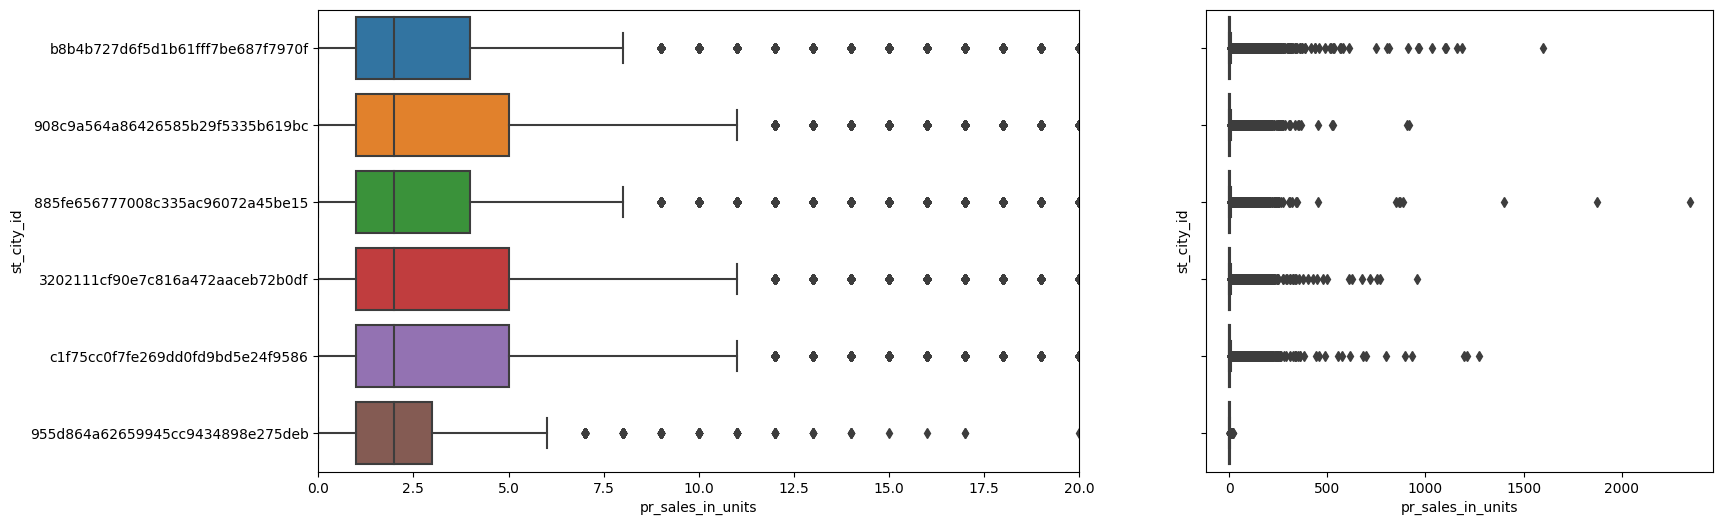

In [51]:
category_ts_agg_plot('st_city_id')

#### По формату магазина

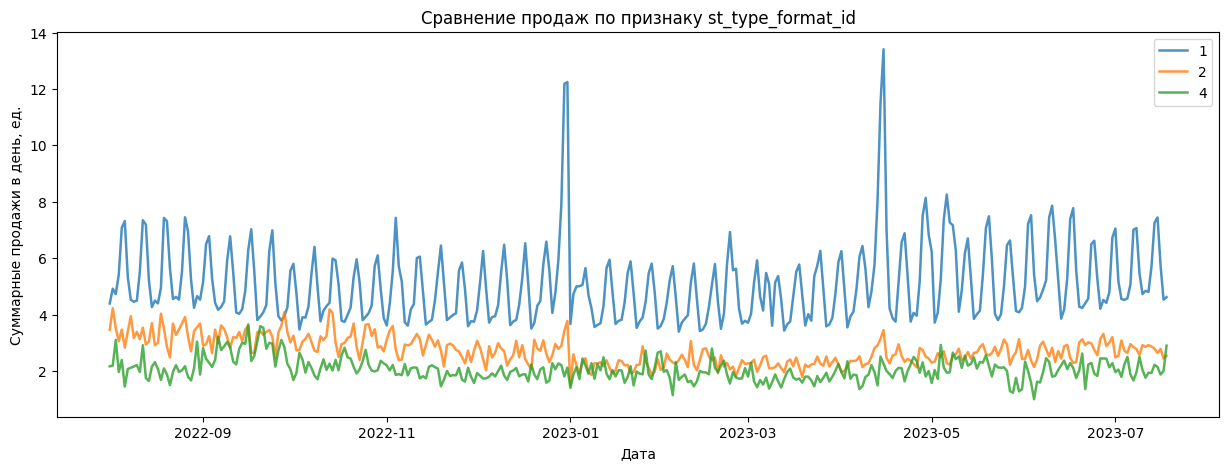

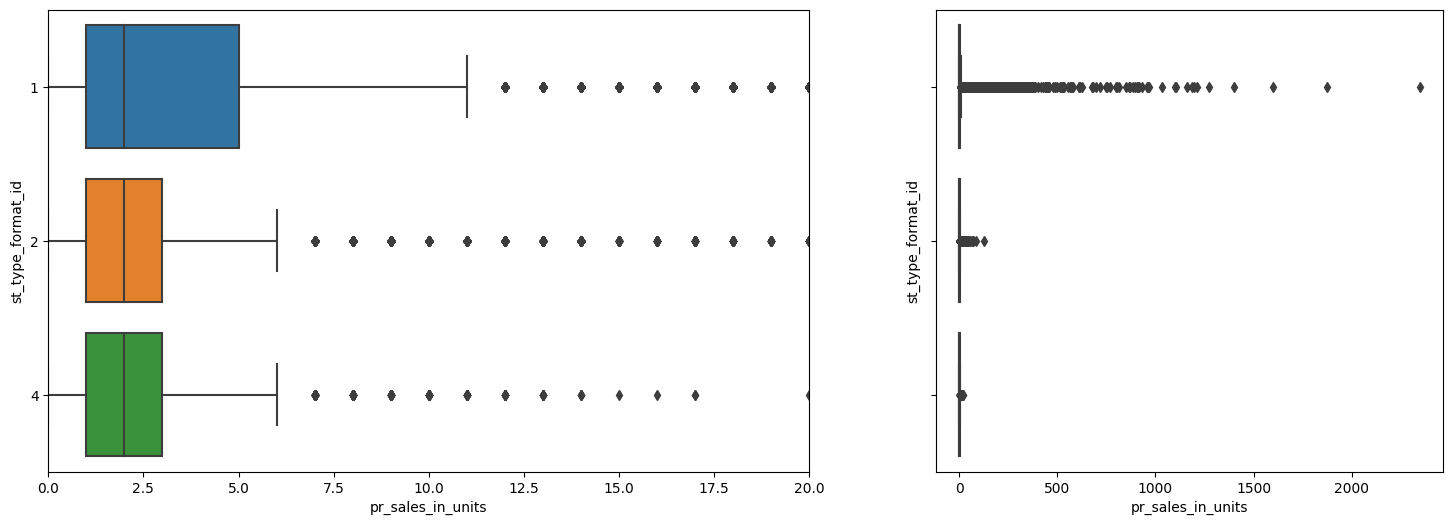

In [52]:
category_ts_agg_plot('st_type_format_id')


- Формат магазина `st_type_format_id`: 1 - высокие продажи (\~6), 2,4 - низкие (~2-4)


#### По размеру магазина

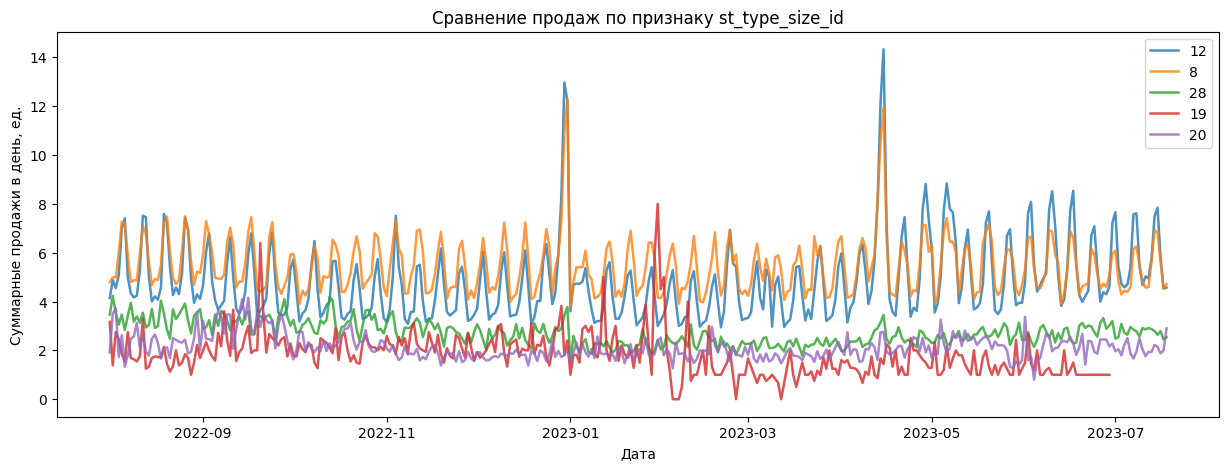

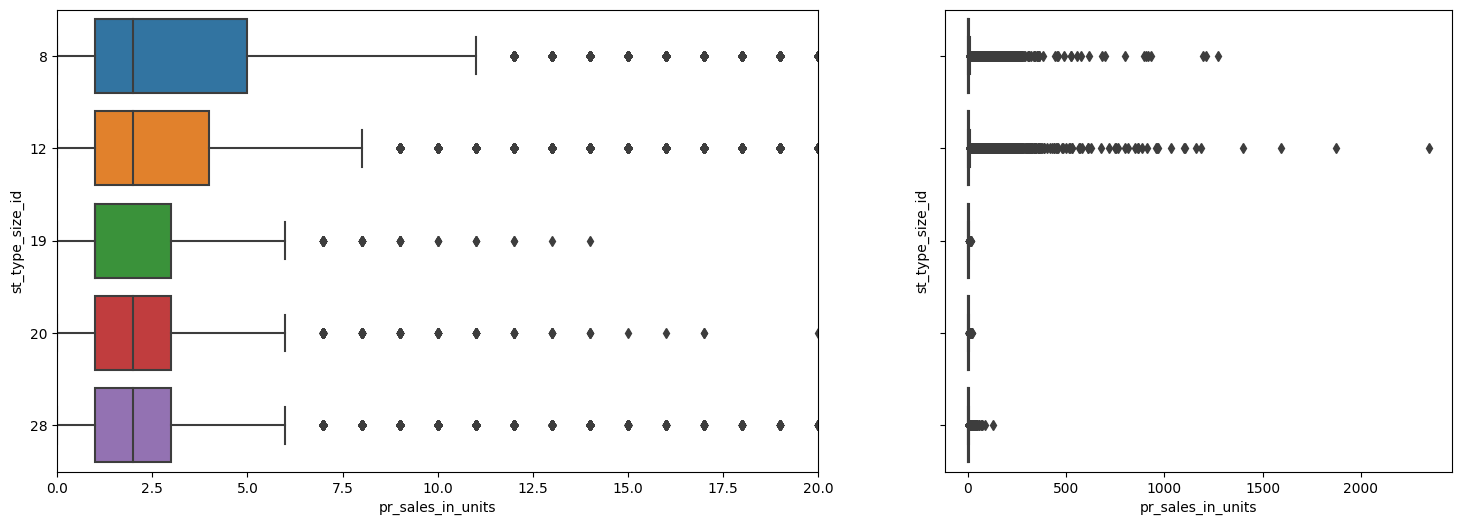

In [53]:
category_ts_agg_plot('st_type_size_id')

- Размер магазина `st_type_size_id`: 12 - самые высокие продажи, далее 8, остальные три ниже 19, 20,28

#### По локации/окружению магазина

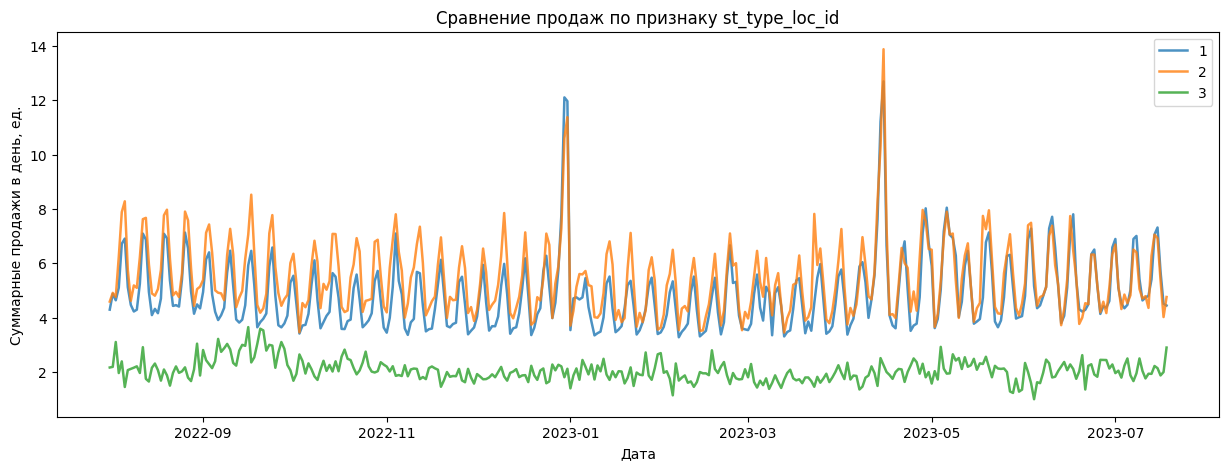

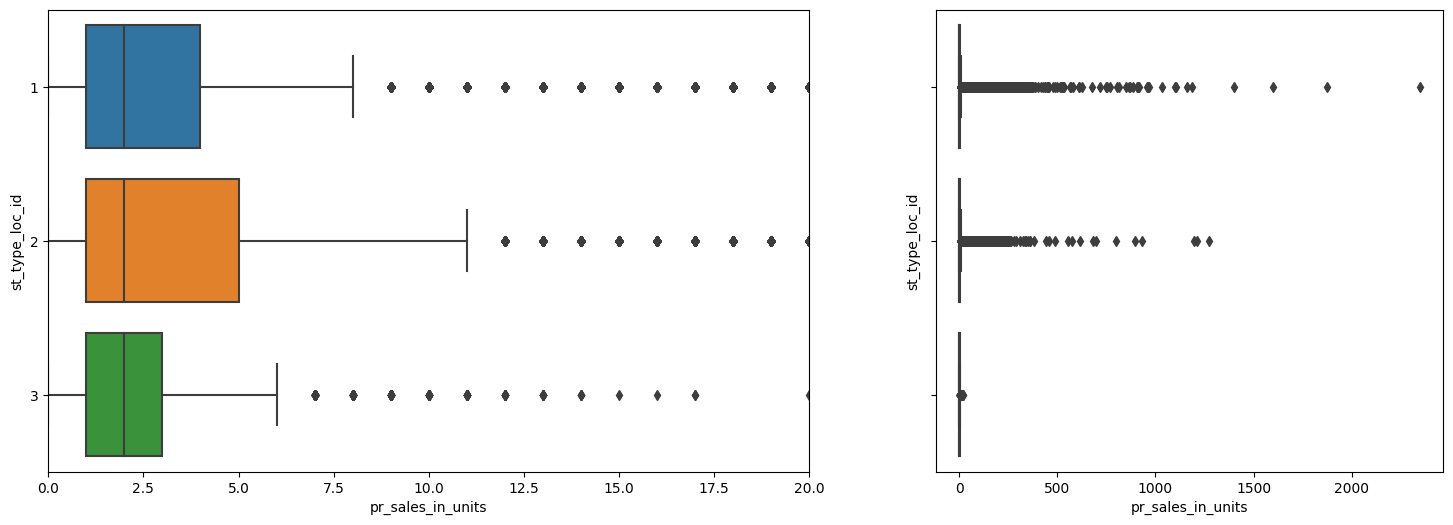

In [54]:
category_ts_agg_plot('st_type_loc_id')

- Окружение `st_type_loc_id`: 1,2 - высокие продажи (\~5-6), 3 - низкие (\~2)


----
- Промо `pr_sales_type_id`:  в зимний сезон одинаковый спрос на товары по промо и без,  в летний спросна промо выше, в период вторая половина апреля- май спрос на промо выше в 2-3 раза
- Весовой или штучный `pr_uom_id`:  1 - продажи в день в среднем ниже (\~4), больше заметна сезонность; 17 - в среднем выше (\~5), резкие пики в НГ и пасху
- Группы товаров `pr_group_id`: 2 группы с высокими продажами (~10-15) и пиками особенно в летний период, 1 группа с пиком в НГ
- Категории товаров `pr_cat_id`: есть менее 10 категорий со средними более высокими продажами

- Магазины `st_id`: 2 группы с более высокими продажами(~5) и низкими (~2,5), 1 магазин начинается только с апреля 2023
- Дивизион  `st_division_code`: выделяется заметно один дивизион низкими продажами (~2), один выделяется выраженной сезонностью: спад октябрь-апрель, значительный подъём в летний сезон
- Формат магазина `st_type_format_id`: 1 - высокие продажи (-6), 2,4 - низкие (~2-4)
- Окружение `st_type_loc_id`: 1,2 - высокие продажи (~5-6), 3 - низкие (~2)
- Размер магазина `st_type_size_id`: 12 - самые высокие продажи (~6), далее 8 (~4-5), остальные три ниже 19, 20,28 (~2)

In [ ]:
category_ts_agg_plot('price_day_group')

In [110]:
df.columns

Index(['st_id', 'pr_sku_id', 'date', 'pr_sales_type_id', 'pr_sales_in_units',
       'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub',
       'pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'pr_uom_id', 'st_city_id',
       'st_division_code', 'st_type_format_id', 'st_type_loc_id',
       'st_type_size_id', 'price_day_product', 'price_day_group',
       'cluster_hierarchy', 'day_of_week', 'day', 'week', 'holiday', 'lag_1',
       'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9',
       'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16',
       'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23',
       'lag_24', 'lag_25', 'lag_26', 'lag_27', 'lag_28', 'lag_29', 'lag_30',
       'rolling_mean_7', 'rolling_mean_14'],
      dtype='object')

### Кластеризация 
**По магазинам и товарам**


In [55]:
# # downgrade numpy to make KMeans work
# !pip install  numpy==1.24
# !pip install threadpoolctl==3.1

In [56]:
# масштабировать и закодировать признаки перед kmeans
ohe_col = ['pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'pr_sku_id', 'st_id', 'st_city_id', 'st_division_code']
scale_col = ['pr_uom_id', 'st_type_format_id', 'st_type_loc_id', 'st_type_size_id']

preprocessor_kmeans = ColumnTransformer(
                                        transformers=[
     ('oh_enc', OneHotEncoder( drop='first'), ohe_col),
     ('scaler', StandardScaler(), scale_col)])

1 : 8465391.93430334
2 : 7216548.0088457335
3 : 6136031.11411982
4 : 5267192.220629105
5 : 4724400.35768467
6 : 4427014.650808526
7 : 4192645.549774728
8 : 3674963.5387319773
9 : 3550415.9594345456
10 : 3350412.8392975098


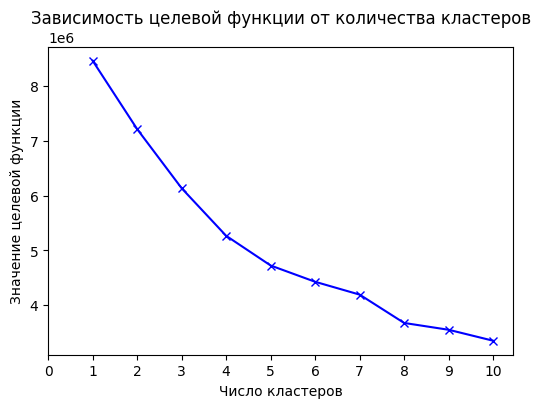

In [57]:
# список для фиксирования фунции потерь для моделей с разным количеством кластеров
distortion = []
# испытаем модели с 1-10 кластерами
K = range(1, 11)
for k in K:
    pipeline_kmeans = Pipeline(steps=[
                            ('preprocessor', preprocessor_kmeans),
                              ('clustering', KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init='auto'))])
    pipeline_kmeans.fit(df[scale_col+ohe_col])
    distortion.append(pipeline_kmeans.steps[1][1].inertia_)
    print(k,':', pipeline_kmeans.steps[1][1].inertia_)
# график  
plt.figure(figsize=(6, 4))
plt.plot(K, distortion, 'bx-')
plt.xticks(range(k+1))
plt.xlabel('Число кластеров')
plt.ylabel('Значение целевой функции')
plt.title('Зависимость целевой функции от количества кластеров')
plt.show()

In [58]:
# определяем пайплайн
pipeline_kmeans = Pipeline(steps=[
                            ('preprocessor', preprocessor_kmeans),
                              ('clustering', KMeans(n_clusters=5, random_state=RANDOM_STATE, n_init='auto'))])



# проводим кластеризацию объектов, обучение на train
pipeline_kmeans.fit(df[scale_col+ohe_col])
# к обучающей выборке добавляем новый признак с номерами кластеров, переводим в строковый тип данных 
df['cluster_hierarchy'] = pipeline_kmeans.steps[1][1].labels_

# оценим результат
df['cluster_hierarchy'].value_counts()

cluster_hierarchy
3    264198
4    217298
1    183989
0    157542
2     59259
Name: count, dtype: int64

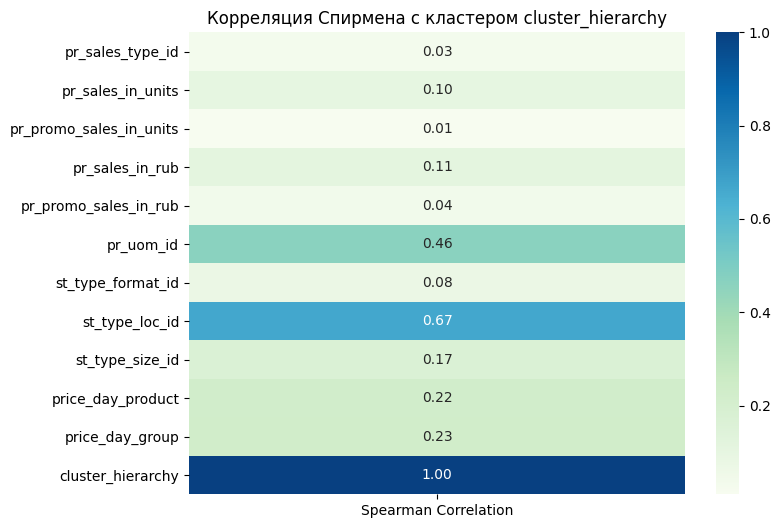

In [59]:
# Расчет коэффициентов корреляции Спирмена для численных признаков и столбца 'cluster_tk'
spearman_corr_with_cluster = df.corrwith(df['cluster_hierarchy'], method='spearman', numeric_only=True)

# Вывод коэффициентов корреляции в виде DataFrame
spearman_corr_df = spearman_corr_with_cluster.abs().to_frame()
spearman_corr_df.columns = ['Spearman Correlation']

# Визуализация коэффициентов корреляции
plt.figure(figsize=(8, 6))
sns.heatmap(spearman_corr_df, annot=True, cmap='GnBu', fmt=".2f")
plt.title('Корреляция Спирмена с кластером cluster_hierarchy')
plt.show()

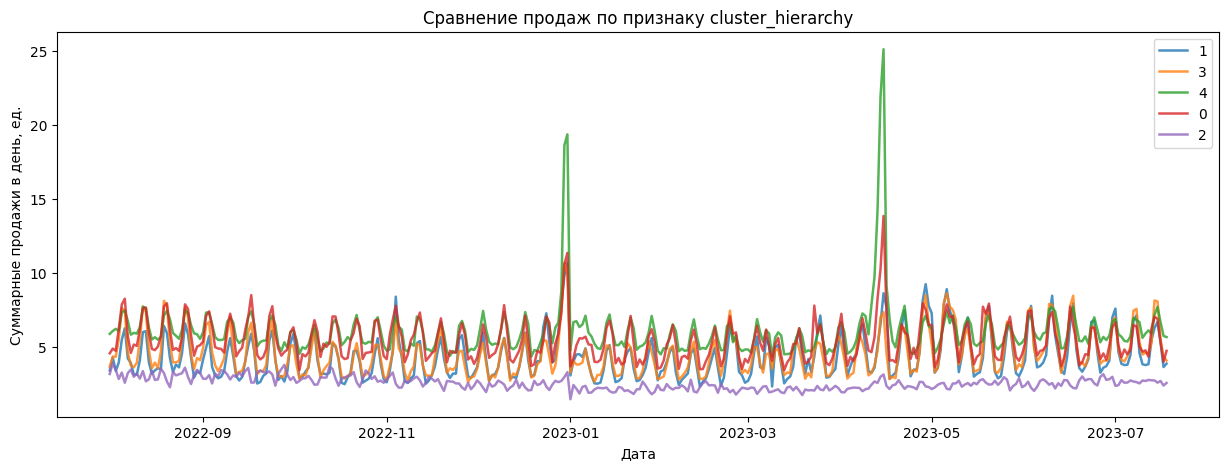

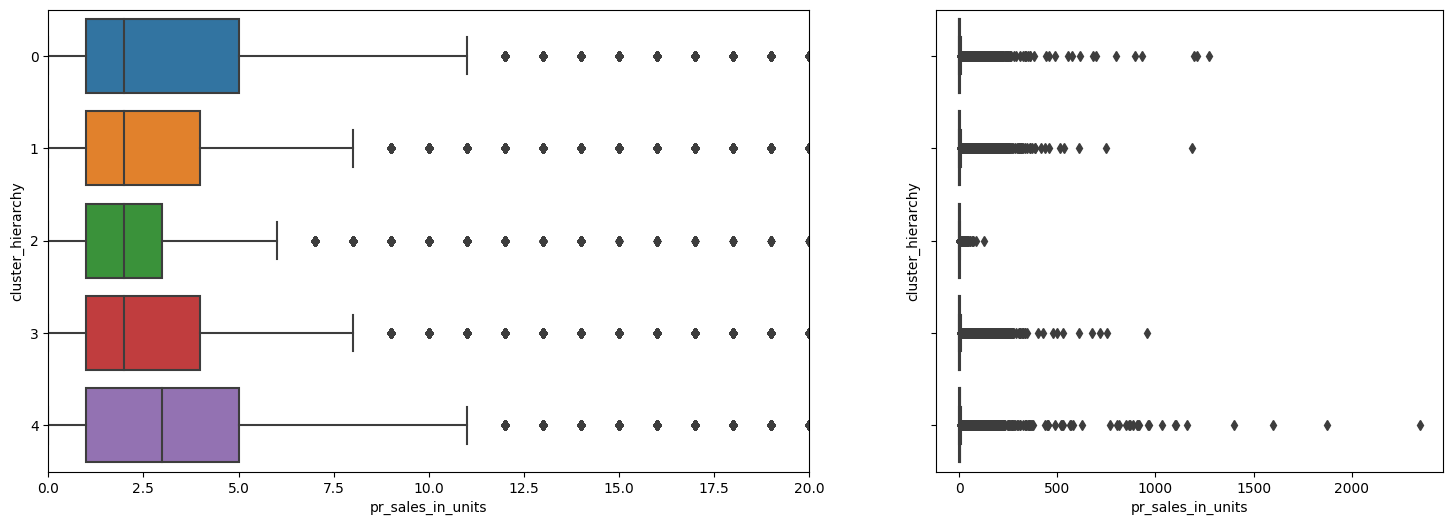

In [60]:
category_ts_agg_plot('cluster_hierarchy')

Положительная монотонная связь между cluster_hierarchy и st_type_loc_id, pr_uom_id, st_type_format_id - что ожидаемо.

## Feature engineering
2. Сгенерировать признаки
    1. День недели (0-6) - в выходные продажи выше
    2. Месяц, номер недели, число месяца
    3. Флаг праздника - отметить праздники, которые на графиках имеют пик
    4. Придумать как отметить период до праздника, когда продажи также возрастают
    5. Лаговые признаки.  1,2,3, 7, 14, 21, 28 дней. 
    6. Скользящее среднее за предыдущую неделю (+/или берём скользящее среднееза неделю в период за 2 недели до, так будут реальные данные, а не прогнозы).
    
**Календарные признаки**

In [61]:
# 1. День недели (0-6) - в выходные продажи выше
df['day_of_week'] = df['date'].dt.dayofweek
# 2. месяц, номер недели, число месяца?? в рамках данных одного года не повлияют, но при увеличении периода будут полезны
df['day'] = df['date'].dt.day
df['week'] = df['date'].dt.isocalendar().week


**Праздники**

In [62]:
# загрузим таблицу всех выходных: викенд и праздники
holiday_table = pd.read_csv('holidays_calendar.csv', parse_dates=['date']) 

In [63]:
# добавим признак выходного дня
df = df.merge(holiday_table[['date','holiday']], on='date', how='left')

In [64]:
# признак по самым высоким продажам в праздничные дни
# Агрегируем данные:
daily_sales = df.groupby('date')['pr_sales_in_units'].sum().reset_index()
# Нужно сделать ресерч, что бы понять, какие пики отбирать тут:
threshold = 1.7  # 70% выше средних продаж
# Создаем новый признак:
daily_sales['is_holiday_big_demand'] =\
            (daily_sales['pr_sales_in_units'] > daily_sales['pr_sales_in_units'].mean() * threshold).astype(int)

daily_sales[daily_sales['is_holiday_big_demand']==1]

date  pr_sales_in_units  is_holiday_big_demand
150 2022-12-29            25303.0                      1
151 2022-12-30            39615.0                      1
152 2022-12-31            34145.0                      1
256 2023-04-14            31898.0                      1
257 2023-04-15            37376.0                      1
271 2023-04-29            22452.0                      1
278 2023-05-06            22431.0                      1
313 2023-06-10            21689.0                      1

Самые высокие общие продажи за день - превышают 70% среди всех: предновогодние 3 дня, Пасха и день до, 2 пятницы перед майскими праздниками и последний день майских праздников

- Вариант 1: отметить флагом 1 дни с общими продажами выше на 50% 
- Вариант 2:  распространённо празднуемые праздники и предшествующие дни задать коэффициентом или флагом (частично вручную). Просто выходным дням недели также можно присвоить коэффициент поменьше.
- Или отказаться пока: Сейчас мы работаем с данными за год, поэтому этот признак не принесёт пользы в рамках решения узкой задачи прогнозирования двух последних недель исследуемого года. Оставить как возможное улучшение.

**Лаги и скользящее среднее**

In [65]:
# функция для создания лаговых признаков
def make_features_lag_eda(data, list_of_lag, list_rolling_mean_size):
    data_iterated = data.copy()
    # лаги
    for lag in list_of_lag: 
        data_iterated['lag_{}'.format(lag)] = data_iterated['pr_sales_in_units'].shift(lag)
    # скользяцие средние
    for rolling_mean_size in list_rolling_mean_size:
        data_iterated['rolling_mean_{}'.format(rolling_mean_size)] =\
                        data_iterated['pr_sales_in_units'].shift().rolling(rolling_mean_size).mean()
    # удаление образовавшихся пропусков
#     data_iterated = data_iterated.dropna()
    return data_iterated

In [66]:
df = make_features_lag_eda(df, range(1,31), [7,14])

Оценим корреляцию с новыми признаками

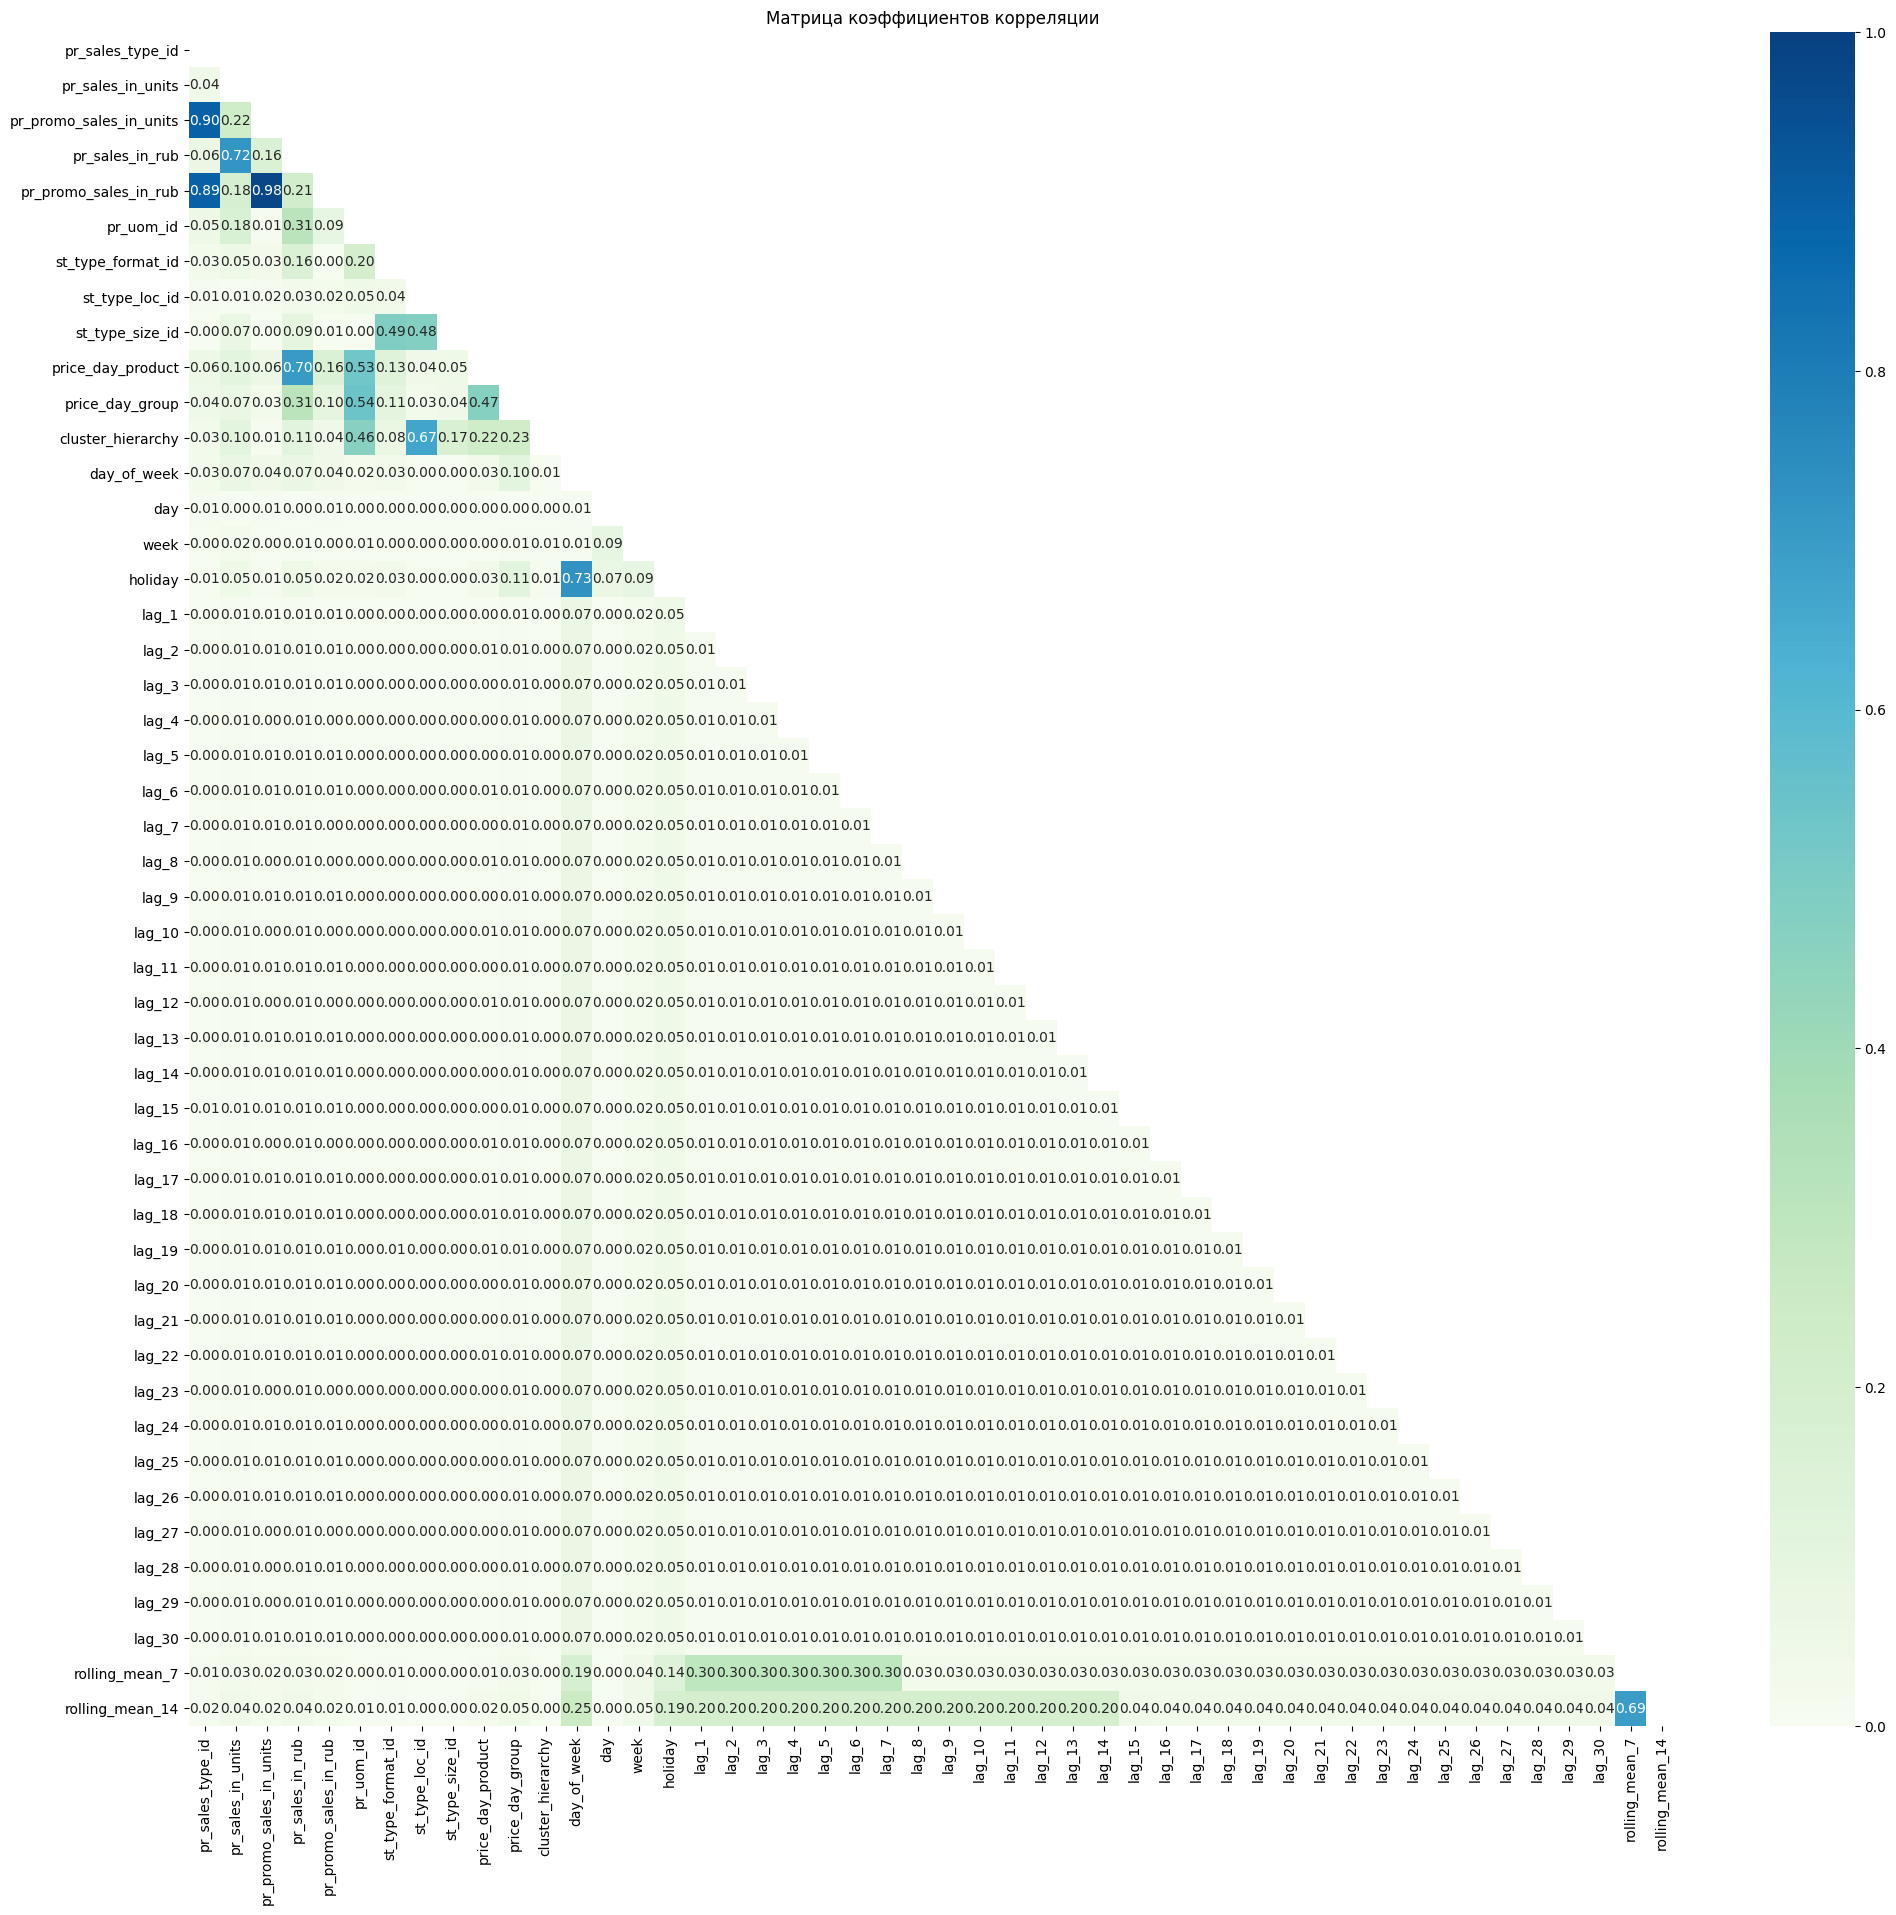

In [67]:
# корреляция Спирмена
plt.figure(figsize=(24, 22))
corr_heatmap(df.corr(method='spearman', numeric_only=True))

Линейной зависимости c сгенерированными признаками нет

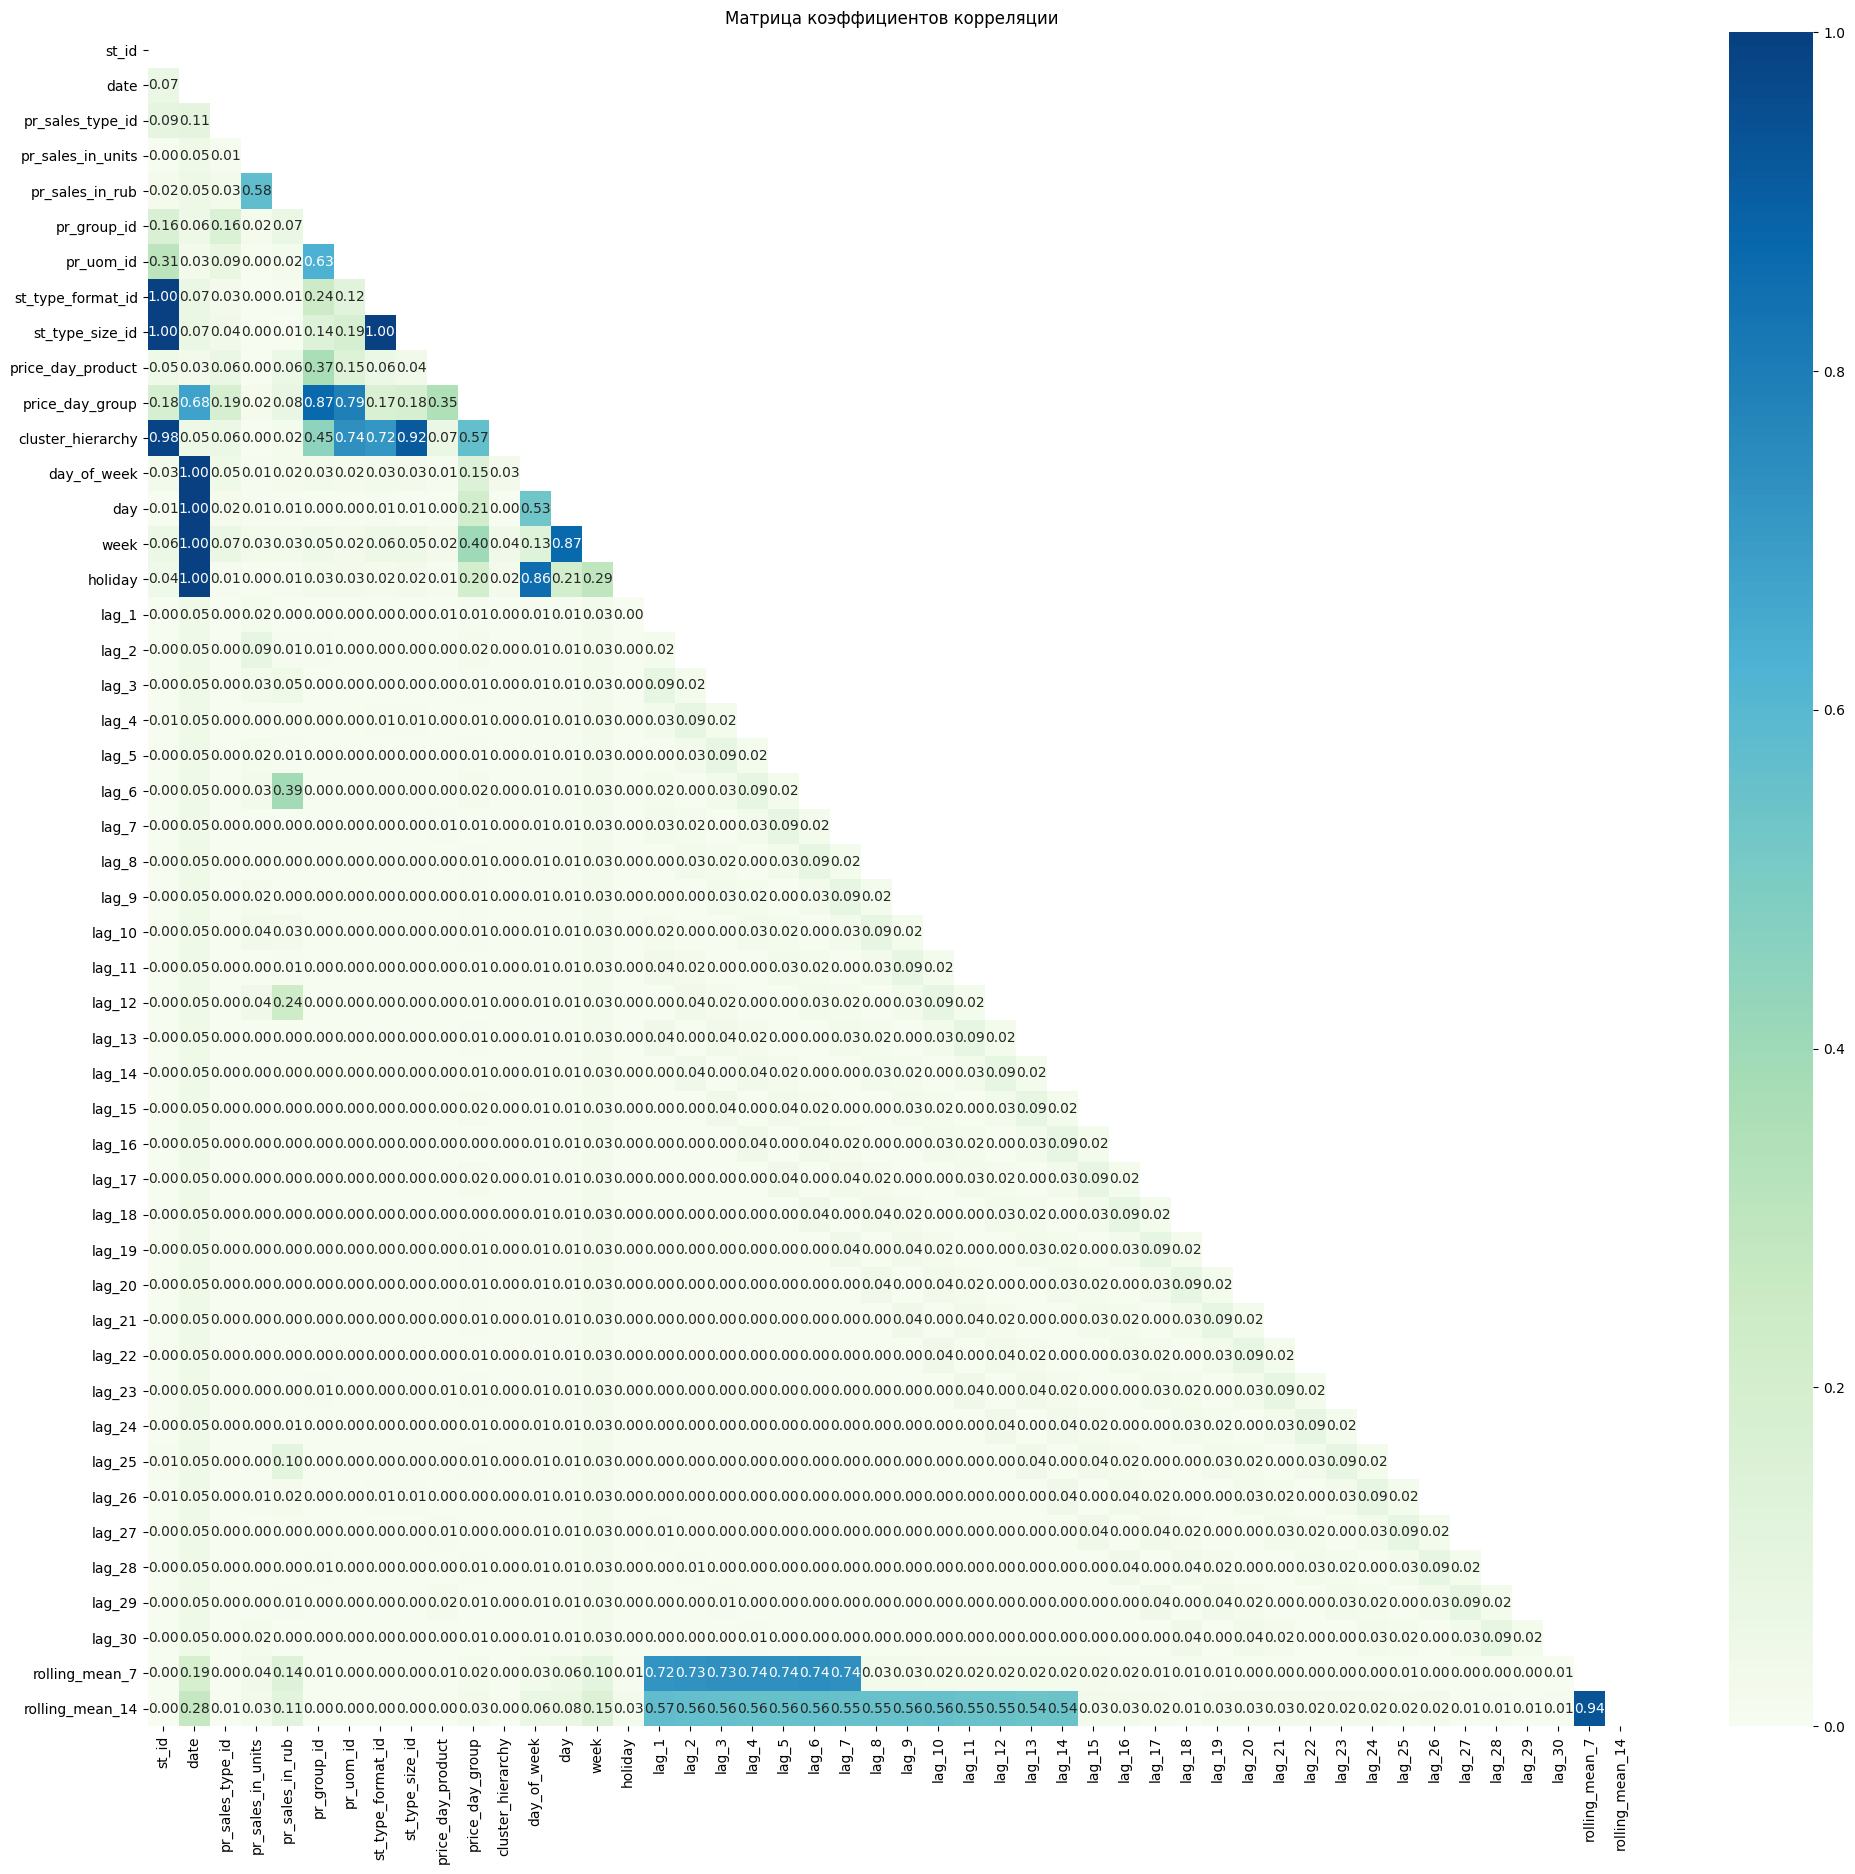

In [68]:
# # корреляция фи
plt.figure(figsize=(24, 22))
phik_matrix_4 = df.drop(['pr_sku_id', 'pr_subcat_id', 'pr_cat_id', 'pr_promo_sales_in_units',
                        'pr_promo_sales_in_rub', 'st_city_id','st_division_code', 
                         'st_type_loc_id'], axis=1).phik_matrix(interval_cols=\
   ['pr_sales_in_units',  'pr_sales_in_rub',  'price_day_product', 'price_day_group', 
    'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 
    'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 
    'lag_22', 'lag_23', 'lag_24', 'lag_25', 'lag_26', 'lag_27', 'lag_28', 'lag_29', 'lag_30', 'rolling_mean_7', 
    'rolling_mean_14', 'rolling_mean_21', 'rolling_mean_28'])
corr_heatmap(phik_matrix_4)

Не выявлено значительной корреляции с новыми признаками

---
**Выводы EDA**
- g


### TSFRESH 

<div class="alert alert-success">

- Разобраться, почему на выходе мало строк - как присоединить их к датасету
- как ускорить генерацию, если вставлять в обучение
- эти признаки потом нужно сгенерировать в тестовой выборке



Для генерации признаков с помощью TSFresh пока возьмём основные признаки, категориальные закодируем с помощью TargetEncoder

In [69]:
# # закодируем категориальные
# df_encod = df[['pr_sku_id', 'pr_sales_in_units', 'st_id', 'pr_group_id']]
# encoder = TargetEncoder(cols=['pr_sku_id', 'pr_sales_in_units', 'st_id', 'pr_group_id'])
# df_ts_fresh = encoder.fit_transform(df_encod, df_encod['pr_sales_in_units'])
# # добавим числовые признаки
# df_ts_fresh[['pr_uom_id', 'pr_sales_type_id', 'price_day_group', 'date']] = df[['pr_uom_id', 'pr_sales_type_id', 
#                                                                                 'price_day_group', 'date']]

# df_ts_fresh

In [70]:
# y = df['pr_sales_in_units']
# X = extract_features(df_ts_fresh,
#                      column_id = 'pr_sku_id',
#                      column_sort = 'date')
# #                     ,default_fc_parameters="minimal",  # Выбор набора признаков (можно изменить)
# #                      impute_function=impute.impute)

In [195]:
# # сохраним датафрейм с сгенерированными признаками
# # X.to_csv('tsfresh_features.csv', index=True)
# X = pd.read_csv('tsfresh_features.csv')
# X.set_index('Unnamed: 0', inplace=True)

In [72]:
# X

In [73]:
# X.columns.tolist()

In [74]:
# # в датафрейме много пропусков
# X.isna().sum().sum()

In [75]:
# для select_features не должно быть пропусков, нужно обработыть
# X = X.fillna(0)

In [76]:
# # Выбор наиболее важных признаков (по желанию)
# X_important = select_features(X, y)
# X_important

# AssertionError: X and y must contain the same number of samples. 

##  Моделирование
### Подготовка данных

Чтобы временные ряды каждой комбинации Магазин-Товар были полными (все даты за год), создадим новый датасет, в который добавим отсутствующие даты с нулями в целевом признаке. 

Для обучения пока берём только записи по непромо продажам 


In [2]:
# -- Загрузка и предобработка таблиц из базы данных --

# Открыть датасеты (из json, сейчас из csv)
data_train = pd.read_csv('sales_df_train.csv',  parse_dates=['date'])
data_hierarchy = pd.read_csv('pr_df.csv') 
data_stores = pd.read_csv('st_df.csv') 
holiday_table = pd.read_csv('holidays_calendar.csv', parse_dates=['date']) 

#  Предобработка 
# удалить неактивные магазины из data_train
stores_valid_ids = data_stores[data_stores['st_is_active'] == 1]['st_id']
data_train = data_train[data_train['st_id'].isin(stores_valid_ids)]
# data_stores = data_stores.drop('st_is_active', axis=1)

# удалить некорректных данных из data_train: 
# - отрицательные значения в целевом признаке
data_train = data_train.drop(data_train[data_train['pr_sales_in_units'] < 0].index)
# - 0 товаров в целевом признаке, но есть сумма выручки и 0 выручка, но есть продажи в штуках
data_train = data_train.drop(data_train[
                    (data_train['pr_sales_in_units'] == 0) & (data_train['pr_sales_in_rub'] != 0) |
                    (data_train['pr_sales_in_units'] != 0) & (data_train['pr_sales_in_rub'] == 0)]
                                         .index)

# удалить ненужные столбцы из data_train
data_train = data_train.drop(['pr_promo_sales_in_units', 'pr_promo_sales_in_rub', 'pr_sales_in_rub'], axis=1)


In [3]:
# функция для создания шаблона обучающей выборки и подготовки данных для прогнозирования
def prepare_full_ts_df_with_features(dates):
    """Функция создаёт шаблон датасаета с полными временными рядами за весь период для всех комбинаций Магазин-товар из data_train 
        и признаками(без лаговых). 
        Параметр dates -  набор всех дат за которые нужно сгенерировать датасет со всеми комбинациями магазин-товар,
        для обучающего датасета - период дат train_data, для тестового датасета - период дат на которые нужно дать прогноз"""
 
    # Создадим шаблон  по всем существующим комбинациям категорий:
    # все комбинации магазин-товар из трейна 
    st_pr_ids = data_train[['st_id', 'pr_sku_id']].drop_duplicates()
    # функция генерирует датасет со всеми комбинациями магазин-това-даты последовательно по датам
    def create_submissions(ids, dates):
        dataframe = copy.deepcopy(ids)
        dataframe['date'] = dates[0]
        for date in dates[1:]:
            new_dataframe = copy.deepcopy(ids)
            new_dataframe['date'] = date
            dataframe = pd.concat([dataframe, new_dataframe])
        return dataframe
    # создаём шаблон с комбинацией всех пар магазин-товар из трейна и всех дат в периоде датасета с продажами data_train 
    submissions_template = create_submissions(st_pr_ids, dates)
    # назначим индексом магазин-товар-дата
    submissions_template = submissions_template.groupby(by=['st_id', 'pr_sku_id', 'date']).count()
    # заготовим столбец с магазином и sku товара, будут закодированы
    submissions_template['st_enc'] = submissions_template.index.get_level_values(0)
    submissions_template['pr_sku_enc'] = submissions_template.index.get_level_values(1)
    
    # Фиче-инжениринг по дате: 
    submissions_template['day'] = submissions_template.index.get_level_values(2).day
    submissions_template['week'] = submissions_template.index.get_level_values(2).isocalendar().week.tolist()
    submissions_template['day_of_week'] = submissions_template.index.get_level_values(2).dayofweek    
    
    # из таблицы с выходными днями добавим в таблицу по дате признак с флагом выходного дня
    submissions_template = submissions_template.join(holiday_table.set_index('date'))
    
    # присоединяем признаки из других таблиц
    submissions_template = submissions_template.join(data_hierarchy.set_index('pr_sku_id'), on='pr_sku_id')
    submissions_template = submissions_template.join(
                                    data_stores.set_index('st_id').drop('st_is_active', axis=1), on='st_id')
    
    return submissions_template

In [4]:
# функция для создания лаговых признаков
def make_features_lag_alternate(data):
    data_iterated = data.copy()
    # лаги
    for lag in range(1, 31): #[1, 2, 3, 4, 5, 6, 7, 14, 21]: 
        data_iterated['lag_{}'.format(lag)] = data_iterated['pr_sales_in_units'].shift(lag)
    # скользяце среднее
    data_iterated['rolling_mean_{}'.format(7)] =\
                        data_iterated['pr_sales_in_units'].shift().rolling(7).mean()
    
    # скользящее среднее 7 дней две недели назад
    
    
    # удаление образовавшихся пропусков
#     data_iterated = data_iterated.drop(data_iterated.loc[
#      (data_iterated.index.get_level_values(2).day<=list_of_lag[-1]) & 
#      (data_iterated.index.get_level_values(2).month == data_iterated.index.get_level_values(2).min().month)].index)
    
    return data_iterated

Создаём обучающую выборку `data_train_no_promo`

In [6]:
# для обучающего датасета - генерируем последовательность дат периода из train_data
train_dates = pd.date_range(start=data_train['date'].min(), end=data_train['date'].max(), freq='1D').tolist()

# генерируем шаблон с датами обучающего датасета
template_train = prepare_full_ts_df_with_features(train_dates)

# в данных о продажах сгруппируем по Магаззин-Товар-Дата: непромо продажи суммируются с промо в одной записи
data_train_sum_promo = data_train.groupby(by=['st_id', 'pr_sku_id', 'date']).sum() 
# присоединим к шаблону с полными временными рядами сгруппированные продажи,
# даты без продаж ззаполним нулями, генерируем лаговые признаки
data_train_sum_promo = make_features_lag_alternate(template_train.join(data_train_sum_promo, how='left').fillna(0))

data_train_sum_promo

st_enc   
st_id                            pr_sku_id                        date                                           
084a8a9aa8cced9175bd07bc44998e75 0376a60d9a7ce7965beddc4815588697 2022-08-01  084a8a9aa8cced9175bd07bc44998e75  \
                                                                  2022-08-02  084a8a9aa8cced9175bd07bc44998e75   
                                                                  2022-08-03  084a8a9aa8cced9175bd07bc44998e75   
                                                                  2022-08-04  084a8a9aa8cced9175bd07bc44998e75   
                                                                  2022-08-05  084a8a9aa8cced9175bd07bc44998e75   
...                                                                                                        ...   
fa7cdfad1a5aaf8370ebeda47a1ff1c3 ff62e7bffaca5e0ac8029cd29298c8c3 2023-07-14  fa7cdfad1a5aaf8370ebeda47a1ff1c3   
                                                                  2023-07-15  fa7cdfad1a5aaf8370ebeda47a1ff1c3   
                                                                  2023-07-16  fa7cdfad1a5aaf8370ebeda47a1ff1c3   
                                                                  2023-07-17  fa7cdfad1a5aaf8370ebeda47a1ff1c3   
                                                                  2023-07-18  fa7cdfad1a5aaf8370ebeda47a1ff1c3   

                                                                                                    pr_sku_enc   
st_id                            pr_sku_id                        date                                           
084a8a9aa8cced9175bd07bc44998e75 0376a60d9a7ce7965beddc4815588697 2022-08-01  0376a60d9a7ce7965beddc4815588697  \
                                                                  2022-08-02  0376a60d9a7ce7965beddc4815588697   
                                                                  2022-08-03  0376a60d9a7ce7965beddc4815588697   
                                                                  2022-08-04  0376a60d9a7ce7965beddc4815588697   
                                                                  2022-08-05  0376a60d9a7ce7965beddc4815588697   
...                                                                                                        ...   
fa7cdfad1a5aaf8370ebeda47a1ff1c3 ff62e7bffaca5e0ac8029cd29298c8c3 2023-07-14  ff62e7bffaca5e0ac8029cd29298c8c3   
                                                                  2023-07-15  ff62e7bffaca5e0ac8029cd29298c8c3   
                                                                  2023-07-16  ff62e7bffaca5e0ac8029cd29298c8c3   
                                                                  2023-07-17  ff62e7bffaca5e0ac8029cd29298c8c3   
                                                                  2023-07-18  ff62e7bffaca5e0ac8029cd29298c8c3   

                                                                              day   
st_id                            pr_sku_id                        date              
084a8a9aa8cced9175bd07bc44998e75 0376a60d9a7ce7965beddc4815588697 2022-08-01    1  \
                                                                  2022-08-02    2   
                                                                  2022-08-03    3   
                                                                  2022-08-04    4   
                                                                  2022-08-05    5   
...                                                                           ...   
fa7cdfad1a5aaf8370ebeda47a1ff1c3 ff62e7bffaca5e0ac8029cd29298c8c3 2023-07-14   14   
                                                                  2023-07-15   15   
                                                                  2023-07-16   16   
                                                                  2023-07-17   17   
                                                                  2023-07-18   18   

                                

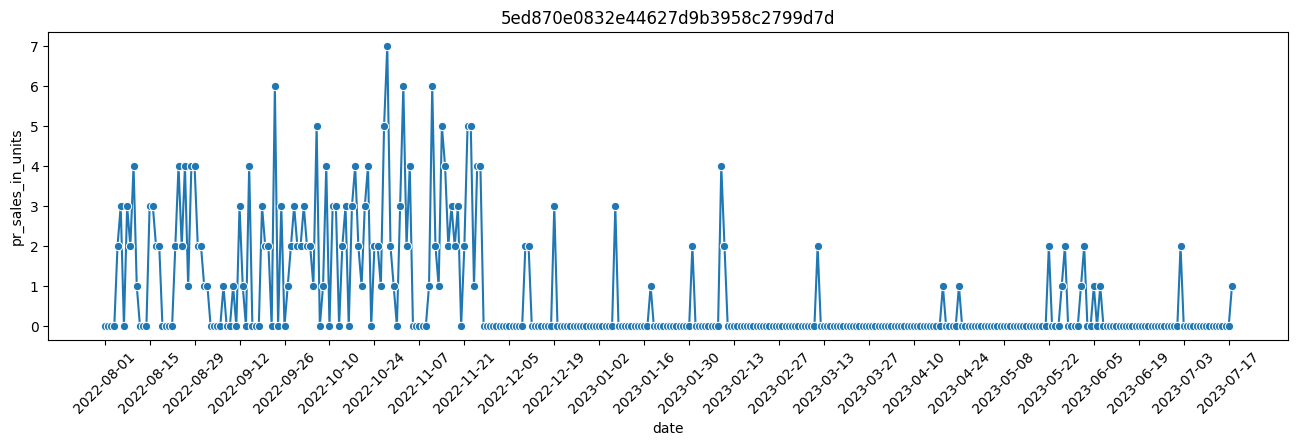

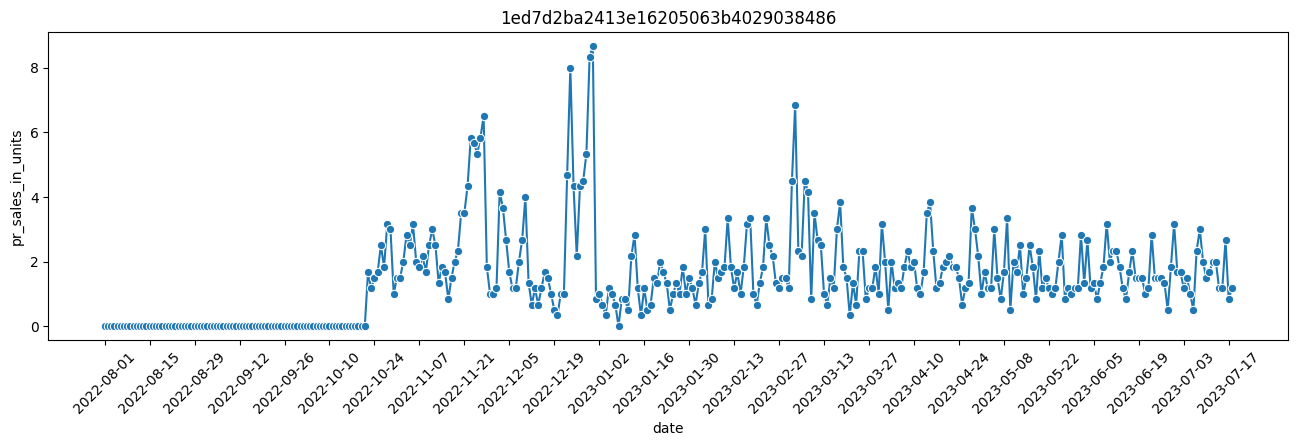

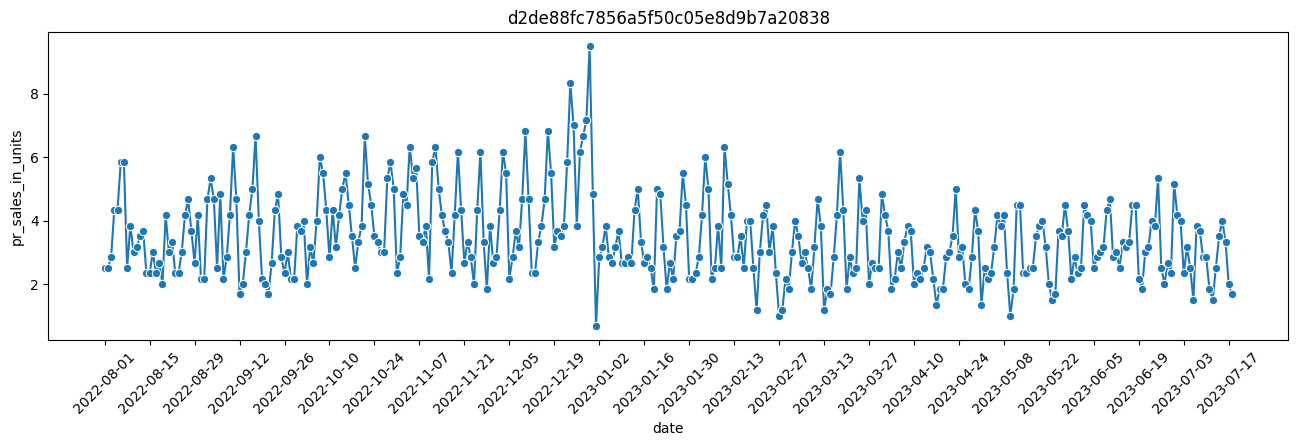

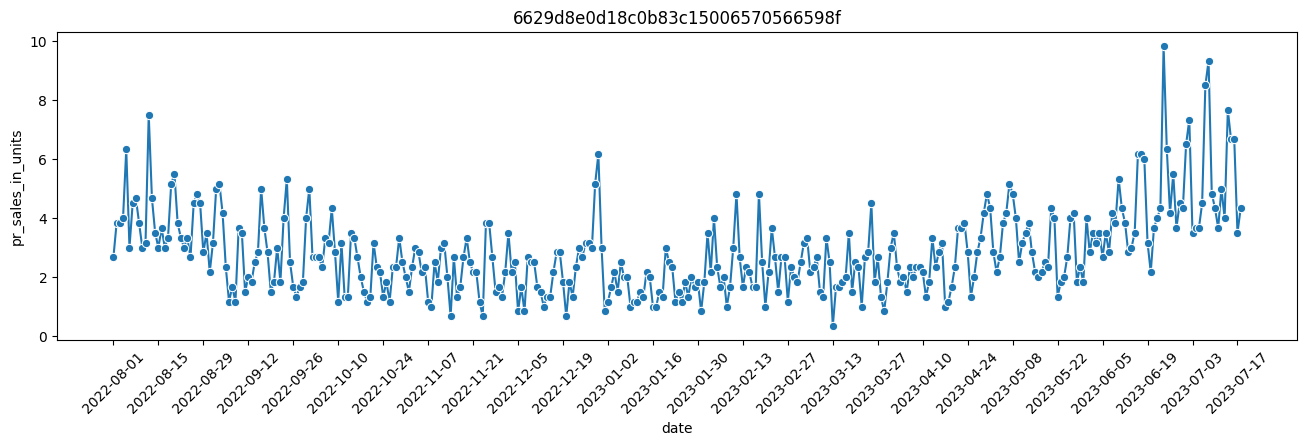

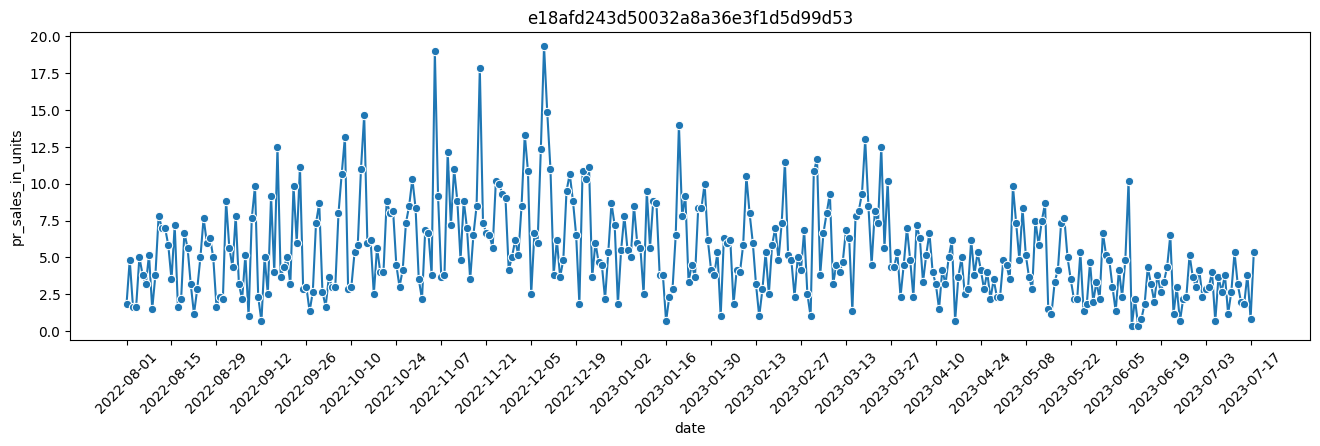

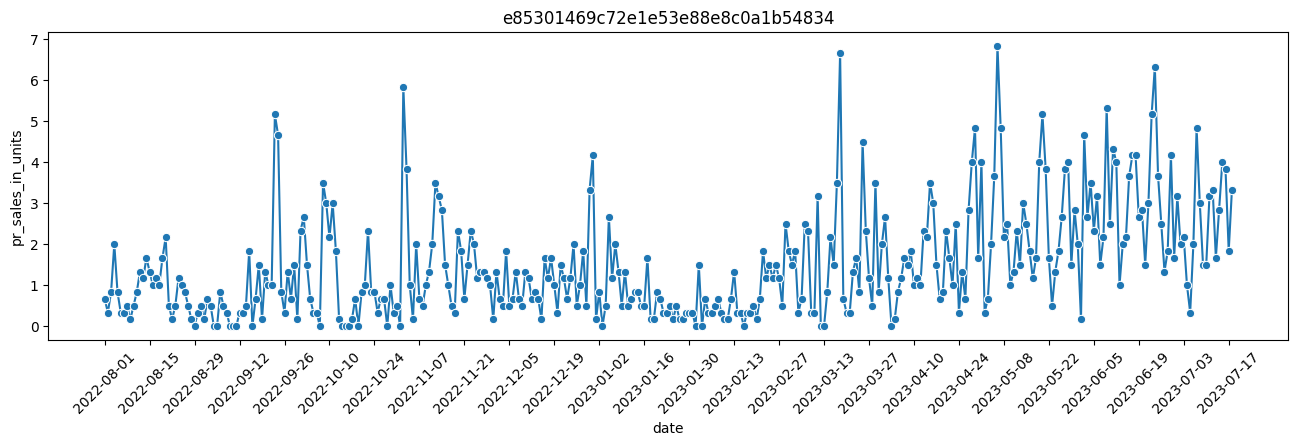

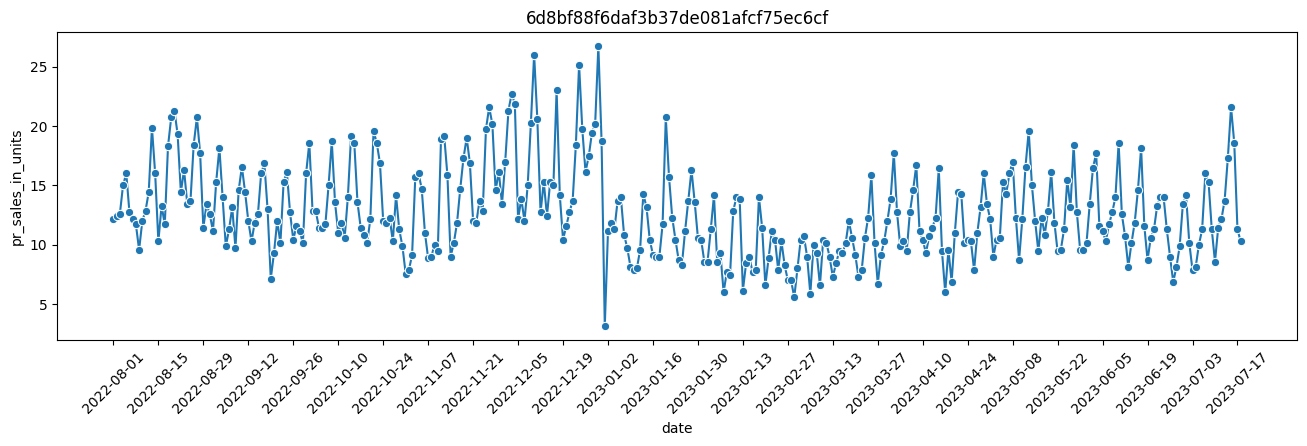

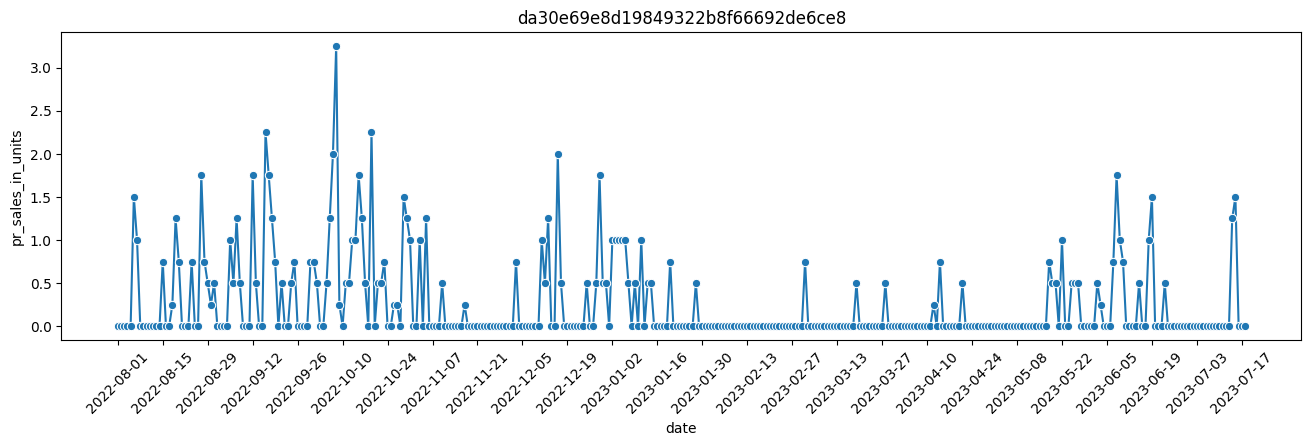

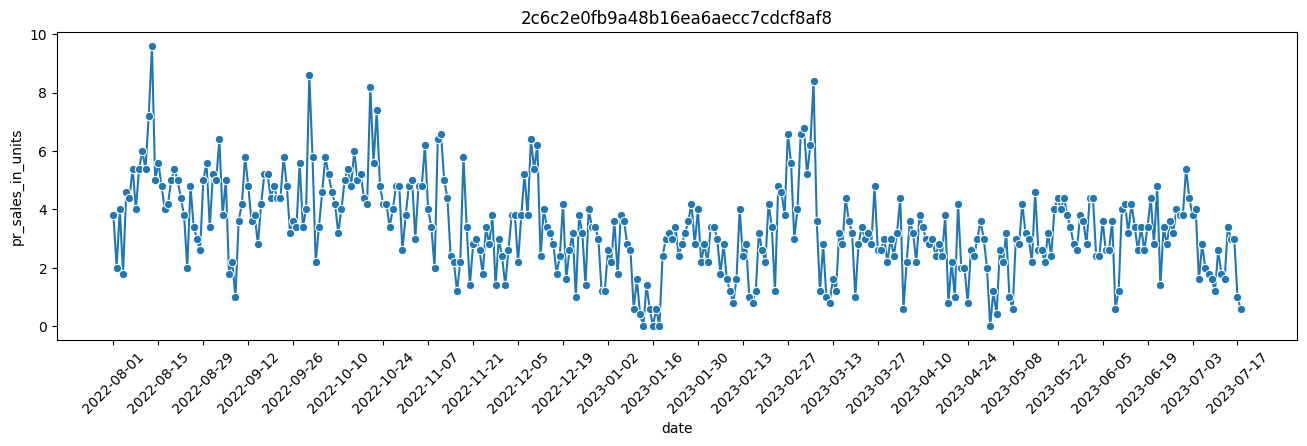

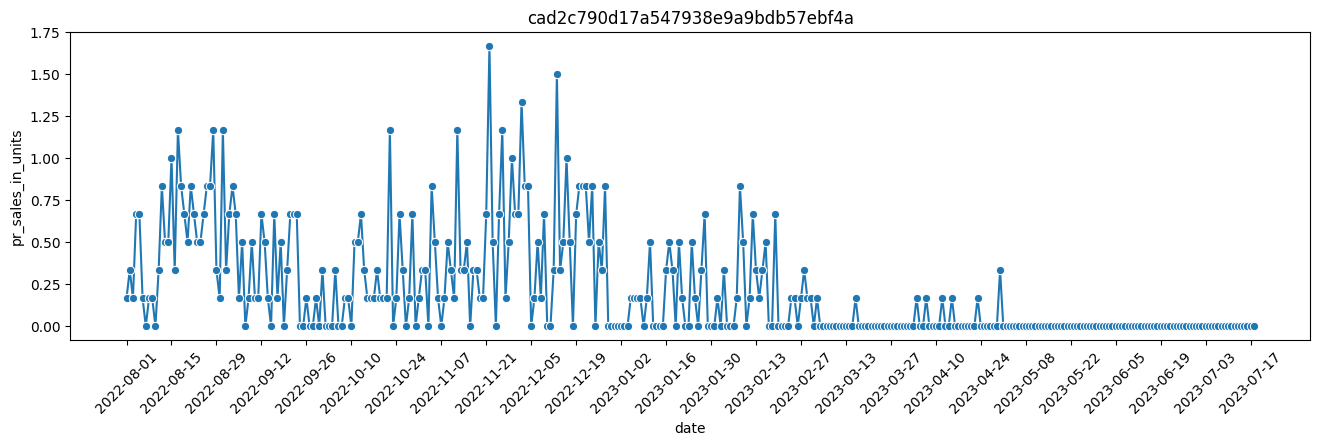

In [211]:
# # потом уберём - посмотреть насколько полные временные ряды
# # временные ряды для 10 случайных продуктов, которые в среднем (медина) продаются больше всего
# for idx in data_train['pr_sku_id'].sample(10):
#     plt.figure(figsize=(16,4))
#     sns.lineplot(data=data_train_sum_promo[(data_train_sum_promo['pr_sku_enc']==idx)], 
#                  x='date', y='pr_sales_in_units', marker='o', ci=None)
#     plt.xticks(np.arange(df['date'].min(), df['date'].max(), timedelta(days=14)), rotation=45)
#     plt.title(idx)
#     plt.show()

In [215]:
# доля нулей в целевом признаке
print('Доля нулей в целевом признаке:',
      round((data_train_sum_promo["pr_sales_in_units"]==0).sum() / len(data_train_sum_promo) * 100, 1), '%')


Доля нулей в целевом признаке: 69.4 %


### Кросс-валидация и обучение моделей


In [ ]:
scaler = StandardScaler()

In [15]:
del encoder

In [13]:
encoder = TargetEncoder(cols=['st_enc', 'pr_sku_enc', 'pr_group_id', 'pr_cat_id', 'pr_subcat_id', 
                              'st_city_id', 'st_division_code'])
# вынеси из функции, чтобы трижды не инициаллизировать

In [20]:
# КРОСС-ВАЛИДАЦИЯ
# Выборка последовательно делится на 3 части: train - обучение, valid - подбор ГП, валидация выбор лучшей, test - валидация
def train_valid_test(data, model, params, train_valid_split_size=0.75, test_range_days=14):
    """Функция для  кросс-валидации и выбора лучшей модели. Метрика качества - WAPE.
       Каждый фолд последовательно делится на 3 части: train - обучение, valid - подбор ГП, валидация выбор лучшей, test -валидация.
       На выходе - список лучших моделей на каждом фолде с метрикой wapr на тестовой выборке"""
    # первая и последняя даты датасета
    date_min = data.index.get_level_values(2).min()
    date_max = data.index.get_level_values(2).max()
    # дата, отделяющая 75% выборки
    date_point_split = get_date_at_point(date_min, date_max, 0.75).date()
    # 1 фолд - обучающая выборка
    train_data = data.loc[(slice(None), slice(None), 
                           pd.date_range(date_min, get_date_offset(date_point_split, -test_range_days)))]
    # 1 фолд - валидационная выборка: 14 дней с последней даты обучвющей выборки + 1 день
    validation_data = data.loc[(slice(None), slice(None), 
            pd.date_range((get_date_offset(date_point_split, -test_range_days) + timedelta(1)), date_point_split))]
    # инициализируем кодировщик и скейлер
    encoder = TargetEncoder(cols=['st_enc', 'pr_sku_enc', 'pr_group_id', 'pr_cat_id', 'pr_subcat_id', 
                                  'st_city_id', 'st_division_code'])
    # словарь для записи лучшей модели на каждом фолде 
    best_models = [] 
    # дата контроля конца датасета для остановки цикла перебора фолдов
    check_date_end = date_point_split
    while(check_date_end < date_max.date()):
        # функция выберет модель с подобранными ГП на фолде
        best_model = train_valid_hyperparams_tuning(train_data, validation_data, get_models_list(params, model))
        # создадим тестовую выборку для оценки модели на фолде, 14 дней после обучающего датасета
        date_end = get_date_offset(date_point_split, test_range_days)
        test_data = data.loc[(slice(None), slice(None), (pd.date_range(date_point_split, date_end) + timedelta(1)))] 
        features_test = test_data.drop('pr_sales_in_units', axis=1)
        target_test = test_data['pr_sales_in_units']
#         features_test = features_test.values #
        # выбор лучшей модели
        train_data = pd.concat([train_data, validation_data])
        features_train = train_data.drop('pr_sales_in_units', axis=1)
        target_train = train_data['pr_sales_in_units']
        features_train = encoder.fit_transform(features_train, target_train)
        features_test = encoder.transform(features_test, target_test) # обучаем на трейне, на тесте только трансформ

#         features_train = features_train.values #
        best_model.fit(features_train, target_train)

        #тренировка на новом трейне
        test_wape = calculate_wape(target_test, best_model.predict(features_test))
        best_models.append([best_model, test_wape])
        validation_data = test_data
        date_point_split = get_date_offset(date_point_split, test_range_days)
        check_date_end = get_date_offset(date_point_split, test_range_days)
        
#     # выбрать модель с ниаименьшим wape
#     min(best_models_lgbm, key=lambda x: x[1])[0]
    return best_models

#перебор гиперпараметров для этапа валидации
def train_valid_hyperparams_tuning(train_data, valid_data, models_list):
    # инициализируем кодировщик и скейлер
    encoder = TargetEncoder(cols=['st_enc', 'pr_sku_enc', 'pr_group_id', 'pr_cat_id', 'pr_subcat_id', 
                                  'st_city_id', 'st_division_code'])
    best_wape = 100
    best_model = models_list[0]
    for model in models_list:
        
        features_train = train_data.drop('pr_sales_in_units', axis=1)
        target_train = train_data['pr_sales_in_units']
        features_train = encoder.fit_transform(features_train, target_train)
#         features_train = features_train.values #
        features_valid = valid_data.drop('pr_sales_in_units', axis=1)
        target_valid = valid_data['pr_sales_in_units']
        features_valid = encoder.transform(features_valid, target_valid)
#         features_valid = features_valid.values #
        model.fit(features_train, target_train)
        wape = calculate_wape(target_valid, model.predict(features_valid))
        print(model, wape)
        if wape < best_wape:
            best_wape = wape
            best_model = model
    return best_model
    
def get_models_list(params, model):
    models = []
    for params_set in ParameterGrid(params):
        #print(params_set)
        new_model = copy.deepcopy(model)
        new_model.set_params(**params_set)
        models.append(new_model)
    return models

def calculate_wape(y_true: np.array, y_pred: np.array):
    return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))

def get_date_at_point(date_min, date_max, split):
    return date_min + (date_max-date_min) * split
        
def get_date_offset(date, offset):
    return (date + pd.DateOffset(days=offset)).date()

#### LGBM
Модель градиентного бустинга LightGBM 

In [11]:
# набор гиперпараметров LGBM
lgbm_params = {   
    'random_state':[42],
#     'max_depth':[-1, 3, 8, 16, 32],
#     'num_leaves':[15, 31, 45, 64],
#     'n_estimators':[100, 200, 500, 800]
                }

In [ ]:
%%time
# кросс-валидация модель lgbm
model_lgbm = LGBMRegressor()
best_models_lgbm = train_valid_test(data_train_sum_promo, model_lgbm, lgbm_params)


LGBMRegressor(random_state=42) 0.584806976666581


In [243]:
# sum(промо+непромо), в лагах пропуски оставлены
best_models_lgbm

[[LGBMRegressor(random_state=42), 0.5142739154839352],
 [LGBMRegressor(random_state=42), 0.5217980789821206],
 [LGBMRegressor(random_state=42), 0.5032234305050257],
 [LGBMRegressor(random_state=42), 0.47723903601147666],
 [LGBMRegressor(random_state=42), 0.4769655274148136],
 [LGBMRegressor(random_state=42), 0.4732108452954991]]

In [186]:
# выбрать из списка модель с минимальным wape
best_model_lgbm = min(best_models_lgbm, key=lambda x: x[1])[0]
best_model_lgbm

**Выгрузка модели**

In [86]:
# сохранить обученную модель с помощью joblib
joblib.dump(best_model_lgbm, 'lgbm_model.pkl')

**Важность признаков**

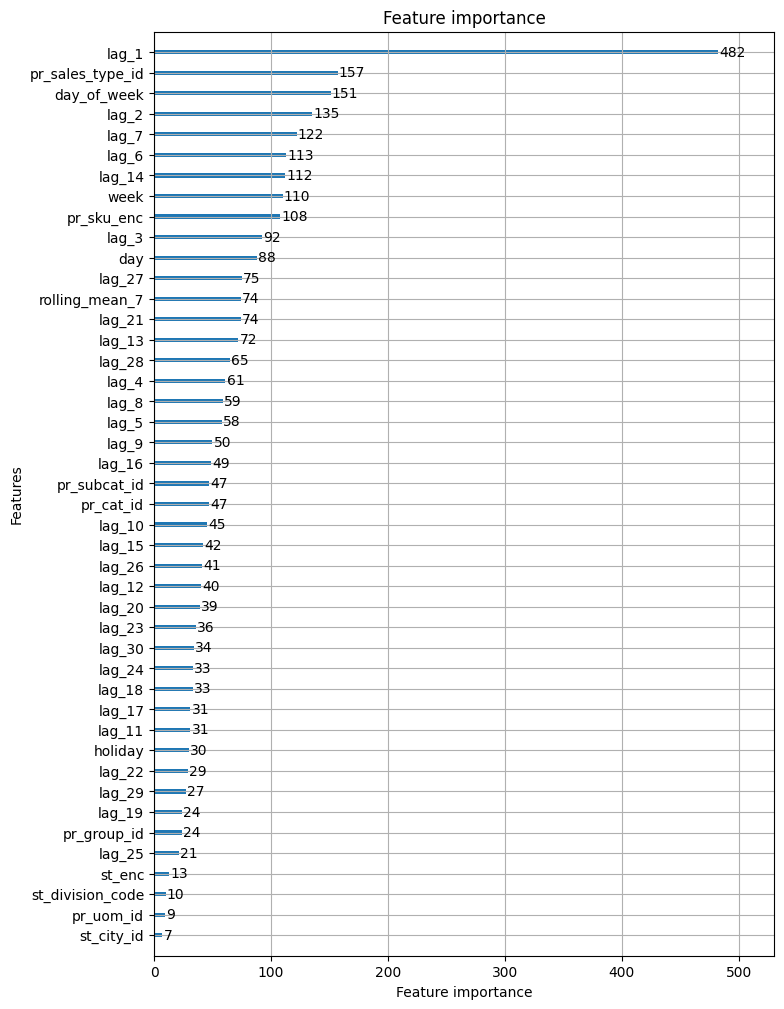

In [190]:
# график важности признаков
plot_importance(best_model_lgbm, figsize=(8, 12))
plt.show()

WARNING: Возможно lag_1 показывает нам переобучение модели.

То, что день недели является важным признаком - ожидаемо, так же, как и SKU.

day, week - тоже ожидаемо.

Изучим подробнее, важность признаков внутри lag_1 и внутри rolling_mean_7.

In [93]:
# Изучим важность признаков внутри lag_1 и rolling_mean_7:
def feature_imp(data, data_lag):
    X_with_lag = data.copy()
    X_with_lag['shifted'] = data_lag.shift(1)

    # Перейдем к абсолютной разнице между data_lag и shifted:
    X_with_lag['diff'] = abs(data_lag - X_with_lag['shifted'])

    # Удалим пропущенные значения, которые могли появиться из-за сдвига:
    X_with_lag = X_with_lag.dropna()

    # Получим важность признаков для новых признаков
    feature_importance_shifted = best_model_lgbm.feature_importances_  
    feature_importance__diff = best_model_lgbm.feature_importances_  
    
    # Получим важность изучаемого пизнака, для сравнения: 
    original_lag_importance = feature_importance_shifted[0] 

    result = f"Важность shifted: {feature_importance_shifted}\n" + \
         f"Важность diff: {feature_importance__diff}\n" + \
         f"Важность изучаемого признака: {original_lag_importance}"

    return print(result)


In [94]:
feature_imp(data_train_sum_promo, data_train_no_promo['lag_1'])

Важность shifted: [ 34 166 237 229 232  43  36  33  72   8   3  19   5   0   0 485 176 155
 119 138 137 157 171 145 200]
Важность diff: [ 34 166 237 229 232  43  36  33  72   8   3  19   5   0   0 485 176 155
 119 138 137 157 171 145 200]
Важность изучаемого признака: 34


In [95]:
feature_imp(data_train_sum_promo, data_train_no_promo['rolling_mean_7'])

Важность shifted: [ 34 166 237 229 232  43  36  33  72   8   3  19   5   0   0 485 176 155
 119 138 137 157 171 145 200]
Важность diff: [ 34 166 237 229 232  43  36  33  72   8   3  19   5   0   0 485 176 155
 119 138 137 157 171 145 200]
Важность изучаемого признака: 34


Признаки внутри lag_1 и rolling_mean_7 так же важны, как и сами исходные признаки. Значит, "заглядывания в будущее не было".

#### CatBoost

In [191]:
# # # расскоментировать строчки в кросс-валидации с .values
# model_cb = CatBoostRegressor(silent=True)
# best_models_cb = train_valid_test(data_train_sum_promo, model_cb, lgbm_params)
# best_models_cb

AttributeError: 'DataFrame' object has no attribute 'iteritems'

#### RandomForest


In [218]:
# # уберать наны
# model_rf = RandomForestRegressor()
# params_rf = {'random_state' : [42],
# #             'n_estimators' : [200, 400, 600, 1000],
# #             'max_depth' : [-1, 3, 8, 16]
#             }
# best_model_rf = train_valid_test(data_train_sum_promo, model_rf, params_rf)
# # best_model_rf

#### Linear Models

In [ ]:
# уберать наны
# model_lr = LinearRegression()
# params_lr = {}
# best_model_lgbm = train_valid_test(data_train_sum_promo, model_lr, params_lr)
# best_model_lr

## Прогнозирование
Функция прогнозирования делает предсказание на один день вперёд, далее генерирует на этот день лаговые признаки и делает предсказание на следующий.


In [ ]:
# загрузили 4 датасета, обработали
# сгенерировать обучающую выборку

# функция для прогнозирования
def forecasting(data_train, model):
    """Функция прогнозирования генерирует прогноз продаж в штуках на 14 следующих дней для всех комбинаций Магазин-Товар из датасета 
       с историческими данными о продажах data_train.
       На вход принимает обучающий датасет .....
       Подготавляивает данные для передачи в модель. Делает последовательные предсказания на каждый следующий день, на каждом шаге 
       пересчитывая лаговые признаки."""
    # последовательность дат, необходимых для предсказания 14 дней
    # берём последнюю дату из data_train и от неё генерируем следующие 14 дней
    test_dates = pd.date_range(start=(data_train.index.get_level_values(2).max() + timedelta(1)), 
                               periods=14, freq='1D').tolist()

    # шаблон со всеми комбинациями магазин-товар-дата из обучающей выбоки на 14 дат
    data_test_submission = prepare_full_ts_df_with_features(test_dates)

    # кодирование, обучаем на трейн
    encoder = TargetEncoder(cols=['st_enc', 'pr_sku_enc', 'pr_group_id', 'pr_cat_id', 'pr_subcat_id', 
                              'st_city_id', 'st_division_code'])
    cod_cols = ['st_enc', 'pr_sku_enc', 'pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'st_city_id', 'st_division_code']
    encoder.fit(data_train[cod_cols], data_train['pr_sales_in_units'])
    data_test_submission[cod_cols] = encoder.transform(data_test_submission[cod_cols])

    # данные из обучающего датасета за последние 30 дней
    pull_dates_train_data = pd.date_range(end=(test_dates[0] - timedelta(days=1)), periods=30)
    last_days_from_train = data_train.loc[data_train.index.get_level_values(2).isin(pull_dates_train_data)]
    # кодирование
    last_days_from_train[cod_cols] = encoder.transform(last_days_from_train[cod_cols])

    # присоединяем к сабмишн данные из трейна
    data_submission_test_ext = pd.concat([last_days_from_train, data_test_submission])

    # для каждой даты, для на которую нужно сделать прогнозирование
    for date in test_dates:
        # перерассчитываем лаговые признаки
        data_submission_test_ext = make_features_lag_alternate(data_submission_test_ext)
        # выделяем срез по дате из тестовой выборки (сабмишн)
        test_one_day = data_submission_test_ext[data_submission_test_ext.index.get_level_values(2)==date]
        # предсказание моделью для среза сохраняем в столбец pr_sales_in_units, округляем и пока модуль 
        test_one_day['pr_sales_in_units'] = (np.round(model.predict(
                                test_one_day.drop('pr_sales_in_units', axis=1))))
        # предсказанные значения для даты добавляем в общий датасет
        data_submission_test_ext.loc[data_submission_test_ext.index.get_level_values(2)==date, 'pr_sales_in_units']=\
                                    test_one_day['pr_sales_in_units']

    # удаляем лишнее из сабмишн
    data_test_submission_pred = data_submission_test_ext.loc[data_test_submission.index]
    result = data_test_submission_pred['pr_sales_in_units']

    result = data_test_submission_pred['pr_sales_in_units'].reset_index().\
                                                        rename(columns={'pr_sales_in_units': 'target'})
        
    return result #.to_json('sales_forecast.json', orient='records')


In [ ]:
submission = forecasting(data_train_sum_promo, best_model_lgbm)
submission

Сгенерировать предсказания под предоставленный сабмишн файл

<div style="background-color: #E8BFD8; padding: 10px;">
    
**Далее:**
- присоединить к непромо данные с промо: 
    - временно убираем знак промо, дополняем нехватающие временные ряды, для обучения возвращаем знак промо. Добавляем оставшиеся дублирующие записи по промо 
- сейчас после генерации лагов не удаляются пропуски
- Добавить скейлер
- написать код, чтобы сгенерировать предсказания под предоставленный сабмишн файл
- скользящее среднее 7 дней в период -2 недели (скользящее среднее по реальным значениям)
- Разделить на группы, например кластеры, для каждой обучить свою модель

---
## Выводы и резюме
<b> Описание решения: </b>
- Выбрана модель градиентного бустинга LightGBM
- Обучение, подбор гиперпараметров и измерение wape сделано в функции, которая делит датасет на train, valid, test шесть раз, где valid и test по две недели.
- Предсказания делаются последовательно на каждый следующий день с промежуточным рассчитыванием лаговых признаков.
---